<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/Data_Loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

In [1]:
#%%capture
#!pip install wandb --upgrade --quiet

In [2]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sazio (use `wandb login --relogin` to force relogin)


True

## Loading of Stringer spontaneous data



In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [6]:
# functions 

def moving_avg(array, factor = 5):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    zeros_ = np.zeros((array.shape[0], 2))
    array = np.hstack((array, zeros_))

    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
    array = np.mean(array, axis = 2)

    return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [7]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [8]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [9]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)

## shuffling for training purposes

#np.random.shuffle(dataRNN)

In [10]:
#unshuffled = np.array(data_)

In [11]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [12]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [13]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
    normed_dataRNN.append(neuron)# / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 
#avgd_normed_dataRNN = dataRNN#
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

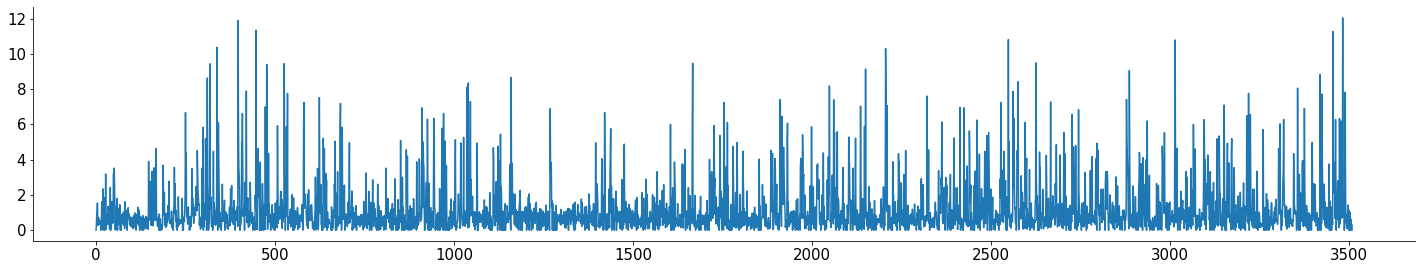

In [14]:
plt.plot(avgd_normed_dataRNN[0,:])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [18]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(10179, 3510)

In [19]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)
x2_train = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,:int(frac*avgd_normed_dataRNN.shape[1])]).to(device).float().unsqueeze(2)

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:n_neurs,int(frac*avgd_normed_dataRNN.shape[1]):]).to(device).float().unsqueeze(2)

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [20]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, num_layers = 1, n_comp = 50, dropout= 0,  bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = num_layers, dropout = dropout,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [21]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam']
        },
    'num_layers': {
        'values': [1]
        },
    'n_comp': {
        'values': [75]
        },
    
    'dropout': {
          'values': [0.2]
        },
    'weight_decay': {
          'values': [1e-6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 50000}
    })

import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'log_uniform',
        'min': -9.9,
        'max': -5.3
    },
})

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'dropout': {'values': [0.2]},
                'epochs': {'value': 50000},
                'learning_rate': {'distribution': 'log_uniform',
                                  'max': -5.3,
                                  'min': -9.9},
                'n_comp': {'values': [75]},
                'num_layers': {'values': [1]},
                'optimizer': {'values': ['adam']},
                'weight_decay': {'values': [1e-06]}}}


In [22]:
sweep_id = wandb.sweep(sweep_config, project="NMAs-Best-Params")

Create sweep with ID: j4acficv
Sweep URL: https://wandb.ai/sazio/NMAs-Best-Params/sweeps/j4acficv


In [23]:
# you can keep re-running this cell if you think the cost might decrease further
cost = nn.MSELoss()

# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370

## Training 

In [24]:
from tqdm import tqdm

In [25]:
def build_optimizer(network, optimizer, learning_rate, weight_decay): 
    optimizer = torch.optim.Adam(network.parameters(),
                               lr=learning_rate, weight_decay=weight_decay)
    return optimizer

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        # loader = build_dataset(config.batch_size)
        # Net(ncomp, NN1, NN2, bidi = True).to(device)
        network = Net(ncomp, NN1, NN2, config.num_layers, config.dropout).to(device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate, config.weight_decay)

        for epoch in range(config.epochs):
            # avg_loss = train_epoch(network, loader, optimizer)
            network.train()
            # the networkwork outputs the single-neuron prediction and the latents
            z, y = network(x1_train)

            # our cost
            loss = cost(z, x2_train)

            # train the networkwork as usual
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            with torch.no_grad():
                network.eval()
                valid_loss = cost(network(x1_valid)[0], x2_valid)

            if epoch % 50 == 0:
                with torch.no_grad():
                    network.eval()
                    valid_loss = cost(network(x1_valid)[0], x2_valid)
                    
                    print(f' iteration {epoch}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')
            wandb.log({"train_loss": loss.item(), 'valid_loss': valid_loss.item(), "epoch": epoch})

In [ ]:
wandb.agent(sweep_id, train, count= 50)

wandb: Agent Starting Run: pa1vwwr3 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0012131726751834916
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6897, valid cost 3.7538
 iteration 50, train cost 2.0757, valid cost 2.1443
 iteration 100, train cost 2.0653, valid cost 2.1347
 iteration 150, train cost 2.0184, valid cost 2.0722
 iteration 200, train cost 1.9835, valid cost 2.0312
 iteration 250, train cost 1.9550, valid cost 2.0008
 iteration 300, train cost 1.8799, valid cost 1.9277
 iteration 350, train cost 1.8084, valid cost 1.8620
 iteration 400, train cost 1.7641, valid cost 1.8237
 iteration 450, train cost 1.7371, valid cost 1.8023
 iteration 500, train cost 1.6980, valid cost 1.7796
 iteration 550, train cost 1.6662, valid cost 1.7579
 iteration 600, train cost 1.6347, valid cost 1.7353
 iteration 650, train cost 1.6063, valid cost 1.7144
 iteration 700, train cost 1.5791, valid cost 1.6936
 iteration 750, train cost 1.5511, valid cost 1.6756
 iteration 800, train cost 1.5268, valid cost 1.6604
 iteration 850, train cost 1.5035, valid cost 1.6459
 iteration 900, train cost 1.4833, valid cost 1.6

 iteration 7650, train cost 0.9547, valid cost 1.3145
 iteration 7700, train cost 0.9513, valid cost 1.3139
 iteration 7750, train cost 0.9704, valid cost 1.3109
 iteration 7800, train cost 0.9516, valid cost 1.3065
 iteration 7850, train cost 0.9495, valid cost 1.3111
 iteration 7900, train cost 0.9485, valid cost 1.3102
 iteration 7950, train cost 0.9479, valid cost 1.3102
 iteration 8000, train cost 0.9467, valid cost 1.3089
 iteration 8050, train cost 0.9448, valid cost 1.3097
 iteration 8100, train cost 0.9438, valid cost 1.3100
 iteration 8150, train cost 0.9517, valid cost 1.3100
 iteration 8200, train cost 0.9440, valid cost 1.3080
 iteration 8250, train cost 0.9425, valid cost 1.3095
 iteration 8300, train cost 0.9434, valid cost 1.3114
 iteration 8350, train cost 0.9473, valid cost 1.3060
 iteration 8400, train cost 0.9477, valid cost 1.3047
 iteration 8450, train cost 0.9479, valid cost 1.2992
 iteration 8500, train cost 0.9427, valid cost 1.3013
 iteration 8550, train cost 

 iteration 15150, train cost 0.9594, valid cost 1.3000
 iteration 15200, train cost 0.8940, valid cost 1.2733
 iteration 15250, train cost 0.8988, valid cost 1.2765
 iteration 15300, train cost 0.8916, valid cost 1.2734
 iteration 15350, train cost 0.8894, valid cost 1.2731
 iteration 15400, train cost 0.8891, valid cost 1.2744
 iteration 15450, train cost 0.8888, valid cost 1.2759
 iteration 15500, train cost 0.8873, valid cost 1.2728
 iteration 15550, train cost 0.8920, valid cost 1.2748
 iteration 15600, train cost 0.8854, valid cost 1.2730
 iteration 15650, train cost 0.8979, valid cost 1.2783
 iteration 15700, train cost 0.8876, valid cost 1.2737
 iteration 15750, train cost 0.8832, valid cost 1.2751
 iteration 15800, train cost 0.8839, valid cost 1.2761
 iteration 15850, train cost 0.8844, valid cost 1.2745
 iteration 15900, train cost 0.8814, valid cost 1.2742
 iteration 15950, train cost 0.8846, valid cost 1.2743
 iteration 16000, train cost 0.8807, valid cost 1.2727
 iteration

 iteration 22600, train cost 1.0198, valid cost 1.3255
 iteration 22650, train cost 1.0120, valid cost 1.3250
 iteration 22700, train cost 1.0300, valid cost 1.3300
 iteration 22750, train cost 1.0795, valid cost 1.3675
 iteration 22800, train cost 1.0311, valid cost 1.3415
 iteration 22850, train cost 1.1058, valid cost 1.3768
 iteration 22900, train cost 1.0281, valid cost 1.3340
 iteration 22950, train cost 1.0245, valid cost 1.3370
 iteration 23000, train cost 1.0212, valid cost 1.3391
 iteration 23050, train cost 1.0174, valid cost 1.3444
 iteration 23100, train cost 1.1851, valid cost 1.4182
 iteration 23150, train cost 1.0225, valid cost 1.3388
 iteration 23200, train cost 1.0161, valid cost 1.3383
 iteration 23250, train cost 1.0123, valid cost 1.3458
 iteration 23300, train cost 1.0109, valid cost 1.3447
 iteration 23350, train cost 1.0058, valid cost 1.3503
 iteration 23400, train cost 1.0052, valid cost 1.3464
 iteration 23450, train cost 1.0036, valid cost 1.3689
 iteration

 iteration 30050, train cost 0.9675, valid cost 1.4543
 iteration 30100, train cost 0.9664, valid cost 1.4835
 iteration 30150, train cost 0.9666, valid cost 1.5200
 iteration 30200, train cost 0.9689, valid cost 1.5129
 iteration 30250, train cost 0.9646, valid cost 1.5092
 iteration 30300, train cost 0.9634, valid cost 1.5146
 iteration 30350, train cost 0.9669, valid cost 1.5150
 iteration 30400, train cost 0.9639, valid cost 1.5515
 iteration 30450, train cost 0.9652, valid cost 1.5509
 iteration 30500, train cost 0.9662, valid cost 1.5305
 iteration 30550, train cost 0.9710, valid cost 1.5732
 iteration 30600, train cost 0.9611, valid cost 1.5340
 iteration 30650, train cost 0.9631, valid cost 1.5954
 iteration 30700, train cost 0.9602, valid cost 1.5022
 iteration 30750, train cost 0.9632, valid cost 1.4986
 iteration 30800, train cost 0.9600, valid cost 1.5141
 iteration 30850, train cost 0.9651, valid cost 1.4618
 iteration 30900, train cost 0.9594, valid cost 1.4355
 iteration

 iteration 37500, train cost 0.9986, valid cost 1.7430
 iteration 37550, train cost 0.9947, valid cost 1.7309
 iteration 37600, train cost 0.9946, valid cost 1.7606
 iteration 37650, train cost 0.9947, valid cost 1.7893
 iteration 37700, train cost 0.9939, valid cost 1.8090
 iteration 37750, train cost 0.9962, valid cost 1.8128
 iteration 37800, train cost 0.9931, valid cost 1.8035
 iteration 37850, train cost 0.9953, valid cost 1.7793
 iteration 37900, train cost 0.9952, valid cost 1.8113
 iteration 37950, train cost 0.9944, valid cost 1.7986
 iteration 38000, train cost 0.9928, valid cost 1.8947
 iteration 38050, train cost 0.9948, valid cost 1.8547
 iteration 38100, train cost 0.9940, valid cost 1.8725
 iteration 38150, train cost 0.9914, valid cost 1.9243
 iteration 38200, train cost 0.9912, valid cost 2.0038
 iteration 38250, train cost 0.9924, valid cost 2.0650
 iteration 38300, train cost 1.6539, valid cost 2.0545
 iteration 38350, train cost 1.3060, valid cost 7.1588
 iteration

 iteration 44950, train cost 2.1237, valid cost 2.2646
 iteration 45000, train cost 2.0509, valid cost 2.1608
 iteration 45050, train cost 2.0411, valid cost 2.1745
 iteration 45100, train cost 2.0236, valid cost 2.1559
 iteration 45150, train cost 1.9758, valid cost 2.0693
 iteration 45200, train cost 1.9074, valid cost 2.0022
 iteration 45250, train cost 1.8873, valid cost 1.9680
 iteration 45300, train cost 1.8621, valid cost 1.9458
 iteration 45350, train cost 1.8625, valid cost 1.9539
 iteration 45400, train cost 1.8235, valid cost 1.9135
 iteration 45450, train cost 1.7923, valid cost 1.9026
 iteration 45500, train cost 1.7662, valid cost 1.8943
 iteration 45550, train cost 1.7597, valid cost 1.8835
 iteration 45600, train cost 1.7375, valid cost 1.8672
 iteration 45650, train cost 1.7574, valid cost 1.8593
 iteration 45700, train cost 1.7269, valid cost 1.8731
 iteration 45750, train cost 1.7199, valid cost 1.8465
 iteration 45800, train cost 1.6990, valid cost 1.8334
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.76428
valid_loss,2.2678
epoch,49999
_runtime,6257
_timestamp,1628988426
_step,49999


train_loss,▇▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▇▆▅▄▆▇█▆█
valid_loss,▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▅▄▅▆▅▅▄▆▇▆▇▆█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: t947mjgs with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 8.353449287106722e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6919, valid cost 3.7691
 iteration 50, train cost 3.3429, valid cost 3.3974
 iteration 100, train cost 2.4122, valid cost 2.4560
 iteration 150, train cost 2.1541, valid cost 2.2033
 iteration 200, train cost 2.1006, valid cost 2.1527
 iteration 250, train cost 2.0873, valid cost 2.1420
 iteration 300, train cost 2.0819, valid cost 2.1384
 iteration 350, train cost 2.0784, valid cost 2.1366
 iteration 400, train cost 2.0756, valid cost 2.1354
 iteration 450, train cost 2.0733, valid cost 2.1346
 iteration 500, train cost 2.0717, valid cost 2.1336
 iteration 550, train cost 2.0700, valid cost 2.1326
 iteration 600, train cost 2.0675, valid cost 2.1309
 iteration 650, train cost 2.0633, valid cost 2.1275
 iteration 700, train cost 2.0552, valid cost 2.1196
 iteration 750, train cost 2.0414, valid cost 2.1042
 iteration 800, train cost 2.0198, valid cost 2.0812
 iteration 850, train cost 1.9967, valid cost 2.0571
 iteration 900, train cost 1.9760, valid cost 2.0

 iteration 7650, train cost 1.1325, valid cost 1.3649
 iteration 7700, train cost 1.1308, valid cost 1.3638
 iteration 7750, train cost 1.1281, valid cost 1.3627
 iteration 7800, train cost 1.1293, valid cost 1.3622
 iteration 7850, train cost 1.1257, valid cost 1.3603
 iteration 7900, train cost 1.1242, valid cost 1.3596
 iteration 7950, train cost 1.1216, valid cost 1.3581
 iteration 8000, train cost 1.1195, valid cost 1.3567
 iteration 8050, train cost 1.1175, valid cost 1.3559
 iteration 8100, train cost 1.1174, valid cost 1.3546
 iteration 8150, train cost 1.1165, valid cost 1.3533
 iteration 8200, train cost 1.1128, valid cost 1.3515
 iteration 8250, train cost 1.1107, valid cost 1.3505
 iteration 8300, train cost 1.1106, valid cost 1.3503
 iteration 8350, train cost 1.1070, valid cost 1.3479
 iteration 8400, train cost 1.1065, valid cost 1.3474
 iteration 8450, train cost 1.1049, valid cost 1.3465
 iteration 8500, train cost 1.1053, valid cost 1.3454
 iteration 8550, train cost 

 iteration 15150, train cost 0.9803, valid cost 1.2786
 iteration 15200, train cost 0.9799, valid cost 1.2772
 iteration 15250, train cost 0.9779, valid cost 1.2779
 iteration 15300, train cost 0.9779, valid cost 1.2773
 iteration 15350, train cost 0.9793, valid cost 1.2771
 iteration 15400, train cost 0.9757, valid cost 1.2770
 iteration 15450, train cost 0.9783, valid cost 1.2770
 iteration 15500, train cost 0.9732, valid cost 1.2753
 iteration 15550, train cost 0.9746, valid cost 1.2766
 iteration 15600, train cost 0.9767, valid cost 1.2763
 iteration 15650, train cost 0.9754, valid cost 1.2761
 iteration 15700, train cost 0.9737, valid cost 1.2766
 iteration 15750, train cost 0.9741, valid cost 1.2761
 iteration 15800, train cost 0.9732, valid cost 1.2749
 iteration 15850, train cost 0.9711, valid cost 1.2760
 iteration 15900, train cost 0.9722, valid cost 1.2757
 iteration 15950, train cost 0.9725, valid cost 1.2760
 iteration 16000, train cost 0.9754, valid cost 1.2750
 iteration

 iteration 22600, train cost 0.9254, valid cost 1.2678
 iteration 22650, train cost 0.9256, valid cost 1.2688
 iteration 22700, train cost 0.9241, valid cost 1.2688
 iteration 22750, train cost 0.9242, valid cost 1.2683
 iteration 22800, train cost 0.9245, valid cost 1.2694
 iteration 22850, train cost 0.9251, valid cost 1.2680
 iteration 22900, train cost 0.9245, valid cost 1.2673
 iteration 22950, train cost 0.9239, valid cost 1.2673
 iteration 23000, train cost 0.9258, valid cost 1.2670
 iteration 23050, train cost 0.9222, valid cost 1.2681
 iteration 23100, train cost 0.9218, valid cost 1.2670
 iteration 23150, train cost 0.9238, valid cost 1.2684
 iteration 23200, train cost 0.9210, valid cost 1.2679
 iteration 23250, train cost 0.9231, valid cost 1.2677
 iteration 23300, train cost 0.9218, valid cost 1.2681
 iteration 23350, train cost 0.9225, valid cost 1.2676
 iteration 23400, train cost 0.9213, valid cost 1.2672
 iteration 23450, train cost 0.9198, valid cost 1.2669
 iteration

 iteration 30050, train cost 0.8961, valid cost 1.2719
 iteration 30100, train cost 0.8972, valid cost 1.2703
 iteration 30150, train cost 0.8954, valid cost 1.2686
 iteration 30200, train cost 0.8965, valid cost 1.2732
 iteration 30250, train cost 0.8962, valid cost 1.2712
 iteration 30300, train cost 0.8962, valid cost 1.2709
 iteration 30350, train cost 0.8934, valid cost 1.2702
 iteration 30400, train cost 0.8950, valid cost 1.2708
 iteration 30450, train cost 0.8943, valid cost 1.2705
 iteration 30500, train cost 0.8925, valid cost 1.2687
 iteration 30550, train cost 0.8936, valid cost 1.2708
 iteration 30600, train cost 0.8916, valid cost 1.2697
 iteration 30650, train cost 0.8940, valid cost 1.2680
 iteration 30700, train cost 0.8954, valid cost 1.2712
 iteration 30750, train cost 0.8954, valid cost 1.2700
 iteration 30800, train cost 0.8925, valid cost 1.2696
 iteration 30850, train cost 0.8930, valid cost 1.2688
 iteration 30900, train cost 0.8947, valid cost 1.2688
 iteration

 iteration 37500, train cost 0.8752, valid cost 1.2689
 iteration 37550, train cost 0.8758, valid cost 1.2709
 iteration 37600, train cost 0.8771, valid cost 1.2698
 iteration 37650, train cost 0.8744, valid cost 1.2703
 iteration 37700, train cost 0.8740, valid cost 1.2690
 iteration 37750, train cost 0.8755, valid cost 1.2696
 iteration 37800, train cost 0.8744, valid cost 1.2694
 iteration 37850, train cost 0.8750, valid cost 1.2721
 iteration 37900, train cost 0.8748, valid cost 1.2693
 iteration 37950, train cost 0.8741, valid cost 1.2704
 iteration 38000, train cost 0.8756, valid cost 1.2699
 iteration 38050, train cost 0.8745, valid cost 1.2697
 iteration 38100, train cost 0.8758, valid cost 1.2693
 iteration 38150, train cost 0.8732, valid cost 1.2714
 iteration 38200, train cost 0.8744, valid cost 1.2703
 iteration 38250, train cost 0.8735, valid cost 1.2713
 iteration 38300, train cost 0.8744, valid cost 1.2710
 iteration 38350, train cost 0.8757, valid cost 1.2699
 iteration

 iteration 44950, train cost 0.8615, valid cost 1.2752
 iteration 45000, train cost 0.8629, valid cost 1.2769
 iteration 45050, train cost 0.8631, valid cost 1.2760
 iteration 45100, train cost 0.8626, valid cost 1.2764
 iteration 45150, train cost 0.8619, valid cost 1.2758
 iteration 45200, train cost 0.8632, valid cost 1.2764
 iteration 45250, train cost 0.8631, valid cost 1.2772
 iteration 45300, train cost 0.8611, valid cost 1.2761
 iteration 45350, train cost 0.8599, valid cost 1.2776
 iteration 45400, train cost 0.8608, valid cost 1.2774
 iteration 45450, train cost 0.8617, valid cost 1.2788
 iteration 45500, train cost 0.8618, valid cost 1.2757
 iteration 45550, train cost 0.8615, valid cost 1.2763
 iteration 45600, train cost 0.8606, valid cost 1.2768
 iteration 45650, train cost 0.8618, valid cost 1.2776
 iteration 45700, train cost 0.8589, valid cost 1.2772
 iteration 45750, train cost 0.8606, valid cost 1.2777
 iteration 45800, train cost 0.8611, valid cost 1.2769
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.85466
valid_loss,1.28057
epoch,49999
_runtime,8036
_timestamp,1628996466
_step,49999


train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: x1xo21up with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0008002015151333592
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6965, valid cost 3.7641
 iteration 50, train cost 2.0848, valid cost 2.1473
 iteration 100, train cost 2.0687, valid cost 2.1357
 iteration 150, train cost 2.0619, valid cost 2.1290
 iteration 200, train cost 1.9959, valid cost 2.0435
 iteration 250, train cost 1.9038, valid cost 1.9554
 iteration 300, train cost 1.8848, valid cost 1.9385
 iteration 350, train cost 1.8429, valid cost 1.9009
 iteration 400, train cost 1.7870, valid cost 1.8513
 iteration 450, train cost 1.7560, valid cost 1.8270
 iteration 500, train cost 1.7264, valid cost 1.8048
 iteration 550, train cost 1.6957, valid cost 1.7768
 iteration 600, train cost 1.6639, valid cost 1.7512
 iteration 650, train cost 1.6311, valid cost 1.7246
 iteration 700, train cost 1.5991, valid cost 1.7013
 iteration 750, train cost 1.5688, valid cost 1.6814
 iteration 800, train cost 1.5428, valid cost 1.6651
 iteration 850, train cost 1.5171, valid cost 1.6478
 iteration 900, train cost 1.5003, valid cost 1.6

 iteration 7650, train cost 0.9141, valid cost 1.2278
 iteration 7700, train cost 0.9127, valid cost 1.2276
 iteration 7750, train cost 0.9146, valid cost 1.2254
 iteration 7800, train cost 0.9118, valid cost 1.2248
 iteration 7850, train cost 0.9116, valid cost 1.2264
 iteration 7900, train cost 0.9101, valid cost 1.2274
 iteration 7950, train cost 0.9088, valid cost 1.2247
 iteration 8000, train cost 0.9098, valid cost 1.2244
 iteration 8050, train cost 0.9069, valid cost 1.2257
 iteration 8100, train cost 0.9074, valid cost 1.2250
 iteration 8150, train cost 0.9132, valid cost 1.2288
 iteration 8200, train cost 0.9054, valid cost 1.2264
 iteration 8250, train cost 0.9430, valid cost 1.2387
 iteration 8300, train cost 0.9055, valid cost 1.2226
 iteration 8350, train cost 0.9084, valid cost 1.2245
 iteration 8400, train cost 0.9054, valid cost 1.2239
 iteration 8450, train cost 0.9046, valid cost 1.2241
 iteration 8500, train cost 0.9030, valid cost 1.2239
 iteration 8550, train cost 

 iteration 15150, train cost 0.8581, valid cost 1.2070
 iteration 15200, train cost 0.8576, valid cost 1.2086
 iteration 15250, train cost 0.8586, valid cost 1.2069
 iteration 15300, train cost 0.8664, valid cost 1.2147
 iteration 15350, train cost 0.8756, valid cost 1.2111
 iteration 15400, train cost 0.8727, valid cost 1.2048
 iteration 15450, train cost 0.8677, valid cost 1.2061
 iteration 15500, train cost 0.8650, valid cost 1.2027
 iteration 15550, train cost 0.8629, valid cost 1.2050
 iteration 15600, train cost 0.8603, valid cost 1.2039
 iteration 15650, train cost 0.8600, valid cost 1.2044
 iteration 15700, train cost 0.8586, valid cost 1.2046
 iteration 15750, train cost 0.8586, valid cost 1.2048
 iteration 15800, train cost 0.8579, valid cost 1.2890
 iteration 15850, train cost 0.8605, valid cost 1.2031
 iteration 15900, train cost 0.8567, valid cost 1.2031
 iteration 15950, train cost 0.8583, valid cost 1.2038
 iteration 16000, train cost 0.8569, valid cost 1.2041
 iteration

 iteration 22600, train cost 0.8337, valid cost 1.1932
 iteration 22650, train cost 0.8350, valid cost 1.1936
 iteration 22700, train cost 0.8335, valid cost 1.1938
 iteration 22750, train cost 0.8335, valid cost 1.1924
 iteration 22800, train cost 0.8333, valid cost 1.1928
 iteration 22850, train cost 0.8328, valid cost 1.1932
 iteration 22900, train cost 0.8327, valid cost 1.1922
 iteration 22950, train cost 0.8333, valid cost 1.1936
 iteration 23000, train cost 0.8324, valid cost 1.1930
 iteration 23050, train cost 0.8326, valid cost 1.1922
 iteration 23100, train cost 0.8313, valid cost 1.1915
 iteration 23150, train cost 0.8313, valid cost 1.1924
 iteration 23200, train cost 0.8981, valid cost 1.2230
 iteration 23250, train cost 0.8346, valid cost 1.1905
 iteration 23300, train cost 0.8333, valid cost 1.1914
 iteration 23350, train cost 0.8327, valid cost 1.1918
 iteration 23400, train cost 0.8314, valid cost 1.1917
 iteration 23450, train cost 0.8306, valid cost 1.1907
 iteration

 iteration 30050, train cost 0.8226, valid cost 1.1790
 iteration 30100, train cost 0.8221, valid cost 1.1788
 iteration 30150, train cost 0.8498, valid cost 1.2040
 iteration 30200, train cost 0.8221, valid cost 1.1761
 iteration 30250, train cost 0.8219, valid cost 1.1762
 iteration 30300, train cost 0.8217, valid cost 1.1785
 iteration 30350, train cost 0.8208, valid cost 1.1782
 iteration 30400, train cost 0.8214, valid cost 1.1786
 iteration 30450, train cost 0.8212, valid cost 1.1771
 iteration 30500, train cost 0.8216, valid cost 1.1794
 iteration 30550, train cost 0.8191, valid cost 1.1790
 iteration 30600, train cost 0.8208, valid cost 1.1798
 iteration 30650, train cost 0.8205, valid cost 1.1787
 iteration 30700, train cost 0.8203, valid cost 1.1793
 iteration 30750, train cost 0.8220, valid cost 1.1798
 iteration 30800, train cost 0.8194, valid cost 1.1794
 iteration 30850, train cost 0.8212, valid cost 1.1782
 iteration 30900, train cost 0.8202, valid cost 1.1790
 iteration

 iteration 37500, train cost 0.8153, valid cost 1.1983
 iteration 37550, train cost 0.8161, valid cost 1.1943
 iteration 37600, train cost 0.8165, valid cost 1.1999
 iteration 37650, train cost 0.8145, valid cost 1.1986
 iteration 37700, train cost 0.8138, valid cost 1.1997
 iteration 37750, train cost 0.8149, valid cost 1.1960
 iteration 37800, train cost 0.8157, valid cost 1.1993
 iteration 37850, train cost 0.8155, valid cost 1.1986
 iteration 37900, train cost 0.8157, valid cost 1.1932
 iteration 37950, train cost 0.8147, valid cost 1.1954
 iteration 38000, train cost 0.8143, valid cost 1.1986
 iteration 38050, train cost 0.8157, valid cost 1.1986
 iteration 38100, train cost 0.8154, valid cost 1.1930
 iteration 38150, train cost 0.8140, valid cost 1.1929
 iteration 38200, train cost 0.8134, valid cost 1.1962
 iteration 38250, train cost 0.8139, valid cost 1.1969
 iteration 38300, train cost 0.8144, valid cost 1.1959
 iteration 38350, train cost 0.8300, valid cost 1.2148
 iteration

 iteration 44950, train cost 0.8087, valid cost 1.2173
 iteration 45000, train cost 0.8088, valid cost 1.2317
 iteration 45050, train cost 0.8091, valid cost 1.2208
 iteration 45100, train cost 0.8094, valid cost 1.2223
 iteration 45150, train cost 0.8089, valid cost 1.2192
 iteration 45200, train cost 0.8091, valid cost 1.2207
 iteration 45250, train cost 0.8109, valid cost 1.2336
 iteration 45300, train cost 0.8093, valid cost 1.2332
 iteration 45350, train cost 0.8092, valid cost 1.2202
 iteration 45400, train cost 0.8098, valid cost 1.2227
 iteration 45450, train cost 0.8082, valid cost 1.2216
 iteration 45500, train cost 0.8104, valid cost 1.2340
 iteration 45550, train cost 0.8107, valid cost 1.2294
 iteration 45600, train cost 0.8085, valid cost 1.2252
 iteration 45650, train cost 0.8094, valid cost 1.2262
 iteration 45700, train cost 0.8087, valid cost 1.2299
 iteration 45750, train cost 0.8089, valid cost 1.2262
 iteration 45800, train cost 0.8081, valid cost 1.2257
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.80479
valid_loss,1.23314
epoch,49999
_runtime,8031
_timestamp,1629004502
_step,49999


train_loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z9wjuadc with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00018966054307509043
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6922, valid cost 3.7677
 iteration 50, train cost 2.5509, valid cost 2.5899
 iteration 100, train cost 2.1206, valid cost 2.1787
 iteration 150, train cost 2.0834, valid cost 2.1440
 iteration 200, train cost 2.0750, valid cost 2.1370
 iteration 250, train cost 2.0714, valid cost 2.1344
 iteration 300, train cost 2.0686, valid cost 2.1327
 iteration 350, train cost 2.0655, valid cost 2.1306
 iteration 400, train cost 2.0609, valid cost 2.1262
 iteration 450, train cost 2.0498, valid cost 2.1143
 iteration 500, train cost 2.0240, valid cost 2.0842
 iteration 550, train cost 1.9926, valid cost 2.0497
 iteration 600, train cost 1.9670, valid cost 2.0243
 iteration 650, train cost 1.9287, valid cost 1.9856
 iteration 700, train cost 1.8938, valid cost 1.9490
 iteration 750, train cost 1.8608, valid cost 1.9154
 iteration 800, train cost 1.8257, valid cost 1.8790
 iteration 850, train cost 1.8002, valid cost 1.8547
 iteration 900, train cost 1.7852, valid cost 1.8

 iteration 7650, train cost 1.0207, valid cost 1.2854
 iteration 7700, train cost 1.0187, valid cost 1.2850
 iteration 7750, train cost 1.0184, valid cost 1.2848
 iteration 7800, train cost 1.0158, valid cost 1.2838
 iteration 7850, train cost 1.0156, valid cost 1.2839
 iteration 7900, train cost 1.0131, valid cost 1.2837
 iteration 7950, train cost 1.0117, valid cost 1.2832
 iteration 8000, train cost 1.0099, valid cost 1.2823
 iteration 8050, train cost 1.0100, valid cost 1.2820
 iteration 8100, train cost 1.0092, valid cost 1.2824
 iteration 8150, train cost 1.0090, valid cost 1.2816
 iteration 8200, train cost 1.0053, valid cost 1.2808
 iteration 8250, train cost 1.0032, valid cost 1.2809
 iteration 8300, train cost 1.0059, valid cost 1.2806
 iteration 8350, train cost 1.0034, valid cost 1.2800
 iteration 8400, train cost 1.0026, valid cost 1.2803
 iteration 8450, train cost 1.0021, valid cost 1.2795
 iteration 8500, train cost 1.0000, valid cost 1.2792
 iteration 8550, train cost 

 iteration 15150, train cost 0.9252, valid cost 1.2563
 iteration 15200, train cost 0.9215, valid cost 1.2569
 iteration 15250, train cost 0.9214, valid cost 1.2566
 iteration 15300, train cost 0.9215, valid cost 1.2571
 iteration 15350, train cost 0.9213, valid cost 1.2568
 iteration 15400, train cost 0.9219, valid cost 1.2566
 iteration 15450, train cost 0.9208, valid cost 1.2567
 iteration 15500, train cost 0.9206, valid cost 1.2567
 iteration 15550, train cost 0.9209, valid cost 1.2567
 iteration 15600, train cost 0.9199, valid cost 1.2564
 iteration 15650, train cost 0.9210, valid cost 1.2565
 iteration 15700, train cost 0.9197, valid cost 1.2562
 iteration 15750, train cost 0.9189, valid cost 1.2565
 iteration 15800, train cost 0.9186, valid cost 1.2565
 iteration 15850, train cost 0.9185, valid cost 1.2562
 iteration 15900, train cost 0.9178, valid cost 1.2570
 iteration 15950, train cost 0.9182, valid cost 1.2561
 iteration 16000, train cost 0.9176, valid cost 1.2561
 iteration

 iteration 22600, train cost 0.8853, valid cost 1.2448
 iteration 22650, train cost 0.8814, valid cost 1.2438
 iteration 22700, train cost 0.8830, valid cost 1.2440
 iteration 22750, train cost 0.8830, valid cost 1.2435
 iteration 22800, train cost 0.8842, valid cost 1.2442
 iteration 22850, train cost 0.8827, valid cost 1.2442
 iteration 22900, train cost 0.8816, valid cost 1.2438
 iteration 22950, train cost 0.8807, valid cost 1.2434
 iteration 23000, train cost 0.8809, valid cost 1.2436
 iteration 23050, train cost 0.8811, valid cost 1.2436
 iteration 23100, train cost 0.8820, valid cost 1.2435
 iteration 23150, train cost 0.8798, valid cost 1.2430
 iteration 23200, train cost 0.8813, valid cost 1.2433
 iteration 23250, train cost 0.8812, valid cost 1.2429
 iteration 23300, train cost 0.8796, valid cost 1.2432
 iteration 23350, train cost 0.8797, valid cost 1.2431
 iteration 23400, train cost 0.8800, valid cost 1.2432
 iteration 23450, train cost 0.8812, valid cost 1.2425
 iteration

 iteration 30050, train cost 0.8593, valid cost 1.2320
 iteration 30100, train cost 0.8587, valid cost 1.2333
 iteration 30150, train cost 0.8566, valid cost 1.2328
 iteration 30200, train cost 0.8584, valid cost 1.2324
 iteration 30250, train cost 0.8576, valid cost 1.2325
 iteration 30300, train cost 0.8580, valid cost 1.2324
 iteration 30350, train cost 0.8564, valid cost 1.2327
 iteration 30400, train cost 0.8581, valid cost 1.2317
 iteration 30450, train cost 0.8586, valid cost 1.2322
 iteration 30500, train cost 0.8574, valid cost 1.2315
 iteration 30550, train cost 0.8579, valid cost 1.2308
 iteration 30600, train cost 0.8571, valid cost 1.2317
 iteration 30650, train cost 0.8559, valid cost 1.2316
 iteration 30700, train cost 0.8563, valid cost 1.2316
 iteration 30750, train cost 0.8567, valid cost 1.2308
 iteration 30800, train cost 0.8558, valid cost 1.2316
 iteration 30850, train cost 0.8556, valid cost 1.2319
 iteration 30900, train cost 0.8575, valid cost 1.2311
 iteration

 iteration 37500, train cost 0.8422, valid cost 1.2264
 iteration 37550, train cost 0.8403, valid cost 1.2245
 iteration 37600, train cost 0.8413, valid cost 1.2252
 iteration 37650, train cost 0.8411, valid cost 1.2249
 iteration 37700, train cost 0.8419, valid cost 1.2253
 iteration 37750, train cost 0.8402, valid cost 1.2251
 iteration 37800, train cost 0.8394, valid cost 1.2255
 iteration 37850, train cost 0.8392, valid cost 1.2259
 iteration 37900, train cost 0.8404, valid cost 1.2251
 iteration 37950, train cost 0.8404, valid cost 1.2252
 iteration 38000, train cost 0.8400, valid cost 1.2243
 iteration 38050, train cost 0.8413, valid cost 1.2255
 iteration 38100, train cost 0.8401, valid cost 1.2262
 iteration 38150, train cost 0.8404, valid cost 1.2244
 iteration 38200, train cost 0.8402, valid cost 1.2250
 iteration 38250, train cost 0.8396, valid cost 1.2247
 iteration 38300, train cost 0.8416, valid cost 1.2244
 iteration 38350, train cost 0.8403, valid cost 1.2246
 iteration

 iteration 44950, train cost 0.8295, valid cost 1.2179
 iteration 45000, train cost 0.8318, valid cost 1.2190
 iteration 45050, train cost 0.8295, valid cost 1.2188
 iteration 45100, train cost 0.8295, valid cost 1.2188
 iteration 45150, train cost 0.8292, valid cost 1.2175
 iteration 45200, train cost 0.8296, valid cost 1.2179
 iteration 45250, train cost 0.8273, valid cost 1.2181
 iteration 45300, train cost 0.8295, valid cost 1.2177
 iteration 45350, train cost 0.8308, valid cost 1.2184
 iteration 45400, train cost 0.8286, valid cost 1.2180
 iteration 45450, train cost 0.8293, valid cost 1.2177
 iteration 45500, train cost 0.8286, valid cost 1.2180
 iteration 45550, train cost 0.8295, valid cost 1.2186
 iteration 45600, train cost 0.8289, valid cost 1.2176
 iteration 45650, train cost 0.8289, valid cost 1.2170
 iteration 45700, train cost 0.8290, valid cost 1.2171
 iteration 45750, train cost 0.8289, valid cost 1.2169
 iteration 45800, train cost 0.8284, valid cost 1.2180
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.82361
valid_loss,1.21156
epoch,49999
_runtime,8042
_timestamp,1629012548
_step,49999


train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kvi5ze6c with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00012177385841139993
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6932, valid cost 3.7707
 iteration 50, train cost 2.9216, valid cost 2.9637
 iteration 100, train cost 2.1964, valid cost 2.2486
 iteration 150, train cost 2.0938, valid cost 2.1468
 iteration 200, train cost 2.0805, valid cost 2.1366
 iteration 250, train cost 2.0759, valid cost 2.1345
 iteration 300, train cost 2.0731, valid cost 2.1333
 iteration 350, train cost 2.0701, valid cost 2.1320
 iteration 400, train cost 2.0673, valid cost 2.1300
 iteration 450, train cost 2.0626, valid cost 2.1260
 iteration 500, train cost 2.0536, valid cost 2.1165
 iteration 550, train cost 2.0327, valid cost 2.0935
 iteration 600, train cost 2.0019, valid cost 2.0598
 iteration 650, train cost 1.9715, valid cost 2.0301
 iteration 700, train cost 1.9400, valid cost 2.0002
 iteration 750, train cost 1.9124, valid cost 1.9715
 iteration 800, train cost 1.8912, valid cost 1.9476
 iteration 850, train cost 1.8720, valid cost 1.9272
 iteration 900, train cost 1.8561, valid cost 1.9

 iteration 7650, train cost 1.0762, valid cost 1.2863
 iteration 7700, train cost 1.0736, valid cost 1.2860
 iteration 7750, train cost 1.0728, valid cost 1.2841
 iteration 7800, train cost 1.0723, valid cost 1.2835
 iteration 7850, train cost 1.0703, valid cost 1.2824
 iteration 7900, train cost 1.0688, valid cost 1.2818
 iteration 7950, train cost 1.0676, valid cost 1.2802
 iteration 8000, train cost 1.0647, valid cost 1.2795
 iteration 8050, train cost 1.0629, valid cost 1.2781
 iteration 8100, train cost 1.0628, valid cost 1.2774
 iteration 8150, train cost 1.0610, valid cost 1.2766
 iteration 8200, train cost 1.0573, valid cost 1.2752
 iteration 8250, train cost 1.0581, valid cost 1.2745
 iteration 8300, train cost 1.0546, valid cost 1.2737
 iteration 8350, train cost 1.0535, valid cost 1.2728
 iteration 8400, train cost 1.0509, valid cost 1.2722
 iteration 8450, train cost 1.0518, valid cost 1.2713
 iteration 8500, train cost 1.0507, valid cost 1.2702
 iteration 8550, train cost 

 iteration 15150, train cost 0.9461, valid cost 1.2254
 iteration 15200, train cost 0.9479, valid cost 1.2260
 iteration 15250, train cost 0.9447, valid cost 1.2252
 iteration 15300, train cost 0.9423, valid cost 1.2252
 iteration 15350, train cost 0.9429, valid cost 1.2248
 iteration 15400, train cost 0.9440, valid cost 1.2248
 iteration 15450, train cost 0.9428, valid cost 1.2248
 iteration 15500, train cost 0.9410, valid cost 1.2247
 iteration 15550, train cost 0.9424, valid cost 1.2243
 iteration 15600, train cost 0.9412, valid cost 1.2246
 iteration 15650, train cost 0.9413, valid cost 1.2244
 iteration 15700, train cost 0.9395, valid cost 1.2241
 iteration 15750, train cost 0.9408, valid cost 1.2242
 iteration 15800, train cost 0.9412, valid cost 1.2239
 iteration 15850, train cost 0.9393, valid cost 1.2237
 iteration 15900, train cost 0.9395, valid cost 1.2236
 iteration 15950, train cost 0.9399, valid cost 1.2235
 iteration 16000, train cost 0.9367, valid cost 1.2234
 iteration

 iteration 22600, train cost 0.9036, valid cost 1.2158
 iteration 22650, train cost 0.9035, valid cost 1.2156
 iteration 22700, train cost 0.9044, valid cost 1.2155
 iteration 22750, train cost 0.9015, valid cost 1.2155
 iteration 22800, train cost 0.9034, valid cost 1.2159
 iteration 22850, train cost 0.9046, valid cost 1.2161
 iteration 22900, train cost 0.9029, valid cost 1.2152
 iteration 22950, train cost 0.9028, valid cost 1.2156
 iteration 23000, train cost 0.9020, valid cost 1.2157
 iteration 23050, train cost 0.9024, valid cost 1.2153
 iteration 23100, train cost 0.9005, valid cost 1.2155
 iteration 23150, train cost 0.9007, valid cost 1.2154
 iteration 23200, train cost 0.9006, valid cost 1.2155
 iteration 23250, train cost 0.9013, valid cost 1.2151
 iteration 23300, train cost 0.9010, valid cost 1.2155
 iteration 23350, train cost 0.8995, valid cost 1.2150
 iteration 23400, train cost 0.9005, valid cost 1.2150
 iteration 23450, train cost 0.9027, valid cost 1.2152
 iteration

 iteration 30050, train cost 0.8781, valid cost 1.2118
 iteration 30100, train cost 0.8807, valid cost 1.2122
 iteration 30150, train cost 0.8787, valid cost 1.2118
 iteration 30200, train cost 0.8798, valid cost 1.2122
 iteration 30250, train cost 0.8805, valid cost 1.2117
 iteration 30300, train cost 0.8796, valid cost 1.2120
 iteration 30350, train cost 0.8800, valid cost 1.2116
 iteration 30400, train cost 0.8815, valid cost 1.2124
 iteration 30450, train cost 0.8807, valid cost 1.2128
 iteration 30500, train cost 0.8801, valid cost 1.2118
 iteration 30550, train cost 0.8825, valid cost 1.2120
 iteration 30600, train cost 0.8785, valid cost 1.2117
 iteration 30650, train cost 0.8787, valid cost 1.2115
 iteration 30700, train cost 0.8776, valid cost 1.2110
 iteration 30750, train cost 0.8785, valid cost 1.2113
 iteration 30800, train cost 0.8779, valid cost 1.2121
 iteration 30850, train cost 0.8766, valid cost 1.2115
 iteration 30900, train cost 0.8787, valid cost 1.2118
 iteration

 iteration 37500, train cost 0.8665, valid cost 1.2095
 iteration 37550, train cost 0.8647, valid cost 1.2092
 iteration 37600, train cost 0.8675, valid cost 1.2093
 iteration 37650, train cost 0.8643, valid cost 1.2096
 iteration 37700, train cost 0.8656, valid cost 1.2088
 iteration 37750, train cost 0.8665, valid cost 1.2090
 iteration 37800, train cost 0.8650, valid cost 1.2090
 iteration 37850, train cost 0.8652, valid cost 1.2089
 iteration 37900, train cost 0.8636, valid cost 1.2090
 iteration 37950, train cost 0.8626, valid cost 1.2091
 iteration 38000, train cost 0.8644, valid cost 1.2093
 iteration 38050, train cost 0.8632, valid cost 1.2082
 iteration 38100, train cost 0.8629, valid cost 1.2091
 iteration 38150, train cost 0.8641, valid cost 1.2083
 iteration 38200, train cost 0.8640, valid cost 1.2092
 iteration 38250, train cost 0.8635, valid cost 1.2093
 iteration 38300, train cost 0.8619, valid cost 1.2088
 iteration 38350, train cost 0.8637, valid cost 1.2087
 iteration

 iteration 44950, train cost 0.8508, valid cost 1.2073
 iteration 45000, train cost 0.8533, valid cost 1.2079
 iteration 45050, train cost 0.8519, valid cost 1.2078
 iteration 45100, train cost 0.8526, valid cost 1.2081
 iteration 45150, train cost 0.8524, valid cost 1.2068
 iteration 45200, train cost 0.8512, valid cost 1.2078
 iteration 45250, train cost 0.8541, valid cost 1.2083
 iteration 45300, train cost 0.8528, valid cost 1.2079
 iteration 45350, train cost 0.8522, valid cost 1.2080
 iteration 45400, train cost 0.8526, valid cost 1.2080
 iteration 45450, train cost 0.8513, valid cost 1.2073
 iteration 45500, train cost 0.8520, valid cost 1.2083
 iteration 45550, train cost 0.8515, valid cost 1.2081
 iteration 45600, train cost 0.8529, valid cost 1.2072
 iteration 45650, train cost 0.8518, valid cost 1.2068
 iteration 45700, train cost 0.8512, valid cost 1.2080
 iteration 45750, train cost 0.8527, valid cost 1.2073
 iteration 45800, train cost 0.8519, valid cost 1.2082
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.84657
valid_loss,1.20733
epoch,49999
_runtime,8029
_timestamp,1629020582
_step,49999


train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hc0jdoeh with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0009038446222016545
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6895, valid cost 3.7558
 iteration 50, train cost 2.0825, valid cost 2.1473
 iteration 100, train cost 2.0681, valid cost 2.1360
 iteration 150, train cost 2.0564, valid cost 2.1223
 iteration 200, train cost 1.9961, valid cost 2.0502
 iteration 250, train cost 1.9750, valid cost 2.0251
 iteration 300, train cost 1.8979, valid cost 1.9490
 iteration 350, train cost 1.8643, valid cost 1.9127
 iteration 400, train cost 1.7944, valid cost 1.8476
 iteration 450, train cost 1.7588, valid cost 1.8184
 iteration 500, train cost 1.7301, valid cost 1.7984
 iteration 550, train cost 1.6989, valid cost 1.7755
 iteration 600, train cost 1.6675, valid cost 1.7534
 iteration 650, train cost 1.6330, valid cost 1.7274
 iteration 700, train cost 1.6008, valid cost 1.7023
 iteration 750, train cost 1.5705, valid cost 1.6798
 iteration 800, train cost 1.5474, valid cost 1.6637
 iteration 850, train cost 1.5226, valid cost 1.6433
 iteration 900, train cost 1.5202, valid cost 1.6

 iteration 7650, train cost 0.9203, valid cost 1.2093
 iteration 7700, train cost 0.9190, valid cost 1.2081
 iteration 7750, train cost 0.9253, valid cost 1.2107
 iteration 7800, train cost 0.9189, valid cost 1.2075
 iteration 7850, train cost 0.9149, valid cost 1.2070
 iteration 7900, train cost 0.9162, valid cost 1.2076
 iteration 7950, train cost 0.9159, valid cost 1.2065
 iteration 8000, train cost 0.9147, valid cost 1.2074
 iteration 8050, train cost 0.9124, valid cost 1.2053
 iteration 8100, train cost 0.9102, valid cost 1.2062
 iteration 8150, train cost 0.9133, valid cost 1.2064
 iteration 8200, train cost 0.9277, valid cost 1.2099
 iteration 8250, train cost 0.9117, valid cost 1.2005
 iteration 8300, train cost 0.9080, valid cost 1.2024
 iteration 8350, train cost 0.9086, valid cost 1.2013
 iteration 8400, train cost 0.9054, valid cost 1.2024
 iteration 8450, train cost 0.9054, valid cost 1.2025
 iteration 8500, train cost 0.9061, valid cost 1.2024
 iteration 8550, train cost 

 iteration 15150, train cost 0.8550, valid cost 1.1756
 iteration 15200, train cost 0.8561, valid cost 1.1756
 iteration 15250, train cost 0.8609, valid cost 1.1754
 iteration 15300, train cost 0.8564, valid cost 1.1761
 iteration 15350, train cost 0.8547, valid cost 1.1776
 iteration 15400, train cost 0.8548, valid cost 1.1766
 iteration 15450, train cost 0.8551, valid cost 1.1771
 iteration 15500, train cost 0.8538, valid cost 1.1763
 iteration 15550, train cost 0.8534, valid cost 1.1770
 iteration 15600, train cost 0.8531, valid cost 1.1767
 iteration 15650, train cost 0.8533, valid cost 1.1768
 iteration 15700, train cost 0.8522, valid cost 1.1754
 iteration 15750, train cost 0.8575, valid cost 1.1798
 iteration 15800, train cost 0.8519, valid cost 1.1750
 iteration 15850, train cost 0.9033, valid cost 1.2166
 iteration 15900, train cost 0.8594, valid cost 1.1667
 iteration 15950, train cost 0.8558, valid cost 1.1697
 iteration 16000, train cost 0.8544, valid cost 1.1700
 iteration

 iteration 22600, train cost 0.8340, valid cost 1.1564
 iteration 22650, train cost 0.8328, valid cost 1.1564
 iteration 22700, train cost 0.8365, valid cost 1.1611
 iteration 22750, train cost 0.8335, valid cost 1.1571
 iteration 22800, train cost 0.8303, valid cost 1.1594
 iteration 22850, train cost 0.8319, valid cost 1.1594
 iteration 22900, train cost 0.8313, valid cost 1.1597
 iteration 22950, train cost 0.8316, valid cost 1.1599
 iteration 23000, train cost 0.8301, valid cost 1.1625
 iteration 23050, train cost 0.8292, valid cost 1.1626
 iteration 23100, train cost 0.8298, valid cost 1.1632
 iteration 23150, train cost 0.8319, valid cost 1.1638
 iteration 23200, train cost 0.8463, valid cost 1.1603
 iteration 23250, train cost 0.8627, valid cost 1.1753
 iteration 23300, train cost 0.8320, valid cost 1.1601
 iteration 23350, train cost 0.8337, valid cost 1.1622
 iteration 23400, train cost 0.8314, valid cost 1.1595
 iteration 23450, train cost 0.8296, valid cost 1.1609
 iteration

 iteration 30050, train cost 0.8279, valid cost 1.1452
 iteration 30100, train cost 0.8271, valid cost 1.1448
 iteration 30150, train cost 0.8636, valid cost 1.1667
 iteration 30200, train cost 0.8323, valid cost 1.1432
 iteration 30250, train cost 0.8300, valid cost 1.1449
 iteration 30300, train cost 0.8290, valid cost 1.1446
 iteration 30350, train cost 0.8281, valid cost 1.1457
 iteration 30400, train cost 0.8287, valid cost 1.1464
 iteration 30450, train cost 0.8549, valid cost 1.1492
 iteration 30500, train cost 0.8325, valid cost 1.1395
 iteration 30550, train cost 0.8269, valid cost 1.1406
 iteration 30600, train cost 0.8305, valid cost 1.1426
 iteration 30650, train cost 0.8294, valid cost 1.1437
 iteration 30700, train cost 0.8288, valid cost 1.1440
 iteration 30750, train cost 0.8269, valid cost 1.1444
 iteration 30800, train cost 0.8272, valid cost 1.1448
 iteration 30850, train cost 0.8263, valid cost 1.1431
 iteration 30900, train cost 0.8239, valid cost 1.1437
 iteration

 iteration 37500, train cost 0.8178, valid cost 1.1421
 iteration 37550, train cost 0.8185, valid cost 1.1421
 iteration 37600, train cost 0.8161, valid cost 1.1412
 iteration 37650, train cost 0.8166, valid cost 1.1424
 iteration 37700, train cost 0.8179, valid cost 1.1403
 iteration 37750, train cost 0.8182, valid cost 1.1407
 iteration 37800, train cost 0.8167, valid cost 1.1400
 iteration 37850, train cost 0.8150, valid cost 1.1407
 iteration 37900, train cost 0.8161, valid cost 1.1394
 iteration 37950, train cost 0.8162, valid cost 1.1400
 iteration 38000, train cost 0.8151, valid cost 1.1410
 iteration 38050, train cost 0.8177, valid cost 1.1401
 iteration 38100, train cost 0.8143, valid cost 1.1401
 iteration 38150, train cost 0.8146, valid cost 1.1395
 iteration 38200, train cost 0.8147, valid cost 1.1401
 iteration 38250, train cost 0.8143, valid cost 1.1394
 iteration 38300, train cost 0.8138, valid cost 1.1397
 iteration 38350, train cost 0.8148, valid cost 1.1398
 iteration

 iteration 44950, train cost 0.8103, valid cost 1.1406
 iteration 45000, train cost 0.8085, valid cost 1.1387
 iteration 45050, train cost 0.8091, valid cost 1.1406
 iteration 45100, train cost 0.8084, valid cost 1.1376
 iteration 45150, train cost 0.8084, valid cost 1.1377
 iteration 45200, train cost 0.8099, valid cost 1.1397
 iteration 45250, train cost 0.8088, valid cost 1.1384
 iteration 45300, train cost 0.8089, valid cost 1.1386
 iteration 45350, train cost 0.8092, valid cost 1.1390
 iteration 45400, train cost 0.8095, valid cost 1.1389
 iteration 45450, train cost 0.8083, valid cost 1.1384
 iteration 45500, train cost 0.8067, valid cost 1.1380
 iteration 45550, train cost 0.8093, valid cost 1.1391
 iteration 45600, train cost 0.8090, valid cost 1.1385
 iteration 45650, train cost 0.8083, valid cost 1.1397
 iteration 45700, train cost 0.8083, valid cost 1.1384
 iteration 45750, train cost 0.8080, valid cost 1.1393
 iteration 45800, train cost 0.8072, valid cost 1.1396
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.82237
valid_loss,1.13513
epoch,49999
_runtime,8036
_timestamp,1629028622
_step,49999


train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dzcrc7cy with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00014354785059434688
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7001, valid cost 3.7768
 iteration 50, train cost 2.7577, valid cost 2.7900
 iteration 100, train cost 2.1430, valid cost 2.1954
 iteration 150, train cost 2.0879, valid cost 2.1442
 iteration 200, train cost 2.0787, valid cost 2.1370
 iteration 250, train cost 2.0735, valid cost 2.1344
 iteration 300, train cost 2.0699, valid cost 2.1318
 iteration 350, train cost 2.0648, valid cost 2.1274
 iteration 400, train cost 2.0556, valid cost 2.1170
 iteration 450, train cost 2.0360, valid cost 2.0934
 iteration 500, train cost 2.0050, valid cost 2.0560
 iteration 550, train cost 1.9712, valid cost 2.0187
 iteration 600, train cost 1.9323, valid cost 1.9796
 iteration 650, train cost 1.9062, valid cost 1.9533
 iteration 700, train cost 1.8903, valid cost 1.9370
 iteration 750, train cost 1.8736, valid cost 1.9211
 iteration 800, train cost 1.8555, valid cost 1.9050
 iteration 850, train cost 1.8400, valid cost 1.8934
 iteration 900, train cost 1.8252, valid cost 1.8

 iteration 7650, train cost 1.0520, valid cost 1.2681
 iteration 7700, train cost 1.0509, valid cost 1.2676
 iteration 7750, train cost 1.0505, valid cost 1.2668
 iteration 7800, train cost 1.0468, valid cost 1.2661
 iteration 7850, train cost 1.0461, valid cost 1.2652
 iteration 7900, train cost 1.0439, valid cost 1.2642
 iteration 7950, train cost 1.0442, valid cost 1.2629
 iteration 8000, train cost 1.0417, valid cost 1.2626
 iteration 8050, train cost 1.0400, valid cost 1.2615
 iteration 8100, train cost 1.0391, valid cost 1.2606
 iteration 8150, train cost 1.0372, valid cost 1.2593
 iteration 8200, train cost 1.0361, valid cost 1.2588
 iteration 8250, train cost 1.0353, valid cost 1.2581
 iteration 8300, train cost 1.0339, valid cost 1.2572
 iteration 8350, train cost 1.0315, valid cost 1.2569
 iteration 8400, train cost 1.0320, valid cost 1.2553
 iteration 8450, train cost 1.0288, valid cost 1.2548
 iteration 8500, train cost 1.0284, valid cost 1.2546
 iteration 8550, train cost 

 iteration 15150, train cost 0.9271, valid cost 1.2144
 iteration 15200, train cost 0.9285, valid cost 1.2148
 iteration 15250, train cost 0.9290, valid cost 1.2153
 iteration 15300, train cost 0.9257, valid cost 1.2142
 iteration 15350, train cost 0.9292, valid cost 1.2140
 iteration 15400, train cost 0.9266, valid cost 1.2139
 iteration 15450, train cost 0.9255, valid cost 1.2140
 iteration 15500, train cost 0.9252, valid cost 1.2146
 iteration 15550, train cost 0.9268, valid cost 1.2148
 iteration 15600, train cost 0.9256, valid cost 1.2141
 iteration 15650, train cost 0.9267, valid cost 1.2138
 iteration 15700, train cost 0.9257, valid cost 1.2140
 iteration 15750, train cost 0.9252, valid cost 1.2147
 iteration 15800, train cost 0.9262, valid cost 1.2131
 iteration 15850, train cost 0.9243, valid cost 1.2128
 iteration 15900, train cost 0.9233, valid cost 1.2134
 iteration 15950, train cost 0.9254, valid cost 1.2140
 iteration 16000, train cost 0.9254, valid cost 1.2136
 iteration

 iteration 22600, train cost 0.8874, valid cost 1.2084
 iteration 22650, train cost 0.8882, valid cost 1.2084
 iteration 22700, train cost 0.8907, valid cost 1.2083
 iteration 22750, train cost 0.8903, valid cost 1.2081
 iteration 22800, train cost 0.8894, valid cost 1.2088
 iteration 22850, train cost 0.8886, valid cost 1.2094
 iteration 22900, train cost 0.8868, valid cost 1.2085
 iteration 22950, train cost 0.8891, valid cost 1.2077
 iteration 23000, train cost 0.8875, valid cost 1.2089
 iteration 23050, train cost 0.8861, valid cost 1.2080
 iteration 23100, train cost 0.8877, valid cost 1.2084
 iteration 23150, train cost 0.8874, valid cost 1.2080
 iteration 23200, train cost 0.8874, valid cost 1.2077
 iteration 23250, train cost 0.8865, valid cost 1.2074
 iteration 23300, train cost 0.8864, valid cost 1.2081
 iteration 23350, train cost 0.8860, valid cost 1.2084
 iteration 23400, train cost 0.8881, valid cost 1.2077
 iteration 23450, train cost 0.8874, valid cost 1.2076
 iteration

 iteration 30050, train cost 0.8671, valid cost 1.2053
 iteration 30100, train cost 0.8669, valid cost 1.2053
 iteration 30150, train cost 0.8666, valid cost 1.2067
 iteration 30200, train cost 0.8650, valid cost 1.2057
 iteration 30250, train cost 0.8670, valid cost 1.2051
 iteration 30300, train cost 0.8648, valid cost 1.2059
 iteration 30350, train cost 0.8654, valid cost 1.2053
 iteration 30400, train cost 0.8659, valid cost 1.2056
 iteration 30450, train cost 0.8655, valid cost 1.2057
 iteration 30500, train cost 0.8652, valid cost 1.2054
 iteration 30550, train cost 0.8643, valid cost 1.2061
 iteration 30600, train cost 0.8658, valid cost 1.2053
 iteration 30650, train cost 0.8663, valid cost 1.2057
 iteration 30700, train cost 0.8639, valid cost 1.2058
 iteration 30750, train cost 0.8661, valid cost 1.2058
 iteration 30800, train cost 0.8656, valid cost 1.2062
 iteration 30850, train cost 0.8624, valid cost 1.2056
 iteration 30900, train cost 0.8655, valid cost 1.2057
 iteration

 iteration 37500, train cost 0.8524, valid cost 1.2030
 iteration 37550, train cost 0.8477, valid cost 1.2017
 iteration 37600, train cost 0.8498, valid cost 1.2024
 iteration 37650, train cost 0.8518, valid cost 1.2018
 iteration 37700, train cost 0.8503, valid cost 1.2026
 iteration 37750, train cost 0.8496, valid cost 1.2020
 iteration 37800, train cost 0.8496, valid cost 1.2022
 iteration 37850, train cost 0.8492, valid cost 1.2026
 iteration 37900, train cost 0.8490, valid cost 1.2027
 iteration 37950, train cost 0.8507, valid cost 1.2022
 iteration 38000, train cost 0.8501, valid cost 1.2022
 iteration 38050, train cost 0.8503, valid cost 1.2024
 iteration 38100, train cost 0.8494, valid cost 1.2022
 iteration 38150, train cost 0.8500, valid cost 1.2027
 iteration 38200, train cost 0.8504, valid cost 1.2025
 iteration 38250, train cost 0.8486, valid cost 1.2029
 iteration 38300, train cost 0.8496, valid cost 1.2026
 iteration 38350, train cost 0.8471, valid cost 1.2023
 iteration

 iteration 44950, train cost 0.8397, valid cost 1.1997
 iteration 45000, train cost 0.8391, valid cost 1.1994
 iteration 45050, train cost 0.8388, valid cost 1.2002
 iteration 45100, train cost 0.8395, valid cost 1.1999
 iteration 45150, train cost 0.8391, valid cost 1.2000
 iteration 45200, train cost 0.8382, valid cost 1.1999
 iteration 45250, train cost 0.8403, valid cost 1.1994
 iteration 45300, train cost 0.8369, valid cost 1.1997
 iteration 45350, train cost 0.8388, valid cost 1.2004
 iteration 45400, train cost 0.8397, valid cost 1.2003
 iteration 45450, train cost 0.8376, valid cost 1.2005
 iteration 45500, train cost 0.8373, valid cost 1.2000
 iteration 45550, train cost 0.8399, valid cost 1.1994
 iteration 45600, train cost 0.8375, valid cost 1.1993
 iteration 45650, train cost 0.8389, valid cost 1.2002
 iteration 45700, train cost 0.8385, valid cost 1.1999
 iteration 45750, train cost 0.8368, valid cost 1.1999
 iteration 45800, train cost 0.8378, valid cost 1.1998
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.83348
valid_loss,1.19886
epoch,49999
_runtime,8021
_timestamp,1629036648
_step,49999


train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zidld1ls with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00011648055639115836
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6995, valid cost 3.7764
 iteration 50, train cost 3.0149, valid cost 3.0599
 iteration 100, train cost 2.2495, valid cost 2.3063
 iteration 150, train cost 2.1076, valid cost 2.1659
 iteration 200, train cost 2.0858, valid cost 2.1438
 iteration 250, train cost 2.0794, valid cost 2.1387
 iteration 300, train cost 2.0754, valid cost 2.1365
 iteration 350, train cost 2.0727, valid cost 2.1351
 iteration 400, train cost 2.0707, valid cost 2.1340
 iteration 450, train cost 2.0685, valid cost 2.1327
 iteration 500, train cost 2.0662, valid cost 2.1307
 iteration 550, train cost 2.0621, valid cost 2.1267
 iteration 600, train cost 2.0552, valid cost 2.1192
 iteration 650, train cost 2.0429, valid cost 2.1054
 iteration 700, train cost 2.0208, valid cost 2.0807
 iteration 750, train cost 1.9959, valid cost 2.0524
 iteration 800, train cost 1.9725, valid cost 2.0264
 iteration 850, train cost 1.9437, valid cost 1.9947
 iteration 900, train cost 1.9115, valid cost 1.9

 iteration 7650, train cost 1.0871, valid cost 1.2954
 iteration 7700, train cost 1.0847, valid cost 1.2949
 iteration 7750, train cost 1.0819, valid cost 1.2937
 iteration 7800, train cost 1.0820, valid cost 1.2930
 iteration 7850, train cost 1.0779, valid cost 1.2920
 iteration 7900, train cost 1.0765, valid cost 1.2912
 iteration 7950, train cost 1.0748, valid cost 1.2903
 iteration 8000, train cost 1.0746, valid cost 1.2894
 iteration 8050, train cost 1.0708, valid cost 1.2889
 iteration 8100, train cost 1.0685, valid cost 1.2881
 iteration 8150, train cost 1.0682, valid cost 1.2868
 iteration 8200, train cost 1.0668, valid cost 1.2865
 iteration 8250, train cost 1.0646, valid cost 1.2853
 iteration 8300, train cost 1.0648, valid cost 1.2848
 iteration 8350, train cost 1.0605, valid cost 1.2842
 iteration 8400, train cost 1.0606, valid cost 1.2832
 iteration 8450, train cost 1.0585, valid cost 1.2828
 iteration 8500, train cost 1.0561, valid cost 1.2819
 iteration 8550, train cost 

 iteration 15150, train cost 0.9468, valid cost 1.2386
 iteration 15200, train cost 0.9457, valid cost 1.2384
 iteration 15250, train cost 0.9461, valid cost 1.2381
 iteration 15300, train cost 0.9440, valid cost 1.2384
 iteration 15350, train cost 0.9454, valid cost 1.2381
 iteration 15400, train cost 0.9434, valid cost 1.2383
 iteration 15450, train cost 0.9429, valid cost 1.2380
 iteration 15500, train cost 0.9435, valid cost 1.2380
 iteration 15550, train cost 0.9418, valid cost 1.2378
 iteration 15600, train cost 0.9440, valid cost 1.2378
 iteration 15650, train cost 0.9430, valid cost 1.2380
 iteration 15700, train cost 0.9413, valid cost 1.2382
 iteration 15750, train cost 0.9424, valid cost 1.2381
 iteration 15800, train cost 0.9395, valid cost 1.2376
 iteration 15850, train cost 0.9414, valid cost 1.2374
 iteration 15900, train cost 0.9397, valid cost 1.2379
 iteration 15950, train cost 0.9405, valid cost 1.2373
 iteration 16000, train cost 0.9392, valid cost 1.2374
 iteration

 iteration 22600, train cost 0.9042, valid cost 1.2331
 iteration 22650, train cost 0.9031, valid cost 1.2331
 iteration 22700, train cost 0.9037, valid cost 1.2331
 iteration 22750, train cost 0.9016, valid cost 1.2342
 iteration 22800, train cost 0.9013, valid cost 1.2335
 iteration 22850, train cost 0.9025, valid cost 1.2330
 iteration 22900, train cost 0.9016, valid cost 1.2331
 iteration 22950, train cost 0.9003, valid cost 1.2329
 iteration 23000, train cost 0.9009, valid cost 1.2329
 iteration 23050, train cost 0.9020, valid cost 1.2328
 iteration 23100, train cost 0.8995, valid cost 1.2327
 iteration 23150, train cost 0.9007, valid cost 1.2327
 iteration 23200, train cost 0.8996, valid cost 1.2332
 iteration 23250, train cost 0.8977, valid cost 1.2329
 iteration 23300, train cost 0.9001, valid cost 1.2329
 iteration 23350, train cost 0.8992, valid cost 1.2327
 iteration 23400, train cost 0.9020, valid cost 1.2330
 iteration 23450, train cost 0.9015, valid cost 1.2329
 iteration

 iteration 30050, train cost 0.8782, valid cost 1.2324
 iteration 30100, train cost 0.8793, valid cost 1.2324
 iteration 30150, train cost 0.8767, valid cost 1.2321
 iteration 30200, train cost 0.8766, valid cost 1.2323
 iteration 30250, train cost 0.8813, valid cost 1.2321
 iteration 30300, train cost 0.8763, valid cost 1.2324
 iteration 30350, train cost 0.8775, valid cost 1.2325
 iteration 30400, train cost 0.8775, valid cost 1.2321
 iteration 30450, train cost 0.8768, valid cost 1.2320
 iteration 30500, train cost 0.8785, valid cost 1.2324
 iteration 30550, train cost 0.8771, valid cost 1.2328
 iteration 30600, train cost 0.8762, valid cost 1.2327
 iteration 30650, train cost 0.8781, valid cost 1.2329
 iteration 30700, train cost 0.8760, valid cost 1.2326
 iteration 30750, train cost 0.8762, valid cost 1.2328
 iteration 30800, train cost 0.8752, valid cost 1.2324
 iteration 30850, train cost 0.8766, valid cost 1.2318
 iteration 30900, train cost 0.8753, valid cost 1.2329
 iteration

 iteration 37500, train cost 0.8624, valid cost 1.2306
 iteration 37550, train cost 0.8614, valid cost 1.2302
 iteration 37600, train cost 0.8604, valid cost 1.2298
 iteration 37650, train cost 0.8603, valid cost 1.2301
 iteration 37700, train cost 0.8607, valid cost 1.2300
 iteration 37750, train cost 0.8612, valid cost 1.2311
 iteration 37800, train cost 0.8610, valid cost 1.2307
 iteration 37850, train cost 0.8602, valid cost 1.2300
 iteration 37900, train cost 0.8614, valid cost 1.2307
 iteration 37950, train cost 0.8606, valid cost 1.2298
 iteration 38000, train cost 0.8593, valid cost 1.2295
 iteration 38050, train cost 0.8609, valid cost 1.2301
 iteration 38100, train cost 0.8620, valid cost 1.2297
 iteration 38150, train cost 0.8611, valid cost 1.2306
 iteration 38200, train cost 0.8596, valid cost 1.2299
 iteration 38250, train cost 0.8587, valid cost 1.2292
 iteration 38300, train cost 0.8600, valid cost 1.2307
 iteration 38350, train cost 0.8603, valid cost 1.2297
 iteration

 iteration 44950, train cost 0.8483, valid cost 1.2258
 iteration 45000, train cost 0.8498, valid cost 1.2270
 iteration 45050, train cost 0.8478, valid cost 1.2256
 iteration 45100, train cost 0.8486, valid cost 1.2250
 iteration 45150, train cost 0.8480, valid cost 1.2259
 iteration 45200, train cost 0.8475, valid cost 1.2257
 iteration 45250, train cost 0.8488, valid cost 1.2260
 iteration 45300, train cost 0.8486, valid cost 1.2258
 iteration 45350, train cost 0.8475, valid cost 1.2255
 iteration 45400, train cost 0.8481, valid cost 1.2256
 iteration 45450, train cost 0.8462, valid cost 1.2257
 iteration 45500, train cost 0.8494, valid cost 1.2256
 iteration 45550, train cost 0.8481, valid cost 1.2262
 iteration 45600, train cost 0.8492, valid cost 1.2263
 iteration 45650, train cost 0.8476, valid cost 1.2248
 iteration 45700, train cost 0.8462, valid cost 1.2249
 iteration 45750, train cost 0.8477, valid cost 1.2253
 iteration 45800, train cost 0.8456, valid cost 1.2252
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.84031
valid_loss,1.22448
epoch,49999
_runtime,8032
_timestamp,1629044685
_step,49999


train_loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v2r4ucgl with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00018960894294035814
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7015, valid cost 3.7771
 iteration 50, train cost 2.5249, valid cost 2.5731
 iteration 100, train cost 2.1103, valid cost 2.1693
 iteration 150, train cost 2.0804, valid cost 2.1394
 iteration 200, train cost 2.0751, valid cost 2.1358
 iteration 250, train cost 2.0713, valid cost 2.1338
 iteration 300, train cost 2.0671, valid cost 2.1311
 iteration 350, train cost 2.0606, valid cost 2.1246
 iteration 400, train cost 2.0441, valid cost 2.1047
 iteration 450, train cost 2.0081, valid cost 2.0638
 iteration 500, train cost 1.9585, valid cost 2.0134
 iteration 550, train cost 1.9200, valid cost 1.9770
 iteration 600, train cost 1.9020, valid cost 1.9579
 iteration 650, train cost 1.8891, valid cost 1.9432
 iteration 700, train cost 1.8682, valid cost 1.9205
 iteration 750, train cost 1.8331, valid cost 1.8845
 iteration 800, train cost 1.8048, valid cost 1.8597
 iteration 850, train cost 1.7886, valid cost 1.8461
 iteration 900, train cost 1.7759, valid cost 1.8

 iteration 7650, train cost 1.0097, valid cost 1.2835
 iteration 7700, train cost 1.0093, valid cost 1.2828
 iteration 7750, train cost 1.0083, valid cost 1.2820
 iteration 7800, train cost 1.0072, valid cost 1.2818
 iteration 7850, train cost 1.0054, valid cost 1.2808
 iteration 7900, train cost 1.0043, valid cost 1.2803
 iteration 7950, train cost 1.0007, valid cost 1.2803
 iteration 8000, train cost 1.0004, valid cost 1.2790
 iteration 8050, train cost 1.0012, valid cost 1.2786
 iteration 8100, train cost 0.9991, valid cost 1.2776
 iteration 8150, train cost 0.9997, valid cost 1.2776
 iteration 8200, train cost 0.9985, valid cost 1.2770
 iteration 8250, train cost 0.9972, valid cost 1.2768
 iteration 8300, train cost 0.9936, valid cost 1.2763
 iteration 8350, train cost 0.9931, valid cost 1.2757
 iteration 8400, train cost 0.9920, valid cost 1.2753
 iteration 8450, train cost 0.9898, valid cost 1.2747
 iteration 8500, train cost 0.9894, valid cost 1.2744
 iteration 8550, train cost 

 iteration 15150, train cost 0.9092, valid cost 1.2496
 iteration 15200, train cost 0.9107, valid cost 1.2490
 iteration 15250, train cost 0.9095, valid cost 1.2486
 iteration 15300, train cost 0.9096, valid cost 1.2492
 iteration 15350, train cost 0.9088, valid cost 1.2493
 iteration 15400, train cost 0.9073, valid cost 1.2489
 iteration 15450, train cost 0.9104, valid cost 1.2488
 iteration 15500, train cost 0.9075, valid cost 1.2484
 iteration 15550, train cost 0.9089, valid cost 1.2492
 iteration 15600, train cost 0.9072, valid cost 1.2478
 iteration 15650, train cost 0.9077, valid cost 1.2492
 iteration 15700, train cost 0.9073, valid cost 1.2480
 iteration 15750, train cost 0.9061, valid cost 1.2482
 iteration 15800, train cost 0.9074, valid cost 1.2475
 iteration 15850, train cost 0.9063, valid cost 1.2480
 iteration 15900, train cost 0.9057, valid cost 1.2479
 iteration 15950, train cost 0.9057, valid cost 1.2476
 iteration 16000, train cost 0.9049, valid cost 1.2472
 iteration

 iteration 22600, train cost 0.8722, valid cost 1.2386
 iteration 22650, train cost 0.8731, valid cost 1.2383
 iteration 22700, train cost 0.8728, valid cost 1.2372
 iteration 22750, train cost 0.8692, valid cost 1.2381
 iteration 22800, train cost 0.8710, valid cost 1.2368
 iteration 22850, train cost 0.8701, valid cost 1.2384
 iteration 22900, train cost 0.8708, valid cost 1.2378
 iteration 22950, train cost 0.8715, valid cost 1.2373
 iteration 23000, train cost 0.8689, valid cost 1.2370
 iteration 23050, train cost 0.8689, valid cost 1.2370
 iteration 23100, train cost 0.8698, valid cost 1.2362
 iteration 23150, train cost 0.8719, valid cost 1.2372
 iteration 23200, train cost 0.8700, valid cost 1.2372
 iteration 23250, train cost 0.8684, valid cost 1.2374
 iteration 23300, train cost 0.8705, valid cost 1.2373
 iteration 23350, train cost 0.8711, valid cost 1.2365
 iteration 23400, train cost 0.8683, valid cost 1.2368
 iteration 23450, train cost 0.8679, valid cost 1.2369
 iteration

 iteration 30050, train cost 0.8502, valid cost 1.2294
 iteration 30100, train cost 0.8508, valid cost 1.2294
 iteration 30150, train cost 0.8512, valid cost 1.2286
 iteration 30200, train cost 0.8504, valid cost 1.2283
 iteration 30250, train cost 0.8507, valid cost 1.2285
 iteration 30300, train cost 0.8501, valid cost 1.2278
 iteration 30350, train cost 0.8488, valid cost 1.2288
 iteration 30400, train cost 0.8489, valid cost 1.2286
 iteration 30450, train cost 0.8494, valid cost 1.2278
 iteration 30500, train cost 0.8501, valid cost 1.2280
 iteration 30550, train cost 0.8480, valid cost 1.2275
 iteration 30600, train cost 0.8476, valid cost 1.2274
 iteration 30650, train cost 0.8492, valid cost 1.2274
 iteration 30700, train cost 0.8487, valid cost 1.2268
 iteration 30750, train cost 0.8491, valid cost 1.2281
 iteration 30800, train cost 0.8477, valid cost 1.2272
 iteration 30850, train cost 0.8480, valid cost 1.2285
 iteration 30900, train cost 0.8482, valid cost 1.2285
 iteration

 iteration 37500, train cost 0.8381, valid cost 1.2317
 iteration 37550, train cost 0.8384, valid cost 1.2300
 iteration 37600, train cost 0.8360, valid cost 1.2309
 iteration 37650, train cost 0.8380, valid cost 1.2307
 iteration 37700, train cost 0.8376, valid cost 1.2310
 iteration 37750, train cost 0.8379, valid cost 1.2311
 iteration 37800, train cost 0.8383, valid cost 1.2317
 iteration 37850, train cost 0.8378, valid cost 1.2319
 iteration 37900, train cost 0.8376, valid cost 1.2321
 iteration 37950, train cost 0.8352, valid cost 1.2314
 iteration 38000, train cost 0.8383, valid cost 1.2316
 iteration 38050, train cost 0.8357, valid cost 1.2318
 iteration 38100, train cost 0.8356, valid cost 1.2317
 iteration 38150, train cost 0.8366, valid cost 1.2313
 iteration 38200, train cost 0.8356, valid cost 1.2320
 iteration 38250, train cost 0.8356, valid cost 1.2311
 iteration 38300, train cost 0.8364, valid cost 1.2312
 iteration 38350, train cost 0.8376, valid cost 1.2316
 iteration

 iteration 44950, train cost 0.8274, valid cost 1.2366
 iteration 45000, train cost 0.8284, valid cost 1.2354
 iteration 45050, train cost 0.8290, valid cost 1.2379
 iteration 45100, train cost 0.8289, valid cost 1.2395
 iteration 45150, train cost 0.8271, valid cost 1.2392
 iteration 45200, train cost 0.8275, valid cost 1.2380
 iteration 45250, train cost 0.8288, valid cost 1.2387
 iteration 45300, train cost 0.8274, valid cost 1.2393
 iteration 45350, train cost 0.8257, valid cost 1.2364
 iteration 45400, train cost 0.8278, valid cost 1.2400
 iteration 45450, train cost 0.8268, valid cost 1.2371
 iteration 45500, train cost 0.8271, valid cost 1.2392
 iteration 45550, train cost 0.8284, valid cost 1.2381
 iteration 45600, train cost 0.8280, valid cost 1.2378
 iteration 45650, train cost 0.8267, valid cost 1.2398
 iteration 45700, train cost 0.8271, valid cost 1.2386
 iteration 45750, train cost 0.8281, valid cost 1.2383
 iteration 45800, train cost 0.8264, valid cost 1.2402
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.82392
valid_loss,1.24067
epoch,49999
_runtime,4529
_timestamp,1629049218
_step,49999


train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6zynvb7i with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.003940012964857837
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6943, valid cost 3.7288
 iteration 50, train cost 2.0687, valid cost 2.1406
 iteration 100, train cost 2.0222, valid cost 2.0781
 iteration 150, train cost 1.9266, valid cost 1.9791
 iteration 200, train cost 1.8660, valid cost 1.9184
 iteration 250, train cost 1.8609, valid cost 1.9259
 iteration 300, train cost 1.7766, valid cost 1.8452
 iteration 350, train cost 1.8180, valid cost 1.8932
 iteration 400, train cost 1.7290, valid cost 1.8058
 iteration 450, train cost 1.7131, valid cost 1.8011
 iteration 500, train cost 1.6935, valid cost 1.7932
 iteration 550, train cost 1.6610, valid cost 1.7765
 iteration 600, train cost 1.6422, valid cost 1.7734
 iteration 650, train cost 1.6478, valid cost 1.7805
 iteration 700, train cost 1.5973, valid cost 1.7623
 iteration 750, train cost 1.5878, valid cost 1.7575
 iteration 800, train cost 1.6567, valid cost 1.7867
 iteration 850, train cost 1.6511, valid cost 1.7987
 iteration 900, train cost 1.5647, valid cost 1.7

 iteration 7650, train cost 1.3470, valid cost 1.8368
 iteration 7700, train cost 1.2952, valid cost 1.8428
 iteration 7750, train cost 1.2925, valid cost 2.0629
 iteration 7800, train cost 1.2872, valid cost 2.1162
 iteration 7850, train cost 1.7866, valid cost 1.8586
 iteration 7900, train cost 2.0908, valid cost 2.1592
 iteration 7950, train cost 2.1266, valid cost 2.1735
 iteration 8000, train cost 2.0710, valid cost 2.1418
 iteration 8050, train cost 2.0687, valid cost 2.1416
 iteration 8100, train cost 2.0673, valid cost 2.1412
 iteration 8150, train cost 2.0666, valid cost 2.1406
 iteration 8200, train cost 2.0619, valid cost 2.1347
 iteration 8250, train cost 2.0633, valid cost 2.1360
 iteration 8300, train cost 2.0267, valid cost 2.0768
 iteration 8350, train cost 2.0112, valid cost 2.0549
 iteration 8400, train cost 2.0066, valid cost 2.0488
 iteration 8450, train cost 2.0042, valid cost 2.0455
 iteration 8500, train cost 1.9975, valid cost 2.0413
 iteration 8550, train cost 

 iteration 15150, train cost 1.9965, valid cost 2.0582
 iteration 15200, train cost 1.9972, valid cost 2.0556
 iteration 15250, train cost 1.9937, valid cost 2.0535
 iteration 15300, train cost 1.9946, valid cost 2.0544
 iteration 15350, train cost 2.3212, valid cost 2.3491
 iteration 15400, train cost 2.0657, valid cost 2.1391
 iteration 15450, train cost 2.0526, valid cost 2.1228
 iteration 15500, train cost 2.0496, valid cost 2.1130
 iteration 15550, train cost 2.0157, valid cost 2.0703
 iteration 15600, train cost 2.0107, valid cost 2.0651
 iteration 15650, train cost 2.0051, valid cost 2.0595
 iteration 15700, train cost 2.0001, valid cost 2.0543
 iteration 15750, train cost 1.9967, valid cost 2.0522
 iteration 15800, train cost 1.9968, valid cost 2.0536
 iteration 15850, train cost 1.9925, valid cost 2.0472
 iteration 15900, train cost 2.0028, valid cost 2.0544
 iteration 15950, train cost 1.9968, valid cost 2.0508
 iteration 16000, train cost 1.9970, valid cost 2.0508
 iteration

 iteration 22600, train cost 1.8262, valid cost 1.9070
 iteration 22650, train cost 1.8298, valid cost 1.9040
 iteration 22700, train cost 2.0386, valid cost 2.0945
 iteration 22750, train cost 1.9538, valid cost 2.0098
 iteration 22800, train cost 1.9146, valid cost 1.9629
 iteration 22850, train cost 1.9122, valid cost 1.9554
 iteration 22900, train cost 1.9059, valid cost 1.9532
 iteration 22950, train cost 1.8752, valid cost 1.9309
 iteration 23000, train cost 1.8678, valid cost 1.9253
 iteration 23050, train cost 1.8561, valid cost 1.9219
 iteration 23100, train cost 1.8525, valid cost 1.9251
 iteration 23150, train cost 1.9659, valid cost 2.0152
 iteration 23200, train cost 1.8793, valid cost 1.9402
 iteration 23250, train cost 1.8831, valid cost 1.9444
 iteration 23300, train cost 1.8933, valid cost 1.9579
 iteration 23350, train cost 1.8580, valid cost 1.9229
 iteration 23400, train cost 1.8595, valid cost 1.9712
 iteration 23450, train cost 1.8433, valid cost 1.9140
 iteration

 iteration 30050, train cost 1.9830, valid cost 2.0921
 iteration 30100, train cost 1.9611, valid cost 2.0672
 iteration 30150, train cost 1.9440, valid cost 2.0365
 iteration 30200, train cost 1.9519, valid cost 2.0592
 iteration 30250, train cost 1.9863, valid cost 2.0894
 iteration 30300, train cost 1.9360, valid cost 2.0068
 iteration 30350, train cost 1.9146, valid cost 2.0116
 iteration 30400, train cost 1.9330, valid cost 2.0212
 iteration 30450, train cost 1.9320, valid cost 2.0252
 iteration 30500, train cost 1.9188, valid cost 1.9962
 iteration 30550, train cost 1.9143, valid cost 2.0070
 iteration 30600, train cost 1.8984, valid cost 1.9888
 iteration 30650, train cost 1.8959, valid cost 1.9916
 iteration 30700, train cost 1.8825, valid cost 1.9717
 iteration 30750, train cost 1.8833, valid cost 1.9862
 iteration 30800, train cost 1.8664, valid cost 2.0037
 iteration 30850, train cost 1.8923, valid cost 1.9783
 iteration 30900, train cost 1.8847, valid cost 1.9813
 iteration

 iteration 37500, train cost 1.8329, valid cost 3.4687
 iteration 37550, train cost 1.8953, valid cost 2.0259
 iteration 37600, train cost 1.8814, valid cost 2.0156
 iteration 37650, train cost 1.9056, valid cost 2.0237
 iteration 37700, train cost 1.8912, valid cost 2.0234
 iteration 37750, train cost 1.8764, valid cost 2.0063
 iteration 37800, train cost 1.8756, valid cost 1.9986
 iteration 37850, train cost 1.9473, valid cost 2.0158
 iteration 37900, train cost 1.8811, valid cost 1.9863
 iteration 37950, train cost 1.8696, valid cost 1.9939
 iteration 38000, train cost 1.9115, valid cost 1.9928
 iteration 38050, train cost 1.8916, valid cost 2.0267
 iteration 38100, train cost 1.8834, valid cost 2.0958
 iteration 38150, train cost 1.8696, valid cost 2.0368
 iteration 38200, train cost 1.8629, valid cost 2.0163
 iteration 38250, train cost 1.8744, valid cost 1.9725
 iteration 38300, train cost 1.8659, valid cost 1.9718
 iteration 38350, train cost 1.8763, valid cost 1.9666
 iteration

 iteration 44950, train cost 1.8684, valid cost 6.1301
 iteration 45000, train cost 1.8524, valid cost 5.6531
 iteration 45050, train cost 1.8449, valid cost 6.3617
 iteration 45100, train cost 1.8426, valid cost 5.6599
 iteration 45150, train cost 1.8191, valid cost 5.5310
 iteration 45200, train cost 1.8742, valid cost 2.6411
 iteration 45250, train cost 1.8342, valid cost 1.9746
 iteration 45300, train cost 1.8146, valid cost 1.9541
 iteration 45350, train cost 1.8074, valid cost 1.9654
 iteration 45400, train cost 1.8071, valid cost 1.9725
 iteration 45450, train cost 1.7998, valid cost 1.9611
 iteration 45500, train cost 1.7947, valid cost 1.9815
 iteration 45550, train cost 1.7955, valid cost 1.9954
 iteration 45600, train cost 1.7885, valid cost 2.1149
 iteration 45650, train cost 1.8379, valid cost 1.9588
 iteration 45700, train cost 1.8067, valid cost 1.9609
 iteration 45750, train cost 1.8154, valid cost 1.9506
 iteration 45800, train cost 1.7990, valid cost 1.9628
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.93224
valid_loss,2.03194
epoch,49999
_runtime,3485
_timestamp,1629052708
_step,49999


train_loss,▄▃▁▃▂▁▁▆▅▄█▇█▇▇▆▆▅▆▆▅▇▆▆▆▆▇▇▆▆▆▆▅▆▆▅▅▆▇▆
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▇▁▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: f5o3zp39 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0014373805404295163
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6954, valid cost 3.7574
 iteration 50, train cost 2.0744, valid cost 2.1425
 iteration 100, train cost 2.0637, valid cost 2.1329
 iteration 150, train cost 2.0288, valid cost 2.0875
 iteration 200, train cost 1.9765, valid cost 2.0272
 iteration 250, train cost 1.8795, valid cost 1.9352
 iteration 300, train cost 1.8239, valid cost 1.8867
 iteration 350, train cost 1.7727, valid cost 1.8342
 iteration 400, train cost 1.7458, valid cost 1.8127
 iteration 450, train cost 1.7143, valid cost 1.7911
 iteration 500, train cost 1.6838, valid cost 1.7715
 iteration 550, train cost 1.6569, valid cost 1.7572
 iteration 600, train cost 1.6284, valid cost 1.7323
 iteration 650, train cost 1.5907, valid cost 1.7099
 iteration 700, train cost 1.5608, valid cost 1.6896
 iteration 750, train cost 1.5383, valid cost 1.6697
 iteration 800, train cost 1.5125, valid cost 1.6513
 iteration 850, train cost 1.4914, valid cost 1.6442
 iteration 900, train cost 1.4712, valid cost 1.6

 iteration 7650, train cost 0.9271, valid cost 1.2723
 iteration 7700, train cost 0.9247, valid cost 1.2721
 iteration 7750, train cost 0.9230, valid cost 1.2740
 iteration 7800, train cost 0.9217, valid cost 1.2719
 iteration 7850, train cost 0.9201, valid cost 1.2703
 iteration 7900, train cost 0.9193, valid cost 1.2711
 iteration 7950, train cost 0.9199, valid cost 1.2678
 iteration 8000, train cost 0.9277, valid cost 1.2612
 iteration 8050, train cost 0.9207, valid cost 1.2642
 iteration 8100, train cost 0.9177, valid cost 1.2641
 iteration 8150, train cost 0.9569, valid cost 1.2720
 iteration 8200, train cost 0.9236, valid cost 1.2605
 iteration 8250, train cost 0.9190, valid cost 1.2603
 iteration 8300, train cost 0.9152, valid cost 1.2600
 iteration 8350, train cost 0.9133, valid cost 1.2616
 iteration 8400, train cost 0.9134, valid cost 1.2618
 iteration 8450, train cost 0.9108, valid cost 1.2614
 iteration 8500, train cost 0.9108, valid cost 1.2621
 iteration 8550, train cost 

 iteration 15150, train cost 0.8727, valid cost 1.2283
 iteration 15200, train cost 0.9177, valid cost 1.2473
 iteration 15250, train cost 0.8812, valid cost 1.2289
 iteration 15300, train cost 0.8784, valid cost 1.2316
 iteration 15350, train cost 0.8781, valid cost 1.2313
 iteration 15400, train cost 0.8735, valid cost 1.2326
 iteration 15450, train cost 0.8734, valid cost 1.2336
 iteration 15500, train cost 0.9467, valid cost 1.2566
 iteration 15550, train cost 0.8837, valid cost 1.2288
 iteration 15600, train cost 0.8759, valid cost 1.2296
 iteration 15650, train cost 1.0315, valid cost 1.3161
 iteration 15700, train cost 0.8995, valid cost 1.2301
 iteration 15750, train cost 0.9230, valid cost 1.2358
 iteration 15800, train cost 0.9452, valid cost 1.2534
 iteration 15850, train cost 0.9003, valid cost 1.2381
 iteration 15900, train cost 0.9251, valid cost 1.2520
 iteration 15950, train cost 0.9045, valid cost 1.2410
 iteration 16000, train cost 0.8981, valid cost 1.2418
 iteration

 iteration 22600, train cost 0.8866, valid cost 1.2865
 iteration 22650, train cost 0.9977, valid cost 1.5160
 iteration 22700, train cost 0.8913, valid cost 1.2782
 iteration 22750, train cost 0.8863, valid cost 1.2814
 iteration 22800, train cost 0.8831, valid cost 1.2847
 iteration 22850, train cost 0.8832, valid cost 1.2865
 iteration 22900, train cost 0.8825, valid cost 1.2840
 iteration 22950, train cost 0.8811, valid cost 1.2875
 iteration 23000, train cost 0.8804, valid cost 1.2892
 iteration 23050, train cost 0.8825, valid cost 1.2924
 iteration 23100, train cost 0.8812, valid cost 1.2916
 iteration 23150, train cost 0.8832, valid cost 1.2892
 iteration 23200, train cost 0.8794, valid cost 1.2886
 iteration 23250, train cost 0.8786, valid cost 1.2876
 iteration 23300, train cost 0.9120, valid cost 1.2944
 iteration 23350, train cost 0.8861, valid cost 1.2892
 iteration 23400, train cost 0.8958, valid cost 1.2851
 iteration 23450, train cost 0.8827, valid cost 1.2852
 iteration

 iteration 30050, train cost 0.9141, valid cost 1.3408
 iteration 30100, train cost 0.9332, valid cost 1.3419
 iteration 30150, train cost 0.9079, valid cost 1.3398
 iteration 30200, train cost 0.9079, valid cost 1.3457
 iteration 30250, train cost 0.9085, valid cost 1.3477
 iteration 30300, train cost 0.9056, valid cost 1.3505
 iteration 30350, train cost 0.9099, valid cost 1.3375
 iteration 30400, train cost 0.9029, valid cost 1.3447
 iteration 30450, train cost 0.9048, valid cost 1.3489
 iteration 30500, train cost 0.9109, valid cost 1.3491
 iteration 30550, train cost 0.9050, valid cost 1.3509
 iteration 30600, train cost 0.9037, valid cost 1.3522
 iteration 30650, train cost 0.9617, valid cost 1.3489
 iteration 30700, train cost 0.9204, valid cost 1.3461
 iteration 30750, train cost 0.9152, valid cost 1.3510
 iteration 30800, train cost 1.0355, valid cost 1.3873
 iteration 30850, train cost 0.9443, valid cost 1.3497
 iteration 30900, train cost 0.9285, valid cost 1.3513
 iteration

 iteration 37500, train cost 1.4739, valid cost 1.6839
 iteration 37550, train cost 1.4509, valid cost 1.6766
 iteration 37600, train cost 1.4301, valid cost 1.6632
 iteration 37650, train cost 1.3942, valid cost 1.6356
 iteration 37700, train cost 1.3773, valid cost 1.6272
 iteration 37750, train cost 1.3667, valid cost 1.6237
 iteration 37800, train cost 1.3568, valid cost 1.6189
 iteration 37850, train cost 1.3515, valid cost 1.6212
 iteration 37900, train cost 1.3480, valid cost 1.6202
 iteration 37950, train cost 1.3430, valid cost 1.6172
 iteration 38000, train cost 1.3380, valid cost 1.6204
 iteration 38050, train cost 1.3331, valid cost 1.6158
 iteration 38100, train cost 1.3307, valid cost 1.6165
 iteration 38150, train cost 1.3264, valid cost 1.6172
 iteration 38200, train cost 1.3228, valid cost 1.6125
 iteration 38250, train cost 1.3214, valid cost 1.6153
 iteration 38300, train cost 1.3184, valid cost 1.6139
 iteration 38350, train cost 1.3145, valid cost 1.6131
 iteration

 iteration 44950, train cost 1.8689, valid cost 2.0130
 iteration 45000, train cost 1.8045, valid cost 1.8911
 iteration 45050, train cost 1.7657, valid cost 1.8870
 iteration 45100, train cost 1.7468, valid cost 1.8393
 iteration 45150, train cost 1.7215, valid cost 1.8359
 iteration 45200, train cost 1.7247, valid cost 1.8389
 iteration 45250, train cost 1.6928, valid cost 1.8243
 iteration 45300, train cost 1.6684, valid cost 1.8407
 iteration 45350, train cost 1.6673, valid cost 1.9041
 iteration 45400, train cost 1.6471, valid cost 1.8720
 iteration 45450, train cost 1.6323, valid cost 1.9144
 iteration 45500, train cost 1.6183, valid cost 1.9048
 iteration 45550, train cost 1.5985, valid cost 1.9385
 iteration 45600, train cost 2.1042, valid cost 2.3187
 iteration 45650, train cost 2.0569, valid cost 2.2378
 iteration 45700, train cost 2.0471, valid cost 2.3648
 iteration 45750, train cost 2.0287, valid cost 2.2080
 iteration 45800, train cost 2.0025, valid cost 2.2490
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.50461
valid_loss,1.77636
epoch,49999
_runtime,3513
_timestamp,1629056225
_step,49999


train_loss,▆▃▂▂▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▅▄▄▄▄▃█▅▅▇▅▅
valid_loss,▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▂▂▂▃▅█▄▄▃▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n5y9kmwp with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0006574331006211569
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6918, valid cost 3.7608
 iteration 50, train cost 2.0922, valid cost 2.1548
 iteration 100, train cost 2.0699, valid cost 2.1365
 iteration 150, train cost 2.0644, valid cost 2.1320
 iteration 200, train cost 2.0451, valid cost 2.1101
 iteration 250, train cost 1.9837, valid cost 2.0388
 iteration 300, train cost 1.9071, valid cost 1.9612
 iteration 350, train cost 1.8787, valid cost 1.9336
 iteration 400, train cost 1.8207, valid cost 1.8761
 iteration 450, train cost 1.7729, valid cost 1.8343
 iteration 500, train cost 1.7437, valid cost 1.8093
 iteration 550, train cost 1.7126, valid cost 1.7857
 iteration 600, train cost 1.6779, valid cost 1.7590
 iteration 650, train cost 1.6419, valid cost 1.7299
 iteration 700, train cost 1.6076, valid cost 1.7038
 iteration 750, train cost 1.5821, valid cost 1.6847
 iteration 800, train cost 1.5554, valid cost 1.6627
 iteration 850, train cost 1.5319, valid cost 1.6443
 iteration 900, train cost 1.5093, valid cost 1.6

 iteration 7650, train cost 0.9246, valid cost 1.2082
 iteration 7700, train cost 0.9118, valid cost 1.1994
 iteration 7750, train cost 0.9096, valid cost 1.1993
 iteration 7800, train cost 0.9099, valid cost 1.1995
 iteration 7850, train cost 0.9118, valid cost 1.2003
 iteration 7900, train cost 0.9085, valid cost 1.1998
 iteration 7950, train cost 0.9087, valid cost 1.1998
 iteration 8000, train cost 0.9241, valid cost 1.2122
 iteration 8050, train cost 0.9069, valid cost 1.1977
 iteration 8100, train cost 0.9052, valid cost 1.1989
 iteration 8150, train cost 0.9080, valid cost 1.1994
 iteration 8200, train cost 0.9060, valid cost 1.1993
 iteration 8250, train cost 0.9446, valid cost 1.2227
 iteration 8300, train cost 0.9033, valid cost 1.1961
 iteration 8350, train cost 0.9034, valid cost 1.1969
 iteration 8400, train cost 0.9042, valid cost 1.1968
 iteration 8450, train cost 0.9007, valid cost 1.1970
 iteration 8500, train cost 0.9004, valid cost 1.1975
 iteration 8550, train cost 

 iteration 15150, train cost 0.8555, valid cost 1.1815
 iteration 15200, train cost 0.8562, valid cost 1.1824
 iteration 15250, train cost 0.8542, valid cost 1.1832
 iteration 15300, train cost 0.8554, valid cost 1.1820
 iteration 15350, train cost 0.8571, valid cost 1.1818
 iteration 15400, train cost 0.8541, valid cost 1.1822
 iteration 15450, train cost 0.8541, valid cost 1.1838
 iteration 15500, train cost 0.8541, valid cost 1.1823
 iteration 15550, train cost 0.8535, valid cost 1.1819
 iteration 15600, train cost 0.8539, valid cost 1.1826
 iteration 15650, train cost 0.8521, valid cost 1.1831
 iteration 15700, train cost 0.8524, valid cost 1.1823
 iteration 15750, train cost 0.8523, valid cost 1.1827
 iteration 15800, train cost 0.8506, valid cost 1.1821
 iteration 15850, train cost 0.8516, valid cost 1.1829
 iteration 15900, train cost 0.8504, valid cost 1.1824
 iteration 15950, train cost 0.8502, valid cost 1.1816
 iteration 16000, train cost 0.8509, valid cost 1.1833
 iteration

 iteration 22600, train cost 0.8335, valid cost 1.1665
 iteration 22650, train cost 0.8322, valid cost 1.1663
 iteration 22700, train cost 0.8297, valid cost 1.1657
 iteration 22750, train cost 0.8321, valid cost 1.1650
 iteration 22800, train cost 0.8306, valid cost 1.1667
 iteration 22850, train cost 0.8326, valid cost 1.1667
 iteration 22900, train cost 0.8300, valid cost 1.1666
 iteration 22950, train cost 0.8298, valid cost 1.1669
 iteration 23000, train cost 0.8292, valid cost 1.1663
 iteration 23050, train cost 0.8291, valid cost 1.1647
 iteration 23100, train cost 0.8278, valid cost 1.1656
 iteration 23150, train cost 0.8287, valid cost 1.1672
 iteration 23200, train cost 0.8291, valid cost 1.1651
 iteration 23250, train cost 0.8289, valid cost 1.1648
 iteration 23300, train cost 0.8272, valid cost 1.1649
 iteration 23350, train cost 0.8268, valid cost 1.1646
 iteration 23400, train cost 0.8277, valid cost 1.1643
 iteration 23450, train cost 0.8289, valid cost 1.1640
 iteration

 iteration 30050, train cost 0.8169, valid cost 1.1516
 iteration 30100, train cost 0.8138, valid cost 1.1512
 iteration 30150, train cost 0.8162, valid cost 1.1522
 iteration 30200, train cost 0.8161, valid cost 1.1523
 iteration 30250, train cost 0.8144, valid cost 1.1506
 iteration 30300, train cost 0.8157, valid cost 1.1504
 iteration 30350, train cost 0.8157, valid cost 1.1488
 iteration 30400, train cost 0.8205, valid cost 1.1504
 iteration 30450, train cost 0.8169, valid cost 1.1489
 iteration 30500, train cost 0.8152, valid cost 1.1498
 iteration 30550, train cost 0.8202, valid cost 1.1481
 iteration 30600, train cost 0.8163, valid cost 1.1482
 iteration 30650, train cost 0.8169, valid cost 1.1482
 iteration 30700, train cost 0.8158, valid cost 1.1492
 iteration 30750, train cost 0.8157, valid cost 1.1494
 iteration 30800, train cost 0.8293, valid cost 1.1452
 iteration 30850, train cost 0.8161, valid cost 1.1418
 iteration 30900, train cost 0.8171, valid cost 1.1428
 iteration

 iteration 37500, train cost 0.8069, valid cost 1.1398
 iteration 37550, train cost 0.8066, valid cost 1.1403
 iteration 37600, train cost 0.8072, valid cost 1.1409
 iteration 37650, train cost 0.8080, valid cost 1.1366
 iteration 37700, train cost 0.8063, valid cost 1.1377
 iteration 37750, train cost 0.8067, valid cost 1.1390
 iteration 37800, train cost 0.8061, valid cost 1.1383
 iteration 37850, train cost 0.8060, valid cost 1.1387
 iteration 37900, train cost 0.8052, valid cost 1.1383
 iteration 37950, train cost 0.8065, valid cost 1.1402
 iteration 38000, train cost 0.8053, valid cost 1.1388
 iteration 38050, train cost 0.8127, valid cost 1.1395
 iteration 38100, train cost 0.8221, valid cost 1.1429
 iteration 38150, train cost 0.8088, valid cost 1.1363
 iteration 38200, train cost 0.8076, valid cost 1.1360
 iteration 38250, train cost 0.8080, valid cost 1.1382
 iteration 38300, train cost 0.8065, valid cost 1.1375
 iteration 38350, train cost 0.8067, valid cost 1.1360
 iteration

 iteration 44950, train cost 0.8013, valid cost 1.1416
 iteration 45000, train cost 0.8007, valid cost 1.1415
 iteration 45050, train cost 0.8017, valid cost 1.1419
 iteration 45100, train cost 0.8008, valid cost 1.1416
 iteration 45150, train cost 0.8015, valid cost 1.1408
 iteration 45200, train cost 0.8013, valid cost 1.1407
 iteration 45250, train cost 0.8007, valid cost 1.1413
 iteration 45300, train cost 0.8014, valid cost 1.1423
 iteration 45350, train cost 0.8121, valid cost 1.1418
 iteration 45400, train cost 0.8042, valid cost 1.1378
 iteration 45450, train cost 0.8036, valid cost 1.1385
 iteration 45500, train cost 0.8036, valid cost 1.1392
 iteration 45550, train cost 0.8004, valid cost 1.1396
 iteration 45600, train cost 0.8011, valid cost 1.1401
 iteration 45650, train cost 0.8018, valid cost 1.1408
 iteration 45700, train cost 0.8033, valid cost 1.1409
 iteration 45750, train cost 0.7995, valid cost 1.1404
 iteration 45800, train cost 0.8016, valid cost 1.1408
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.79709
valid_loss,1.14202
epoch,49999
_runtime,3498
_timestamp,1629059727
_step,49999


train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o6gus3jq with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0012825077121708152
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7103, valid cost 3.7722
 iteration 50, train cost 2.0760, valid cost 2.1438
 iteration 100, train cost 2.0679, valid cost 2.1378
 iteration 150, train cost 2.0554, valid cost 2.1225
 iteration 200, train cost 1.9802, valid cost 2.0410
 iteration 250, train cost 1.9038, valid cost 1.9623
 iteration 300, train cost 1.8447, valid cost 1.9018
 iteration 350, train cost 1.7904, valid cost 1.8487
 iteration 400, train cost 1.7482, valid cost 1.8099
 iteration 450, train cost 1.7097, valid cost 1.7768
 iteration 500, train cost 1.6805, valid cost 1.7569
 iteration 550, train cost 1.6506, valid cost 1.7406
 iteration 600, train cost 1.6153, valid cost 1.7092
 iteration 650, train cost 1.5818, valid cost 1.6846
 iteration 700, train cost 1.5484, valid cost 1.6592
 iteration 750, train cost 1.5194, valid cost 1.6381
 iteration 800, train cost 1.4979, valid cost 1.6237
 iteration 850, train cost 1.4687, valid cost 1.6082
 iteration 900, train cost 1.4518, valid cost 1.6

 iteration 7650, train cost 0.9087, valid cost 1.2468
 iteration 7700, train cost 0.9328, valid cost 1.2469
 iteration 7750, train cost 0.9100, valid cost 1.2403
 iteration 7800, train cost 0.9059, valid cost 1.2416
 iteration 7850, train cost 0.9073, valid cost 1.2433
 iteration 7900, train cost 0.9052, valid cost 1.2443
 iteration 7950, train cost 0.9048, valid cost 1.2443
 iteration 8000, train cost 0.9026, valid cost 1.2434
 iteration 8050, train cost 0.9119, valid cost 1.2449
 iteration 8100, train cost 0.9068, valid cost 1.2428
 iteration 8150, train cost 0.9039, valid cost 1.2414
 iteration 8200, train cost 0.9012, valid cost 1.2402
 iteration 8250, train cost 0.9018, valid cost 1.2403
 iteration 8300, train cost 0.8994, valid cost 1.2409
 iteration 8350, train cost 0.9006, valid cost 1.2404
 iteration 8400, train cost 0.8984, valid cost 1.2387
 iteration 8450, train cost 0.8980, valid cost 1.2379
 iteration 8500, train cost 0.8979, valid cost 1.2374
 iteration 8550, train cost 

 iteration 15150, train cost 0.8727, valid cost 1.2073
 iteration 15200, train cost 0.8679, valid cost 1.2098
 iteration 15250, train cost 0.8655, valid cost 1.2101
 iteration 15300, train cost 0.8658, valid cost 1.2105
 iteration 15350, train cost 0.8773, valid cost 1.2200
 iteration 15400, train cost 0.8627, valid cost 1.2085
 iteration 15450, train cost 0.8603, valid cost 1.2093
 iteration 15500, train cost 0.8604, valid cost 1.2085
 iteration 15550, train cost 0.8602, valid cost 1.2093
 iteration 15600, train cost 0.8592, valid cost 1.2081
 iteration 15650, train cost 0.8582, valid cost 1.2072
 iteration 15700, train cost 0.8580, valid cost 1.2075
 iteration 15750, train cost 0.8587, valid cost 1.2032
 iteration 15800, train cost 0.8554, valid cost 1.2040
 iteration 15850, train cost 0.8638, valid cost 1.2096
 iteration 15900, train cost 0.8602, valid cost 1.2082
 iteration 15950, train cost 0.8599, valid cost 1.2077
 iteration 16000, train cost 0.8587, valid cost 1.2079
 iteration

 iteration 22600, train cost 0.8573, valid cost 1.2447
 iteration 22650, train cost 0.8571, valid cost 1.2531
 iteration 22700, train cost 0.8577, valid cost 1.2505
 iteration 22750, train cost 0.8573, valid cost 1.2499
 iteration 22800, train cost 0.8555, valid cost 1.2465
 iteration 22850, train cost 0.8560, valid cost 1.2491
 iteration 22900, train cost 0.8568, valid cost 1.2476
 iteration 22950, train cost 0.9272, valid cost 1.2664
 iteration 23000, train cost 0.8642, valid cost 1.2374
 iteration 23050, train cost 0.8606, valid cost 1.2454
 iteration 23100, train cost 0.8556, valid cost 1.2457
 iteration 23150, train cost 0.8605, valid cost 1.2426
 iteration 23200, train cost 0.8550, valid cost 1.2503
 iteration 23250, train cost 0.8551, valid cost 1.2471
 iteration 23300, train cost 0.8545, valid cost 1.2489
 iteration 23350, train cost 0.8545, valid cost 1.2511
 iteration 23400, train cost 0.8556, valid cost 1.2494
 iteration 23450, train cost 0.8535, valid cost 1.2492
 iteration

 iteration 30050, train cost 1.0508, valid cost 1.4821
 iteration 30100, train cost 1.0441, valid cost 1.4788
 iteration 30150, train cost 1.1056, valid cost 1.5207
 iteration 30200, train cost 1.0402, valid cost 1.4751
 iteration 30250, train cost 1.0446, valid cost 1.4762
 iteration 30300, train cost 1.0409, valid cost 1.4781
 iteration 30350, train cost 1.0406, valid cost 1.4581
 iteration 30400, train cost 1.0393, valid cost 1.4712
 iteration 30450, train cost 1.0358, valid cost 1.4704
 iteration 30500, train cost 1.0366, valid cost 1.4739
 iteration 30550, train cost 1.0355, valid cost 1.4639
 iteration 30600, train cost 1.0329, valid cost 1.4708
 iteration 30650, train cost 1.0352, valid cost 1.4742
 iteration 30700, train cost 1.0327, valid cost 1.4692
 iteration 30750, train cost 1.0370, valid cost 1.4694
 iteration 30800, train cost 1.0313, valid cost 1.4720
 iteration 30850, train cost 1.0291, valid cost 1.4765
 iteration 30900, train cost 1.0286, valid cost 1.4811
 iteration

 iteration 37500, train cost 1.0164, valid cost 1.5919
 iteration 37550, train cost 1.0137, valid cost 1.5958
 iteration 37600, train cost 1.0147, valid cost 1.5945
 iteration 37650, train cost 1.0151, valid cost 1.5980
 iteration 37700, train cost 1.0150, valid cost 1.5941
 iteration 37750, train cost 1.0141, valid cost 1.5882
 iteration 37800, train cost 1.0123, valid cost 1.5910
 iteration 37850, train cost 1.0121, valid cost 1.5937
 iteration 37900, train cost 1.0122, valid cost 1.5950
 iteration 37950, train cost 1.0121, valid cost 1.5903
 iteration 38000, train cost 1.0098, valid cost 1.5985
 iteration 38050, train cost 1.0193, valid cost 1.5860
 iteration 38100, train cost 1.0099, valid cost 1.5915
 iteration 38150, train cost 1.0089, valid cost 1.5944
 iteration 38200, train cost 1.0096, valid cost 1.5961
 iteration 38250, train cost 1.0084, valid cost 1.5980
 iteration 38300, train cost 1.0104, valid cost 1.6001
 iteration 38350, train cost 1.0643, valid cost 1.5593
 iteration

 iteration 44950, train cost 1.8438, valid cost 1.8903
 iteration 45000, train cost 1.8374, valid cost 1.8907
 iteration 45050, train cost 1.7834, valid cost 1.8467
 iteration 45100, train cost 1.7586, valid cost 1.8277
 iteration 45150, train cost 1.7376, valid cost 1.7998
 iteration 45200, train cost 1.7233, valid cost 1.7962
 iteration 45250, train cost 1.6973, valid cost 1.7811
 iteration 45300, train cost 1.6775, valid cost 1.7723
 iteration 45350, train cost 1.6590, valid cost 1.7571
 iteration 45400, train cost 1.6409, valid cost 1.7363
 iteration 45450, train cost 1.6235, valid cost 1.7329
 iteration 45500, train cost 1.6169, valid cost 1.7340
 iteration 45550, train cost 1.6068, valid cost 1.7271
 iteration 45600, train cost 1.5946, valid cost 1.7111
 iteration 45650, train cost 1.5892, valid cost 1.7187
 iteration 45700, train cost 1.5825, valid cost 1.7143
 iteration 45750, train cost 1.5744, valid cost 1.7001
 iteration 45800, train cost 1.5697, valid cost 1.6980
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.75109
valid_loss,1.8238
epoch,49999
_runtime,3497
_timestamp,1629063229
_step,49999


train_loss,▆▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▃█▅▅▅▅
valid_loss,▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄█▅▅▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zyaw1r7c with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0008880431934996696
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6881, valid cost 3.7543
 iteration 50, train cost 2.0820, valid cost 2.1477
 iteration 100, train cost 2.0674, valid cost 2.1350
 iteration 150, train cost 2.0560, valid cost 2.1225
 iteration 200, train cost 1.9955, valid cost 2.0470
 iteration 250, train cost 1.9507, valid cost 2.0022
 iteration 300, train cost 1.8852, valid cost 1.9374
 iteration 350, train cost 1.8299, valid cost 1.8793
 iteration 400, train cost 1.7719, valid cost 1.8293
 iteration 450, train cost 1.7414, valid cost 1.8104
 iteration 500, train cost 1.7038, valid cost 1.7839
 iteration 550, train cost 1.6606, valid cost 1.7517
 iteration 600, train cost 1.6216, valid cost 1.7226
 iteration 650, train cost 1.5871, valid cost 1.6975
 iteration 700, train cost 1.5559, valid cost 1.6713
 iteration 750, train cost 1.5262, valid cost 1.6506
 iteration 800, train cost 1.5018, valid cost 1.6322
 iteration 850, train cost 1.4795, valid cost 1.6150
 iteration 900, train cost 1.4593, valid cost 1.5

 iteration 7650, train cost 0.9102, valid cost 1.2331
 iteration 7700, train cost 0.9083, valid cost 1.2328
 iteration 7750, train cost 0.9075, valid cost 1.2327
 iteration 7800, train cost 0.9157, valid cost 1.2339
 iteration 7850, train cost 0.9065, valid cost 1.2307
 iteration 7900, train cost 0.9073, valid cost 1.2320
 iteration 7950, train cost 0.9048, valid cost 1.2320
 iteration 8000, train cost 0.9440, valid cost 1.2549
 iteration 8050, train cost 0.9111, valid cost 1.2308
 iteration 8100, train cost 0.9041, valid cost 1.2300
 iteration 8150, train cost 0.9038, valid cost 1.2303
 iteration 8200, train cost 0.9044, valid cost 1.2305
 iteration 8250, train cost 0.9038, valid cost 1.2310
 iteration 8300, train cost 0.9020, valid cost 1.2305
 iteration 8350, train cost 0.9001, valid cost 1.2302
 iteration 8400, train cost 0.9015, valid cost 1.2294
 iteration 8450, train cost 0.8983, valid cost 1.2282
 iteration 8500, train cost 0.8991, valid cost 1.2288
 iteration 8550, train cost 

 iteration 15150, train cost 0.8559, valid cost 1.1973
 iteration 15200, train cost 0.8527, valid cost 1.1997
 iteration 15250, train cost 0.8520, valid cost 1.2006
 iteration 15300, train cost 0.8521, valid cost 1.2022
 iteration 15350, train cost 1.0927, valid cost 1.3078
 iteration 15400, train cost 0.8592, valid cost 1.1973
 iteration 15450, train cost 0.8536, valid cost 1.1988
 iteration 15500, train cost 0.8536, valid cost 1.2004
 iteration 15550, train cost 0.8559, valid cost 1.2004
 iteration 15600, train cost 0.8536, valid cost 1.2010
 iteration 15650, train cost 0.8525, valid cost 1.2012
 iteration 15700, train cost 0.8505, valid cost 1.2020
 iteration 15750, train cost 0.8515, valid cost 1.2011
 iteration 15800, train cost 0.8546, valid cost 1.2012
 iteration 15850, train cost 0.8494, valid cost 1.2000
 iteration 15900, train cost 0.8489, valid cost 1.2011
 iteration 15950, train cost 0.8741, valid cost 1.2176
 iteration 16000, train cost 0.8523, valid cost 1.2019
 iteration

 iteration 22600, train cost 0.8307, valid cost 1.1982
 iteration 22650, train cost 0.8281, valid cost 1.1957
 iteration 22700, train cost 0.8283, valid cost 1.1972
 iteration 22750, train cost 0.8282, valid cost 1.1958
 iteration 22800, train cost 0.8265, valid cost 1.1949
 iteration 22850, train cost 0.8290, valid cost 1.1976
 iteration 22900, train cost 0.8288, valid cost 1.1951
 iteration 22950, train cost 0.8294, valid cost 1.1969
 iteration 23000, train cost 0.8293, valid cost 1.1956
 iteration 23050, train cost 0.8281, valid cost 1.1944
 iteration 23100, train cost 0.8277, valid cost 1.1958
 iteration 23150, train cost 0.8275, valid cost 1.1945
 iteration 23200, train cost 0.8561, valid cost 1.2149
 iteration 23250, train cost 0.8291, valid cost 1.1935
 iteration 23300, train cost 0.8269, valid cost 1.1925
 iteration 23350, train cost 0.8266, valid cost 1.1939
 iteration 23400, train cost 0.8255, valid cost 1.1937
 iteration 23450, train cost 0.8261, valid cost 1.1937
 iteration

 iteration 30050, train cost 0.8160, valid cost 1.1883
 iteration 30100, train cost 0.8169, valid cost 1.1884
 iteration 30150, train cost 0.8161, valid cost 1.1876
 iteration 30200, train cost 0.8200, valid cost 1.1868
 iteration 30250, train cost 0.8172, valid cost 1.1872
 iteration 30300, train cost 0.8176, valid cost 1.1881
 iteration 30350, train cost 0.8180, valid cost 1.1879
 iteration 30400, train cost 0.8174, valid cost 1.1887
 iteration 30450, train cost 0.8218, valid cost 1.1882
 iteration 30500, train cost 0.8157, valid cost 1.1849
 iteration 30550, train cost 0.8167, valid cost 1.1880
 iteration 30600, train cost 0.8163, valid cost 1.1871
 iteration 30650, train cost 0.8176, valid cost 1.1857
 iteration 30700, train cost 0.8158, valid cost 1.1864
 iteration 30750, train cost 0.8146, valid cost 1.1857
 iteration 30800, train cost 0.8169, valid cost 1.1867
 iteration 30850, train cost 0.8153, valid cost 1.1874
 iteration 30900, train cost 0.8149, valid cost 1.1880
 iteration

 iteration 37500, train cost 0.8085, valid cost 1.1905
 iteration 37550, train cost 0.8082, valid cost 1.1902
 iteration 37600, train cost 0.8083, valid cost 1.1894
 iteration 37650, train cost 0.8079, valid cost 1.1892
 iteration 37700, train cost 0.8097, valid cost 1.1901
 iteration 37750, train cost 0.8312, valid cost 1.1907
 iteration 37800, train cost 0.8112, valid cost 1.1839
 iteration 37850, train cost 0.8100, valid cost 1.1849
 iteration 37900, train cost 0.8087, valid cost 1.1857
 iteration 37950, train cost 0.8084, valid cost 1.1853
 iteration 38000, train cost 0.8105, valid cost 1.1824
 iteration 38050, train cost 0.8099, valid cost 1.1836
 iteration 38100, train cost 0.8114, valid cost 1.1862
 iteration 38150, train cost 0.8091, valid cost 1.1864
 iteration 38200, train cost 0.8091, valid cost 1.1858
 iteration 38250, train cost 0.8140, valid cost 1.1860
 iteration 38300, train cost 0.8106, valid cost 1.1856
 iteration 38350, train cost 0.8107, valid cost 1.1863
 iteration

 iteration 44950, train cost 0.8055, valid cost 1.2053
 iteration 45000, train cost 0.8059, valid cost 1.2041
 iteration 45050, train cost 0.8038, valid cost 1.2035
 iteration 45100, train cost 0.8067, valid cost 1.2040
 iteration 45150, train cost 0.8036, valid cost 1.2024
 iteration 45200, train cost 0.8038, valid cost 1.2029
 iteration 45250, train cost 0.8038, valid cost 1.2033
 iteration 45300, train cost 0.8037, valid cost 1.2031
 iteration 45350, train cost 0.8060, valid cost 1.2046
 iteration 45400, train cost 0.8033, valid cost 1.2028
 iteration 45450, train cost 0.8028, valid cost 1.2031
 iteration 45500, train cost 0.8042, valid cost 1.2041
 iteration 45550, train cost 0.8054, valid cost 1.2032
 iteration 45600, train cost 0.8029, valid cost 1.2037
 iteration 45650, train cost 0.8029, valid cost 1.2037
 iteration 45700, train cost 0.8034, valid cost 1.2052
 iteration 45750, train cost 0.8041, valid cost 1.2030
 iteration 45800, train cost 0.8035, valid cost 1.2042
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.79696
valid_loss,1.20765
epoch,49999
_runtime,3489
_timestamp,1629066723
_step,49999


train_loss,█▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 34ug25rg with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0014808556707650619
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6988, valid cost 3.7558
 iteration 50, train cost 2.0744, valid cost 2.1424
 iteration 100, train cost 2.0640, valid cost 2.1330
 iteration 150, train cost 2.0096, valid cost 2.0649
 iteration 200, train cost 1.9657, valid cost 2.0235
 iteration 250, train cost 1.8777, valid cost 1.9325
 iteration 300, train cost 1.8215, valid cost 1.8873
 iteration 350, train cost 1.7691, valid cost 1.8331
 iteration 400, train cost 1.7357, valid cost 1.8069
 iteration 450, train cost 1.7012, valid cost 1.7817
 iteration 500, train cost 1.6735, valid cost 1.7653
 iteration 550, train cost 1.6584, valid cost 1.7447
 iteration 600, train cost 1.6113, valid cost 1.7190
 iteration 650, train cost 1.5841, valid cost 1.7003
 iteration 700, train cost 1.5590, valid cost 1.6833
 iteration 750, train cost 1.5366, valid cost 1.6667
 iteration 800, train cost 1.5124, valid cost 1.6509
 iteration 850, train cost 1.4954, valid cost 1.6391
 iteration 900, train cost 1.4885, valid cost 1.6

 iteration 7650, train cost 0.9173, valid cost 1.2675
 iteration 7700, train cost 0.9169, valid cost 1.2685
 iteration 7750, train cost 0.9162, valid cost 1.2680
 iteration 7800, train cost 0.9159, valid cost 1.2675
 iteration 7850, train cost 0.9129, valid cost 1.2664
 iteration 7900, train cost 0.9143, valid cost 1.2668
 iteration 7950, train cost 0.9137, valid cost 1.2668
 iteration 8000, train cost 0.9120, valid cost 1.2657
 iteration 8050, train cost 0.9273, valid cost 1.2717
 iteration 8100, train cost 0.9111, valid cost 1.2651
 iteration 8150, train cost 0.9139, valid cost 1.2677
 iteration 8200, train cost 0.9111, valid cost 1.2611
 iteration 8250, train cost 0.9216, valid cost 1.2589
 iteration 8300, train cost 0.9093, valid cost 1.2595
 iteration 8350, train cost 0.9080, valid cost 1.2605
 iteration 8400, train cost 0.9064, valid cost 1.2614
 iteration 8450, train cost 0.9065, valid cost 1.2619
 iteration 8500, train cost 0.9080, valid cost 1.2599
 iteration 8550, train cost 

 iteration 15150, train cost 0.8709, valid cost 1.2338
 iteration 15200, train cost 0.8695, valid cost 1.2366
 iteration 15250, train cost 0.8709, valid cost 1.2359
 iteration 15300, train cost 0.8679, valid cost 1.2343
 iteration 15350, train cost 0.8689, valid cost 1.2345
 iteration 15400, train cost 0.9589, valid cost 1.2830
 iteration 15450, train cost 0.9773, valid cost 1.2985
 iteration 15500, train cost 0.8886, valid cost 1.2268
 iteration 15550, train cost 0.8772, valid cost 1.2280
 iteration 15600, train cost 0.8737, valid cost 1.2289
 iteration 15650, train cost 0.8706, valid cost 1.2281
 iteration 15700, train cost 0.8682, valid cost 1.2278
 iteration 15750, train cost 0.8667, valid cost 1.2287
 iteration 15800, train cost 0.8653, valid cost 1.2296
 iteration 15850, train cost 0.8656, valid cost 1.2286
 iteration 15900, train cost 0.8636, valid cost 1.2307
 iteration 15950, train cost 0.8625, valid cost 1.2319
 iteration 16000, train cost 0.8645, valid cost 1.2299
 iteration

 iteration 22600, train cost 0.8637, valid cost 1.2549
 iteration 22650, train cost 0.8622, valid cost 1.2571
 iteration 22700, train cost 0.8618, valid cost 1.2571
 iteration 22750, train cost 0.8595, valid cost 1.2573
 iteration 22800, train cost 0.8632, valid cost 1.2575
 iteration 22850, train cost 0.8645, valid cost 1.2507
 iteration 22900, train cost 0.8611, valid cost 1.2536
 iteration 22950, train cost 0.8608, valid cost 1.2559
 iteration 23000, train cost 0.8608, valid cost 1.2559
 iteration 23050, train cost 0.8620, valid cost 1.2565
 iteration 23100, train cost 0.8622, valid cost 1.2486
 iteration 23150, train cost 0.8740, valid cost 1.2966
 iteration 23200, train cost 0.8576, valid cost 1.2469
 iteration 23250, train cost 0.8594, valid cost 1.2529
 iteration 23300, train cost 0.8599, valid cost 1.2499
 iteration 23350, train cost 0.8570, valid cost 1.2536
 iteration 23400, train cost 0.8588, valid cost 1.2547
 iteration 23450, train cost 0.8598, valid cost 1.2579
 iteration

 iteration 30050, train cost 0.8889, valid cost 1.3419
 iteration 30100, train cost 0.8871, valid cost 1.3405
 iteration 30150, train cost 0.8868, valid cost 1.3409
 iteration 30200, train cost 0.8864, valid cost 1.3411
 iteration 30250, train cost 0.8875, valid cost 1.3406
 iteration 30300, train cost 0.8877, valid cost 1.3446
 iteration 30350, train cost 0.8849, valid cost 1.3474
 iteration 30400, train cost 0.8929, valid cost 1.3390
 iteration 30450, train cost 0.8933, valid cost 1.3447
 iteration 30500, train cost 0.9077, valid cost 1.3347
 iteration 30550, train cost 0.9180, valid cost 1.3424
 iteration 30600, train cost 0.9268, valid cost 1.3375
 iteration 30650, train cost 0.9025, valid cost 1.3372
 iteration 30700, train cost 0.8978, valid cost 1.3401
 iteration 30750, train cost 0.8969, valid cost 1.3430
 iteration 30800, train cost 0.8931, valid cost 1.3457
 iteration 30850, train cost 0.8935, valid cost 1.3476
 iteration 30900, train cost 0.8916, valid cost 1.3497
 iteration

 iteration 37500, train cost 1.5830, valid cost 1.7064
 iteration 37550, train cost 1.5753, valid cost 1.7051
 iteration 37600, train cost 1.5705, valid cost 1.7027
 iteration 37650, train cost 1.6059, valid cost 1.7261
 iteration 37700, train cost 1.8385, valid cost 1.8360
 iteration 37750, train cost 1.5652, valid cost 1.6942
 iteration 37800, train cost 1.5555, valid cost 1.6933
 iteration 37850, train cost 1.5618, valid cost 1.6924
 iteration 37900, train cost 1.5516, valid cost 1.6919
 iteration 37950, train cost 1.5430, valid cost 1.6924
 iteration 38000, train cost 1.5392, valid cost 1.6903
 iteration 38050, train cost 1.5348, valid cost 1.6875
 iteration 38100, train cost 1.5451, valid cost 1.6998
 iteration 38150, train cost 1.5252, valid cost 1.6860
 iteration 38200, train cost 1.5223, valid cost 1.6846
 iteration 38250, train cost 1.5190, valid cost 1.6831
 iteration 38300, train cost 1.5155, valid cost 1.6830
 iteration 38350, train cost 1.5184, valid cost 1.6876
 iteration

 iteration 44950, train cost 1.9551, valid cost 2.1997
 iteration 45000, train cost 1.9004, valid cost 2.1722
 iteration 45050, train cost 1.8609, valid cost 2.1377
 iteration 45100, train cost 1.8356, valid cost 2.1058
 iteration 45150, train cost 1.8173, valid cost 2.0826
 iteration 45200, train cost 1.8092, valid cost 2.0976
 iteration 45250, train cost 1.7873, valid cost 2.0693
 iteration 45300, train cost 1.7851, valid cost 2.0534
 iteration 45350, train cost 1.7697, valid cost 2.0546
 iteration 45400, train cost 1.7563, valid cost 2.0519
 iteration 45450, train cost 1.7502, valid cost 2.0637
 iteration 45500, train cost 1.7463, valid cost 2.0812
 iteration 45550, train cost 1.7645, valid cost 2.1044
 iteration 45600, train cost 1.7358, valid cost 2.1235
 iteration 45650, train cost 2.1102, valid cost 2.6051
 iteration 45700, train cost 2.0622, valid cost 2.5018
 iteration 45750, train cost 1.9537, valid cost 2.3029
 iteration 45800, train cost 1.8708, valid cost 2.2152
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.81753
valid_loss,1.95363
epoch,49999
_runtime,3505
_timestamp,1629070233
_step,49999


train_loss,▄▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▃▃▃▅▄▃▄▃█▅
valid_loss,▄▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▃▃▃▆▅▆▆▄█▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 69fa52pt with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 6.229731982744827e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6911, valid cost 3.7676
 iteration 50, train cost 3.5170, valid cost 3.5831
 iteration 100, train cost 2.6720, valid cost 2.7150
 iteration 150, train cost 2.2602, valid cost 2.3048
 iteration 200, train cost 2.1359, valid cost 2.1827
 iteration 250, train cost 2.1013, valid cost 2.1518
 iteration 300, train cost 2.0890, valid cost 2.1428
 iteration 350, train cost 2.0835, valid cost 2.1392
 iteration 400, train cost 2.0802, valid cost 2.1372
 iteration 450, train cost 2.0778, valid cost 2.1357
 iteration 500, train cost 2.0757, valid cost 2.1347
 iteration 550, train cost 2.0735, valid cost 2.1338
 iteration 600, train cost 2.0719, valid cost 2.1328
 iteration 650, train cost 2.0700, valid cost 2.1316
 iteration 700, train cost 2.0677, valid cost 2.1299
 iteration 750, train cost 2.0651, valid cost 2.1273
 iteration 800, train cost 2.0610, valid cost 2.1231
 iteration 850, train cost 2.0550, valid cost 2.1162
 iteration 900, train cost 2.0456, valid cost 2.1

 iteration 7650, train cost 1.2001, valid cost 1.3897
 iteration 7700, train cost 1.2009, valid cost 1.3885
 iteration 7750, train cost 1.1982, valid cost 1.3873
 iteration 7800, train cost 1.1938, valid cost 1.3860
 iteration 7850, train cost 1.1929, valid cost 1.3846
 iteration 7900, train cost 1.1913, valid cost 1.3833
 iteration 7950, train cost 1.1891, valid cost 1.3822
 iteration 8000, train cost 1.1856, valid cost 1.3810
 iteration 8050, train cost 1.1856, valid cost 1.3797
 iteration 8100, train cost 1.1836, valid cost 1.3786
 iteration 8150, train cost 1.1810, valid cost 1.3776
 iteration 8200, train cost 1.1793, valid cost 1.3761
 iteration 8250, train cost 1.1778, valid cost 1.3749
 iteration 8300, train cost 1.1737, valid cost 1.3740
 iteration 8350, train cost 1.1735, valid cost 1.3726
 iteration 8400, train cost 1.1722, valid cost 1.3714
 iteration 8450, train cost 1.1701, valid cost 1.3704
 iteration 8500, train cost 1.1673, valid cost 1.3692
 iteration 8550, train cost 

 iteration 15150, train cost 1.0251, valid cost 1.2874
 iteration 15200, train cost 1.0232, valid cost 1.2873
 iteration 15250, train cost 1.0230, valid cost 1.2868
 iteration 15300, train cost 1.0226, valid cost 1.2868
 iteration 15350, train cost 1.0225, valid cost 1.2860
 iteration 15400, train cost 1.0206, valid cost 1.2861
 iteration 15450, train cost 1.0198, valid cost 1.2858
 iteration 15500, train cost 1.0193, valid cost 1.2854
 iteration 15550, train cost 1.0182, valid cost 1.2851
 iteration 15600, train cost 1.0215, valid cost 1.2847
 iteration 15650, train cost 1.0199, valid cost 1.2846
 iteration 15700, train cost 1.0194, valid cost 1.2839
 iteration 15750, train cost 1.0178, valid cost 1.2842
 iteration 15800, train cost 1.0172, valid cost 1.2839
 iteration 15850, train cost 1.0184, valid cost 1.2833
 iteration 15900, train cost 1.0156, valid cost 1.2831
 iteration 15950, train cost 1.0170, valid cost 1.2826
 iteration 16000, train cost 1.0139, valid cost 1.2825
 iteration

 iteration 22600, train cost 0.9555, valid cost 1.2671
 iteration 22650, train cost 0.9552, valid cost 1.2667
 iteration 22700, train cost 0.9532, valid cost 1.2669
 iteration 22750, train cost 0.9547, valid cost 1.2665
 iteration 22800, train cost 0.9543, valid cost 1.2665
 iteration 22850, train cost 0.9559, valid cost 1.2667
 iteration 22900, train cost 0.9542, valid cost 1.2669
 iteration 22950, train cost 0.9534, valid cost 1.2668
 iteration 23000, train cost 0.9522, valid cost 1.2664
 iteration 23050, train cost 0.9535, valid cost 1.2664
 iteration 23100, train cost 0.9515, valid cost 1.2659
 iteration 23150, train cost 0.9510, valid cost 1.2662
 iteration 23200, train cost 0.9502, valid cost 1.2668
 iteration 23250, train cost 0.9536, valid cost 1.2664
 iteration 23300, train cost 0.9498, valid cost 1.2657
 iteration 23350, train cost 0.9508, valid cost 1.2660
 iteration 23400, train cost 0.9500, valid cost 1.2659
 iteration 23450, train cost 0.9511, valid cost 1.2662
 iteration

 iteration 30050, train cost 0.9200, valid cost 1.2625
 iteration 30100, train cost 0.9193, valid cost 1.2632
 iteration 30150, train cost 0.9193, valid cost 1.2621
 iteration 30200, train cost 0.9197, valid cost 1.2621
 iteration 30250, train cost 0.9199, valid cost 1.2627
 iteration 30300, train cost 0.9192, valid cost 1.2625
 iteration 30350, train cost 0.9194, valid cost 1.2636
 iteration 30400, train cost 0.9213, valid cost 1.2627
 iteration 30450, train cost 0.9188, valid cost 1.2622
 iteration 30500, train cost 0.9179, valid cost 1.2625
 iteration 30550, train cost 0.9169, valid cost 1.2628
 iteration 30600, train cost 0.9184, valid cost 1.2629
 iteration 30650, train cost 0.9188, valid cost 1.2623
 iteration 30700, train cost 0.9166, valid cost 1.2625
 iteration 30750, train cost 0.9159, valid cost 1.2629
 iteration 30800, train cost 0.9171, valid cost 1.2625
 iteration 30850, train cost 0.9177, valid cost 1.2623
 iteration 30900, train cost 0.9178, valid cost 1.2627
 iteration

 iteration 37500, train cost 0.8977, valid cost 1.2618
 iteration 37550, train cost 0.8962, valid cost 1.2612
 iteration 37600, train cost 0.8969, valid cost 1.2617
 iteration 37650, train cost 0.8964, valid cost 1.2617
 iteration 37700, train cost 0.8964, valid cost 1.2618
 iteration 37750, train cost 0.8952, valid cost 1.2618
 iteration 37800, train cost 0.8963, valid cost 1.2619
 iteration 37850, train cost 0.8962, valid cost 1.2619
 iteration 37900, train cost 0.8969, valid cost 1.2615
 iteration 37950, train cost 0.8946, valid cost 1.2618
 iteration 38000, train cost 0.8953, valid cost 1.2612
 iteration 38050, train cost 0.8955, valid cost 1.2614
 iteration 38100, train cost 0.8963, valid cost 1.2617
 iteration 38150, train cost 0.8946, valid cost 1.2622
 iteration 38200, train cost 0.8946, valid cost 1.2622
 iteration 38250, train cost 0.8918, valid cost 1.2620
 iteration 38300, train cost 0.8941, valid cost 1.2623
 iteration 38350, train cost 0.8944, valid cost 1.2621
 iteration

 iteration 44950, train cost 0.8809, valid cost 1.2615
 iteration 45000, train cost 0.8786, valid cost 1.2616
 iteration 45050, train cost 0.8803, valid cost 1.2613
 iteration 45100, train cost 0.8789, valid cost 1.2614
 iteration 45150, train cost 0.8776, valid cost 1.2618
 iteration 45200, train cost 0.8808, valid cost 1.2621
 iteration 45250, train cost 0.8805, valid cost 1.2617
 iteration 45300, train cost 0.8812, valid cost 1.2619
 iteration 45350, train cost 0.8796, valid cost 1.2617
 iteration 45400, train cost 0.8780, valid cost 1.2622
 iteration 45450, train cost 0.8790, valid cost 1.2624
 iteration 45500, train cost 0.8803, valid cost 1.2616
 iteration 45550, train cost 0.8783, valid cost 1.2616
 iteration 45600, train cost 0.8811, valid cost 1.2613
 iteration 45650, train cost 0.8784, valid cost 1.2614
 iteration 45700, train cost 0.8814, valid cost 1.2618
 iteration 45750, train cost 0.8795, valid cost 1.2623
 iteration 45800, train cost 0.8785, valid cost 1.2615
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.87108
valid_loss,1.26257
epoch,49999
_runtime,3486
_timestamp,1629073724
_step,49999


train_loss,█▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9si5la30 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0034480565316382067
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6976, valid cost 3.7374
 iteration 50, train cost 2.0690, valid cost 2.1408
 iteration 100, train cost 2.0334, valid cost 2.0808
 iteration 150, train cost 1.9908, valid cost 2.0379
 iteration 200, train cost 1.9065, valid cost 1.9651
 iteration 250, train cost 1.8590, valid cost 1.9225
 iteration 300, train cost 1.7993, valid cost 1.8779
 iteration 350, train cost 1.7790, valid cost 1.8675
 iteration 400, train cost 1.7865, valid cost 1.8410
 iteration 450, train cost 1.7454, valid cost 1.8233
 iteration 500, train cost 1.7510, valid cost 1.8310
 iteration 550, train cost 1.6986, valid cost 1.8356
 iteration 600, train cost 1.6782, valid cost 1.7898
 iteration 650, train cost 1.6673, valid cost 1.7866
 iteration 700, train cost 1.6440, valid cost 1.7722
 iteration 750, train cost 1.6584, valid cost 1.7780
 iteration 800, train cost 1.6470, valid cost 1.7664
 iteration 850, train cost 1.6065, valid cost 1.7611
 iteration 900, train cost 1.5723, valid cost 1.7

 iteration 7650, train cost 1.1106, valid cost 1.7100
 iteration 7700, train cost 1.1063, valid cost 1.7124
 iteration 7750, train cost 1.1074, valid cost 1.7125
 iteration 7800, train cost 1.1066, valid cost 1.7169
 iteration 7850, train cost 1.1073, valid cost 1.7139
 iteration 7900, train cost 1.3580, valid cost 1.7617
 iteration 7950, train cost 1.1295, valid cost 1.7283
 iteration 8000, train cost 1.1166, valid cost 1.7112
 iteration 8050, train cost 1.1121, valid cost 1.7169
 iteration 8100, train cost 1.1104, valid cost 1.7161
 iteration 8150, train cost 1.1111, valid cost 1.7176
 iteration 8200, train cost 1.1030, valid cost 1.7174
 iteration 8250, train cost 1.1954, valid cost 1.7201
 iteration 8300, train cost 1.1201, valid cost 1.7089
 iteration 8350, train cost 1.1119, valid cost 1.7182
 iteration 8400, train cost 1.1102, valid cost 1.7161
 iteration 8450, train cost 1.1104, valid cost 1.7189
 iteration 8500, train cost 1.1062, valid cost 1.7193
 iteration 8550, train cost 

 iteration 15150, train cost 1.9884, valid cost 2.0576
 iteration 15200, train cost 1.9848, valid cost 2.0576
 iteration 15250, train cost 2.1093, valid cost 2.1376
 iteration 15300, train cost 2.0092, valid cost 2.0741
 iteration 15350, train cost 2.0016, valid cost 2.0692
 iteration 15400, train cost 1.9922, valid cost 2.0599
 iteration 15450, train cost 2.0408, valid cost 2.1065
 iteration 15500, train cost 1.9926, valid cost 2.0591
 iteration 15550, train cost 1.9817, valid cost 2.0512
 iteration 15600, train cost 1.9789, valid cost 2.0377
 iteration 15650, train cost 1.9765, valid cost 2.0068
 iteration 15700, train cost 1.9340, valid cost 1.9916
 iteration 15750, train cost 1.9317, valid cost 1.9818
 iteration 15800, train cost 1.9356, valid cost 1.9858
 iteration 15850, train cost 1.9442, valid cost 1.9836
 iteration 15900, train cost 1.9169, valid cost 1.9693
 iteration 15950, train cost 1.9193, valid cost 1.9660
 iteration 16000, train cost 1.9065, valid cost 1.9636
 iteration

 iteration 22600, train cost 1.9697, valid cost 2.0133
 iteration 22650, train cost 1.9678, valid cost 2.0138
 iteration 22700, train cost 1.9652, valid cost 2.0133
 iteration 22750, train cost 1.9660, valid cost 2.0114
 iteration 22800, train cost 1.9574, valid cost 2.0110
 iteration 22850, train cost 2.0354, valid cost 2.0896
 iteration 22900, train cost 1.9350, valid cost 1.9825
 iteration 22950, train cost 1.9709, valid cost 2.0272
 iteration 23000, train cost 1.9481, valid cost 2.0006
 iteration 23050, train cost 1.9363, valid cost 2.0162
 iteration 23100, train cost 1.9676, valid cost 2.0332
 iteration 23150, train cost 1.9578, valid cost 2.0138
 iteration 23200, train cost 1.9553, valid cost 2.0184
 iteration 23250, train cost 1.9539, valid cost 2.0265
 iteration 23300, train cost 2.0716, valid cost 2.1457
 iteration 23350, train cost 2.0664, valid cost 2.1414
 iteration 23400, train cost 2.0582, valid cost 2.1242
 iteration 23450, train cost 2.0708, valid cost 2.1446
 iteration

 iteration 30050, train cost 1.8723, valid cost 2.7712
 iteration 30100, train cost 1.8669, valid cost 2.8030
 iteration 30150, train cost 1.9879, valid cost 2.2423
 iteration 30200, train cost 1.9349, valid cost 2.1246
 iteration 30250, train cost 1.9320, valid cost 2.1036
 iteration 30300, train cost 1.9253, valid cost 2.0967
 iteration 30350, train cost 1.9203, valid cost 2.0872
 iteration 30400, train cost 1.9347, valid cost 2.1066
 iteration 30450, train cost 1.9316, valid cost 2.0899
 iteration 30500, train cost 1.9310, valid cost 2.2026
 iteration 30550, train cost 1.9235, valid cost 2.1468
 iteration 30600, train cost 1.9285, valid cost 2.1606
 iteration 30650, train cost 1.9333, valid cost 2.1604
 iteration 30700, train cost 1.9256, valid cost 2.1794
 iteration 30750, train cost 1.9220, valid cost 2.2103
 iteration 30800, train cost 1.9270, valid cost 2.1925
 iteration 30850, train cost 1.9201, valid cost 2.2385
 iteration 30900, train cost 2.2592, valid cost 2.2457
 iteration

 iteration 37500, train cost 2.0665, valid cost 2.1414
 iteration 37550, train cost 2.0664, valid cost 2.1413
 iteration 37600, train cost 2.0664, valid cost 2.1413
 iteration 37650, train cost 2.0642, valid cost 2.1382
 iteration 37700, train cost 2.0309, valid cost 2.1437
 iteration 37750, train cost 2.0249, valid cost 2.1464
 iteration 37800, train cost 2.0211, valid cost 2.1509
 iteration 37850, train cost 2.0210, valid cost 2.1493
 iteration 37900, train cost 2.0674, valid cost 2.1419
 iteration 37950, train cost 2.0665, valid cost 2.1416
 iteration 38000, train cost 2.0664, valid cost 2.1414
 iteration 38050, train cost 2.0664, valid cost 2.1414
 iteration 38100, train cost 2.0664, valid cost 2.1413
 iteration 38150, train cost 2.0664, valid cost 2.1414
 iteration 38200, train cost 2.0664, valid cost 2.1413
 iteration 38250, train cost 2.0520, valid cost 2.1217
 iteration 38300, train cost 1.9897, valid cost 2.2063
 iteration 38350, train cost 1.9906, valid cost 2.4676
 iteration

 iteration 44950, train cost 1.9242, valid cost 5.3151
 iteration 45000, train cost 1.9667, valid cost 6.4764
 iteration 45050, train cost 1.9415, valid cost 6.9620
 iteration 45100, train cost 1.9154, valid cost 8.6222
 iteration 45150, train cost 1.8997, valid cost 6.6633
 iteration 45200, train cost 1.8889, valid cost 6.3844
 iteration 45250, train cost 1.8795, valid cost 6.3058
 iteration 45300, train cost 1.8820, valid cost 5.6571
 iteration 45350, train cost 1.9094, valid cost 5.3383
 iteration 45400, train cost 2.0406, valid cost 7.8517
 iteration 45450, train cost 1.9933, valid cost 9.3126
 iteration 45500, train cost 1.9680, valid cost 11.5811
 iteration 45550, train cost 2.0022, valid cost 8.0411
 iteration 45600, train cost 1.9732, valid cost 8.7657
 iteration 45650, train cost 2.0079, valid cost 6.2211
 iteration 45700, train cost 1.9795, valid cost 6.9196
 iteration 45750, train cost 1.9776, valid cost 6.8006
 iteration 45800, train cost 1.9735, valid cost 7.6201
 iteratio

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.05223
valid_loss,2.1265
epoch,49999
_runtime,3506
_timestamp,1629077235
_step,49999


train_loss,▆▄▃▂▂▂▂▁▁▁▁▁█▇▆▆▆▆▇█▇▇▇▇▇▇▇█▇███▇▇█▇▇██▇
valid_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂▁▁▁▂▄█▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cabhdqqw with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0008912485595261907
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7023, valid cost 3.7697
 iteration 50, train cost 2.0812, valid cost 2.1476
 iteration 100, train cost 2.0678, valid cost 2.1354
 iteration 150, train cost 2.0589, valid cost 2.1258
 iteration 200, train cost 1.9946, valid cost 2.0502
 iteration 250, train cost 1.9359, valid cost 1.9887
 iteration 300, train cost 1.8782, valid cost 1.9270
 iteration 350, train cost 1.8500, valid cost 1.8841
 iteration 400, train cost 1.7811, valid cost 1.8349
 iteration 450, train cost 1.7357, valid cost 1.7984
 iteration 500, train cost 1.6947, valid cost 1.7669
 iteration 550, train cost 1.6542, valid cost 1.7350
 iteration 600, train cost 1.6193, valid cost 1.7064
 iteration 650, train cost 1.5876, valid cost 1.6803
 iteration 700, train cost 1.5583, valid cost 1.6599
 iteration 750, train cost 1.5279, valid cost 1.6357
 iteration 800, train cost 1.4999, valid cost 1.6136
 iteration 850, train cost 1.4726, valid cost 1.5897
 iteration 900, train cost 1.4503, valid cost 1.5

 iteration 7650, train cost 0.9040, valid cost 1.1938
 iteration 7700, train cost 0.9041, valid cost 1.1940
 iteration 7750, train cost 0.9023, valid cost 1.1923
 iteration 7800, train cost 0.9002, valid cost 1.1930
 iteration 7850, train cost 0.9099, valid cost 1.1893
 iteration 7900, train cost 0.9042, valid cost 1.1889
 iteration 7950, train cost 0.9023, valid cost 1.1894
 iteration 8000, train cost 0.9004, valid cost 1.1904
 iteration 8050, train cost 0.8989, valid cost 1.1908
 iteration 8100, train cost 0.9002, valid cost 1.1894
 iteration 8150, train cost 0.8988, valid cost 1.1903
 iteration 8200, train cost 0.8968, valid cost 1.1902
 iteration 8250, train cost 0.8962, valid cost 1.1896
 iteration 8300, train cost 0.9169, valid cost 1.1966
 iteration 8350, train cost 0.9031, valid cost 1.1901
 iteration 8400, train cost 0.9001, valid cost 1.1905
 iteration 8450, train cost 0.9008, valid cost 1.1905
 iteration 8500, train cost 0.8964, valid cost 1.1908
 iteration 8550, train cost 

 iteration 15150, train cost 0.8527, valid cost 1.1760
 iteration 15200, train cost 0.8484, valid cost 1.1759
 iteration 15250, train cost 0.8488, valid cost 1.1753
 iteration 15300, train cost 0.8543, valid cost 1.1738
 iteration 15350, train cost 0.8536, valid cost 1.1742
 iteration 15400, train cost 0.8534, valid cost 1.1720
 iteration 15450, train cost 0.8980, valid cost 1.2038
 iteration 15500, train cost 0.8514, valid cost 1.1696
 iteration 15550, train cost 0.8531, valid cost 1.1711
 iteration 15600, train cost 0.8492, valid cost 1.1730
 iteration 15650, train cost 0.8494, valid cost 1.1726
 iteration 15700, train cost 0.8506, valid cost 1.1737
 iteration 15750, train cost 0.8490, valid cost 1.1739
 iteration 15800, train cost 0.8487, valid cost 1.1731
 iteration 15850, train cost 0.8469, valid cost 1.1750
 iteration 15900, train cost 0.8471, valid cost 1.1742
 iteration 15950, train cost 0.8479, valid cost 1.1737
 iteration 16000, train cost 0.8470, valid cost 1.1736
 iteration

 iteration 22600, train cost 0.8286, valid cost 1.1602
 iteration 22650, train cost 0.8272, valid cost 1.1607
 iteration 22700, train cost 0.8269, valid cost 1.1600
 iteration 22750, train cost 0.8279, valid cost 1.1625
 iteration 22800, train cost 0.8270, valid cost 1.1602
 iteration 22850, train cost 0.8282, valid cost 1.1614
 iteration 22900, train cost 0.8729, valid cost 1.2138
 iteration 22950, train cost 0.8303, valid cost 1.1545
 iteration 23000, train cost 0.8292, valid cost 1.1573
 iteration 23050, train cost 0.8264, valid cost 1.1583
 iteration 23100, train cost 0.8281, valid cost 1.1585
 iteration 23150, train cost 0.8270, valid cost 1.1589
 iteration 23200, train cost 0.8419, valid cost 1.1645
 iteration 23250, train cost 0.8322, valid cost 1.1617
 iteration 23300, train cost 0.8330, valid cost 1.1612
 iteration 23350, train cost 0.8301, valid cost 1.1618
 iteration 23400, train cost 0.8465, valid cost 1.1604
 iteration 23450, train cost 0.8339, valid cost 1.1546
 iteration

 iteration 30050, train cost 0.8192, valid cost 1.1499
 iteration 30100, train cost 0.8184, valid cost 1.1491
 iteration 30150, train cost 0.8187, valid cost 1.1506
 iteration 30200, train cost 0.8194, valid cost 1.1498
 iteration 30250, train cost 0.8179, valid cost 1.1505
 iteration 30300, train cost 0.8196, valid cost 1.1502
 iteration 30350, train cost 0.8184, valid cost 1.1505
 iteration 30400, train cost 0.8173, valid cost 1.1497
 iteration 30450, train cost 0.8169, valid cost 1.1479
 iteration 30500, train cost 0.8180, valid cost 1.1498
 iteration 30550, train cost 0.8180, valid cost 1.1487
 iteration 30600, train cost 0.8171, valid cost 1.1481
 iteration 30650, train cost 0.8228, valid cost 1.1420
 iteration 30700, train cost 0.8660, valid cost 1.1731
 iteration 30750, train cost 0.8438, valid cost 1.1385
 iteration 30800, train cost 0.8329, valid cost 1.1407
 iteration 30850, train cost 0.8283, valid cost 1.1421
 iteration 30900, train cost 0.8249, valid cost 1.1425
 iteration

 iteration 37500, train cost 0.8139, valid cost 1.1463
 iteration 37550, train cost 0.8113, valid cost 1.1462
 iteration 37600, train cost 0.8115, valid cost 1.1472
 iteration 37650, train cost 0.8131, valid cost 1.1470
 iteration 37700, train cost 0.8132, valid cost 1.1463
 iteration 37750, train cost 0.8114, valid cost 1.1465
 iteration 37800, train cost 0.8157, valid cost 1.1480
 iteration 37850, train cost 0.8135, valid cost 1.1471
 iteration 37900, train cost 0.8115, valid cost 1.1451
 iteration 37950, train cost 0.8115, valid cost 1.1465
 iteration 38000, train cost 0.8117, valid cost 1.1458
 iteration 38050, train cost 0.8120, valid cost 1.1469
 iteration 38100, train cost 0.8131, valid cost 1.1462
 iteration 38150, train cost 0.8130, valid cost 1.1470
 iteration 38200, train cost 0.8113, valid cost 1.1465
 iteration 38250, train cost 0.8101, valid cost 1.1459
 iteration 38300, train cost 0.8091, valid cost 1.1449
 iteration 38350, train cost 0.8109, valid cost 1.1456
 iteration

 iteration 44950, train cost 0.8054, valid cost 1.1410
 iteration 45000, train cost 0.8060, valid cost 1.1416
 iteration 45050, train cost 0.8050, valid cost 1.1439
 iteration 45100, train cost 0.8050, valid cost 1.1420
 iteration 45150, train cost 0.8058, valid cost 1.1440
 iteration 45200, train cost 0.8059, valid cost 1.1441
 iteration 45250, train cost 0.8043, valid cost 1.1425
 iteration 45300, train cost 0.8033, valid cost 1.1429
 iteration 45350, train cost 0.8056, valid cost 1.1420
 iteration 45400, train cost 0.8045, valid cost 1.1435
 iteration 45450, train cost 0.8043, valid cost 1.1419
 iteration 45500, train cost 0.8046, valid cost 1.1437
 iteration 45550, train cost 0.8040, valid cost 1.1430
 iteration 45600, train cost 0.8043, valid cost 1.1435
 iteration 45650, train cost 0.8033, valid cost 1.1425
 iteration 45700, train cost 0.8045, valid cost 1.1431
 iteration 45750, train cost 0.8034, valid cost 1.1420
 iteration 45800, train cost 0.8038, valid cost 1.1437
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.79925
valid_loss,1.14568
epoch,49999
_runtime,3506
_timestamp,1629080745
_step,49999


train_loss,█▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j2ufouca with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 9.703286150053332e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6972, valid cost 3.7740
 iteration 50, train cost 3.1994, valid cost 3.2461
 iteration 100, train cost 2.3802, valid cost 2.4277
 iteration 150, train cost 2.1370, valid cost 2.1913
 iteration 200, train cost 2.0915, valid cost 2.1470
 iteration 250, train cost 2.0816, valid cost 2.1392
 iteration 300, train cost 2.0765, valid cost 2.1363
 iteration 350, train cost 2.0733, valid cost 2.1345
 iteration 400, train cost 2.0709, valid cost 2.1329
 iteration 450, train cost 2.0677, valid cost 2.1307
 iteration 500, train cost 2.0642, valid cost 2.1266
 iteration 550, train cost 2.0572, valid cost 2.1185
 iteration 600, train cost 2.0451, valid cost 2.1033
 iteration 650, train cost 2.0271, valid cost 2.0802
 iteration 700, train cost 2.0093, valid cost 2.0576
 iteration 750, train cost 1.9964, valid cost 2.0416
 iteration 800, train cost 1.9858, valid cost 2.0293
 iteration 850, train cost 1.9708, valid cost 2.0146
 iteration 900, train cost 1.9477, valid cost 1.9

 iteration 7650, train cost 1.1594, valid cost 1.3719
 iteration 7700, train cost 1.1570, valid cost 1.3712
 iteration 7750, train cost 1.1579, valid cost 1.3705
 iteration 7800, train cost 1.1559, valid cost 1.3694
 iteration 7850, train cost 1.1537, valid cost 1.3688
 iteration 7900, train cost 1.1507, valid cost 1.3683
 iteration 7950, train cost 1.1512, valid cost 1.3668
 iteration 8000, train cost 1.1475, valid cost 1.3665
 iteration 8050, train cost 1.1459, valid cost 1.3653
 iteration 8100, train cost 1.1450, valid cost 1.3641
 iteration 8150, train cost 1.1435, valid cost 1.3638
 iteration 8200, train cost 1.1405, valid cost 1.3626
 iteration 8250, train cost 1.1389, valid cost 1.3615
 iteration 8300, train cost 1.1381, valid cost 1.3605
 iteration 8350, train cost 1.1359, valid cost 1.3597
 iteration 8400, train cost 1.1359, valid cost 1.3588
 iteration 8450, train cost 1.1318, valid cost 1.3579
 iteration 8500, train cost 1.1318, valid cost 1.3569
 iteration 8550, train cost 

 iteration 15150, train cost 1.0035, valid cost 1.2968
 iteration 15200, train cost 1.0050, valid cost 1.2965
 iteration 15250, train cost 1.0029, valid cost 1.2966
 iteration 15300, train cost 1.0004, valid cost 1.2966
 iteration 15350, train cost 1.0023, valid cost 1.2971
 iteration 15400, train cost 1.0013, valid cost 1.2963
 iteration 15450, train cost 1.0036, valid cost 1.2958
 iteration 15500, train cost 1.0020, valid cost 1.2963
 iteration 15550, train cost 0.9983, valid cost 1.2963
 iteration 15600, train cost 0.9998, valid cost 1.2964
 iteration 15650, train cost 0.9985, valid cost 1.2964
 iteration 15700, train cost 0.9988, valid cost 1.2958
 iteration 15750, train cost 0.9975, valid cost 1.2954
 iteration 15800, train cost 0.9979, valid cost 1.2960
 iteration 15850, train cost 0.9985, valid cost 1.2954
 iteration 15900, train cost 0.9952, valid cost 1.2960
 iteration 15950, train cost 0.9950, valid cost 1.2955
 iteration 16000, train cost 0.9958, valid cost 1.2951
 iteration

 iteration 22600, train cost 0.9490, valid cost 1.2939
 iteration 22650, train cost 0.9484, valid cost 1.2945
 iteration 22700, train cost 0.9473, valid cost 1.2943
 iteration 22750, train cost 0.9505, valid cost 1.2942
 iteration 22800, train cost 0.9471, valid cost 1.2947
 iteration 22850, train cost 0.9486, valid cost 1.2946
 iteration 22900, train cost 0.9504, valid cost 1.2942
 iteration 22950, train cost 0.9473, valid cost 1.2941
 iteration 23000, train cost 0.9469, valid cost 1.2947
 iteration 23050, train cost 0.9480, valid cost 1.2949
 iteration 23100, train cost 0.9466, valid cost 1.2945
 iteration 23150, train cost 0.9468, valid cost 1.2946
 iteration 23200, train cost 0.9451, valid cost 1.2945
 iteration 23250, train cost 0.9455, valid cost 1.2940
 iteration 23300, train cost 0.9471, valid cost 1.2945
 iteration 23350, train cost 0.9451, valid cost 1.2938
 iteration 23400, train cost 0.9450, valid cost 1.2942
 iteration 23450, train cost 0.9464, valid cost 1.2944
 iteration

 iteration 30050, train cost 0.9181, valid cost 1.2960
 iteration 30100, train cost 0.9188, valid cost 1.2964
 iteration 30150, train cost 0.9186, valid cost 1.2969
 iteration 30200, train cost 0.9161, valid cost 1.2969
 iteration 30250, train cost 0.9184, valid cost 1.2963
 iteration 30300, train cost 0.9179, valid cost 1.2960
 iteration 30350, train cost 0.9181, valid cost 1.2966
 iteration 30400, train cost 0.9170, valid cost 1.2966
 iteration 30450, train cost 0.9169, valid cost 1.2968
 iteration 30500, train cost 0.9176, valid cost 1.2963
 iteration 30550, train cost 0.9181, valid cost 1.2963
 iteration 30600, train cost 0.9182, valid cost 1.2969
 iteration 30650, train cost 0.9177, valid cost 1.2964
 iteration 30700, train cost 0.9168, valid cost 1.2971
 iteration 30750, train cost 0.9174, valid cost 1.2965
 iteration 30800, train cost 0.9164, valid cost 1.2963
 iteration 30850, train cost 0.9156, valid cost 1.2963
 iteration 30900, train cost 0.9152, valid cost 1.2961
 iteration

 iteration 37500, train cost 0.8950, valid cost 1.2982
 iteration 37550, train cost 0.8967, valid cost 1.2967
 iteration 37600, train cost 0.8948, valid cost 1.2977
 iteration 37650, train cost 0.8968, valid cost 1.2969
 iteration 37700, train cost 0.8979, valid cost 1.2973
 iteration 37750, train cost 0.8952, valid cost 1.2975
 iteration 37800, train cost 0.8958, valid cost 1.2972
 iteration 37850, train cost 0.8938, valid cost 1.2964
 iteration 37900, train cost 0.8962, valid cost 1.2974
 iteration 37950, train cost 0.8935, valid cost 1.2978
 iteration 38000, train cost 0.8937, valid cost 1.2974
 iteration 38050, train cost 0.8950, valid cost 1.2976
 iteration 38100, train cost 0.8938, valid cost 1.2975
 iteration 38150, train cost 0.8942, valid cost 1.2974
 iteration 38200, train cost 0.8927, valid cost 1.2974
 iteration 38250, train cost 0.8934, valid cost 1.2973
 iteration 38300, train cost 0.8923, valid cost 1.2969
 iteration 38350, train cost 0.8935, valid cost 1.2976
 iteration

 iteration 44950, train cost 0.8776, valid cost 1.2949
 iteration 45000, train cost 0.8791, valid cost 1.2951
 iteration 45050, train cost 0.8780, valid cost 1.2956
 iteration 45100, train cost 0.8797, valid cost 1.2948
 iteration 45150, train cost 0.8777, valid cost 1.2955
 iteration 45200, train cost 0.8779, valid cost 1.2949
 iteration 45250, train cost 0.8781, valid cost 1.2957
 iteration 45300, train cost 0.8789, valid cost 1.2951
 iteration 45350, train cost 0.8796, valid cost 1.2956
 iteration 45400, train cost 0.8785, valid cost 1.2958
 iteration 45450, train cost 0.8780, valid cost 1.2948
 iteration 45500, train cost 0.8759, valid cost 1.2951
 iteration 45550, train cost 0.8764, valid cost 1.2948
 iteration 45600, train cost 0.8776, valid cost 1.2947
 iteration 45650, train cost 0.8762, valid cost 1.2953
 iteration 45700, train cost 0.8779, valid cost 1.2956
 iteration 45750, train cost 0.8775, valid cost 1.2948
 iteration 45800, train cost 0.8757, valid cost 1.2948
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.86939
valid_loss,1.29469
epoch,49999
_runtime,3496
_timestamp,1629084245
_step,49999


train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 92pay0ml with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0004477229084212678
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6985, valid cost 3.7710
 iteration 50, train cost 2.1259, valid cost 2.1879
 iteration 100, train cost 2.0755, valid cost 2.1385
 iteration 150, train cost 2.0691, valid cost 2.1337
 iteration 200, train cost 2.0590, valid cost 2.1224
 iteration 250, train cost 2.0145, valid cost 2.0630
 iteration 300, train cost 1.9855, valid cost 2.0301
 iteration 350, train cost 1.9470, valid cost 1.9933
 iteration 400, train cost 1.8927, valid cost 1.9434
 iteration 450, train cost 1.8601, valid cost 1.9127
 iteration 500, train cost 1.8034, valid cost 1.8575
 iteration 550, train cost 1.7748, valid cost 1.8337
 iteration 600, train cost 1.7533, valid cost 1.8164
 iteration 650, train cost 1.7299, valid cost 1.8019
 iteration 700, train cost 1.7034, valid cost 1.7833
 iteration 750, train cost 1.6770, valid cost 1.7642
 iteration 800, train cost 1.6489, valid cost 1.7406
 iteration 850, train cost 1.6205, valid cost 1.7157
 iteration 900, train cost 1.5941, valid cost 1.6

 iteration 7650, train cost 0.9260, valid cost 1.2164
 iteration 7700, train cost 0.9247, valid cost 1.2153
 iteration 7750, train cost 0.9237, valid cost 1.2152
 iteration 7800, train cost 0.9224, valid cost 1.2151
 iteration 7850, train cost 0.9231, valid cost 1.2146
 iteration 7900, train cost 0.9231, valid cost 1.2149
 iteration 7950, train cost 0.9599, valid cost 1.2544
 iteration 8000, train cost 0.9214, valid cost 1.2137
 iteration 8050, train cost 0.9214, valid cost 1.2131
 iteration 8100, train cost 0.9215, valid cost 1.2121
 iteration 8150, train cost 0.9220, valid cost 1.2122
 iteration 8200, train cost 0.9182, valid cost 1.2118
 iteration 8250, train cost 0.9178, valid cost 1.2113
 iteration 8300, train cost 0.9172, valid cost 1.2116
 iteration 8350, train cost 0.9155, valid cost 1.2108
 iteration 8400, train cost 0.9160, valid cost 1.2105
 iteration 8450, train cost 0.9163, valid cost 1.2109
 iteration 8500, train cost 0.9156, valid cost 1.2109
 iteration 8550, train cost 

 iteration 15150, train cost 0.8665, valid cost 1.1781
 iteration 15200, train cost 0.8663, valid cost 1.1792
 iteration 15250, train cost 0.8645, valid cost 1.1779
 iteration 15300, train cost 0.8749, valid cost 1.1800
 iteration 15350, train cost 0.8667, valid cost 1.1768
 iteration 15400, train cost 0.8657, valid cost 1.1776
 iteration 15450, train cost 0.8649, valid cost 1.1773
 iteration 15500, train cost 0.8625, valid cost 1.1777
 iteration 15550, train cost 0.8660, valid cost 1.1771
 iteration 15600, train cost 0.8638, valid cost 1.1768
 iteration 15650, train cost 0.8634, valid cost 1.1775
 iteration 15700, train cost 0.8632, valid cost 1.1779
 iteration 15750, train cost 0.8630, valid cost 1.1767
 iteration 15800, train cost 0.8650, valid cost 1.1767
 iteration 15850, train cost 0.8626, valid cost 1.1763
 iteration 15900, train cost 0.8623, valid cost 1.1764
 iteration 15950, train cost 0.8611, valid cost 1.1765
 iteration 16000, train cost 0.8622, valid cost 1.1761
 iteration

 iteration 22600, train cost 0.8401, valid cost 1.1664
 iteration 22650, train cost 0.8411, valid cost 1.1653
 iteration 22700, train cost 0.8406, valid cost 1.1663
 iteration 22750, train cost 0.8395, valid cost 1.1663
 iteration 22800, train cost 0.8461, valid cost 1.1692
 iteration 22850, train cost 0.8413, valid cost 1.1656
 iteration 22900, train cost 0.8434, valid cost 1.1659
 iteration 22950, train cost 0.8397, valid cost 1.1645
 iteration 23000, train cost 0.8408, valid cost 1.1651
 iteration 23050, train cost 0.8412, valid cost 1.1646
 iteration 23100, train cost 0.8403, valid cost 1.1646
 iteration 23150, train cost 0.8393, valid cost 1.1656
 iteration 23200, train cost 0.8387, valid cost 1.1647
 iteration 23250, train cost 0.8428, valid cost 1.1634
 iteration 23300, train cost 0.8394, valid cost 1.1637
 iteration 23350, train cost 0.8405, valid cost 1.1645
 iteration 23400, train cost 0.8371, valid cost 1.1630
 iteration 23450, train cost 0.8380, valid cost 1.1639
 iteration

 iteration 30050, train cost 0.8268, valid cost 1.1567
 iteration 30100, train cost 0.8251, valid cost 1.1567
 iteration 30150, train cost 0.8250, valid cost 1.1568
 iteration 30200, train cost 0.8252, valid cost 1.1570
 iteration 30250, train cost 0.8230, valid cost 1.1566
 iteration 30300, train cost 0.8319, valid cost 1.1620
 iteration 30350, train cost 0.8250, valid cost 1.1571
 iteration 30400, train cost 0.8235, valid cost 1.1573
 iteration 30450, train cost 0.8242, valid cost 1.1571
 iteration 30500, train cost 0.8231, valid cost 1.1570
 iteration 30550, train cost 0.8217, valid cost 1.1560
 iteration 30600, train cost 0.8232, valid cost 1.1559
 iteration 30650, train cost 0.8608, valid cost 1.1682
 iteration 30700, train cost 0.8241, valid cost 1.1545
 iteration 30750, train cost 0.8235, valid cost 1.1550
 iteration 30800, train cost 0.8245, valid cost 1.1553
 iteration 30850, train cost 0.8229, valid cost 1.1555
 iteration 30900, train cost 0.8234, valid cost 1.1558
 iteration

 iteration 37500, train cost 0.8148, valid cost 1.1470
 iteration 37550, train cost 0.8153, valid cost 1.1470
 iteration 37600, train cost 0.8133, valid cost 1.1468
 iteration 37650, train cost 0.8124, valid cost 1.1468
 iteration 37700, train cost 0.8122, valid cost 1.1473
 iteration 37750, train cost 0.8128, valid cost 1.1465
 iteration 37800, train cost 0.8142, valid cost 1.1474
 iteration 37850, train cost 0.8120, valid cost 1.1474
 iteration 37900, train cost 0.8120, valid cost 1.1466
 iteration 37950, train cost 0.8128, valid cost 1.1467
 iteration 38000, train cost 0.8116, valid cost 1.1463
 iteration 38050, train cost 0.8124, valid cost 1.1459
 iteration 38100, train cost 0.8125, valid cost 1.1466
 iteration 38150, train cost 0.8120, valid cost 1.1460
 iteration 38200, train cost 0.8116, valid cost 1.1464
 iteration 38250, train cost 0.8146, valid cost 1.1456
 iteration 38300, train cost 0.8138, valid cost 1.1453
 iteration 38350, train cost 0.8139, valid cost 1.1452
 iteration

 iteration 44950, train cost 0.8084, valid cost 1.1385
 iteration 45000, train cost 0.8071, valid cost 1.1390
 iteration 45050, train cost 0.8070, valid cost 1.1387
 iteration 45100, train cost 0.8067, valid cost 1.1375
 iteration 45150, train cost 0.8071, valid cost 1.1382
 iteration 45200, train cost 0.8074, valid cost 1.1370
 iteration 45250, train cost 0.8065, valid cost 1.1389
 iteration 45300, train cost 0.8066, valid cost 1.1384
 iteration 45350, train cost 0.8069, valid cost 1.1392
 iteration 45400, train cost 0.8072, valid cost 1.1376
 iteration 45450, train cost 0.8058, valid cost 1.1386
 iteration 45500, train cost 0.8850, valid cost 1.2087
 iteration 45550, train cost 0.8102, valid cost 1.1365
 iteration 45600, train cost 0.8085, valid cost 1.1366
 iteration 45650, train cost 0.8074, valid cost 1.1362
 iteration 45700, train cost 0.8081, valid cost 1.1367
 iteration 45750, train cost 0.8058, valid cost 1.1376
 iteration 45800, train cost 0.8088, valid cost 1.1378
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.80269
valid_loss,1.13765
epoch,49999
_runtime,3505
_timestamp,1629087754
_step,49999


train_loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4d4n2bso with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 6.639763665727811e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6961, valid cost 3.7732
 iteration 50, train cost 3.4772, valid cost 3.5419
 iteration 100, train cost 2.6394, valid cost 2.6925
 iteration 150, train cost 2.2559, valid cost 2.3129
 iteration 200, train cost 2.1365, valid cost 2.1916
 iteration 250, train cost 2.1026, valid cost 2.1551
 iteration 300, train cost 2.0896, valid cost 2.1434
 iteration 350, train cost 2.0834, valid cost 2.1390
 iteration 400, train cost 2.0804, valid cost 2.1369
 iteration 450, train cost 2.0776, valid cost 2.1356
 iteration 500, train cost 2.0754, valid cost 2.1346
 iteration 550, train cost 2.0730, valid cost 2.1337
 iteration 600, train cost 2.0712, valid cost 2.1327
 iteration 650, train cost 2.0692, valid cost 2.1312
 iteration 700, train cost 2.0665, valid cost 2.1292
 iteration 750, train cost 2.0628, valid cost 2.1260
 iteration 800, train cost 2.0576, valid cost 2.1206
 iteration 850, train cost 2.0494, valid cost 2.1120
 iteration 900, train cost 2.0371, valid cost 2.0

 iteration 7650, train cost 1.1700, valid cost 1.3620
 iteration 7700, train cost 1.1678, valid cost 1.3609
 iteration 7750, train cost 1.1664, valid cost 1.3598
 iteration 7800, train cost 1.1634, valid cost 1.3588
 iteration 7850, train cost 1.1630, valid cost 1.3575
 iteration 7900, train cost 1.1609, valid cost 1.3564
 iteration 7950, train cost 1.1585, valid cost 1.3555
 iteration 8000, train cost 1.1583, valid cost 1.3542
 iteration 8050, train cost 1.1541, valid cost 1.3530
 iteration 8100, train cost 1.1537, valid cost 1.3515
 iteration 8150, train cost 1.1529, valid cost 1.3503
 iteration 8200, train cost 1.1511, valid cost 1.3499
 iteration 8250, train cost 1.1493, valid cost 1.3490
 iteration 8300, train cost 1.1462, valid cost 1.3482
 iteration 8350, train cost 1.1442, valid cost 1.3464
 iteration 8400, train cost 1.1429, valid cost 1.3456
 iteration 8450, train cost 1.1408, valid cost 1.3443
 iteration 8500, train cost 1.1396, valid cost 1.3436
 iteration 8550, train cost 

 iteration 15150, train cost 1.0061, valid cost 1.2660
 iteration 15200, train cost 1.0040, valid cost 1.2656
 iteration 15250, train cost 1.0041, valid cost 1.2658
 iteration 15300, train cost 1.0051, valid cost 1.2653
 iteration 15350, train cost 1.0021, valid cost 1.2647
 iteration 15400, train cost 1.0015, valid cost 1.2644
 iteration 15450, train cost 1.0030, valid cost 1.2640
 iteration 15500, train cost 1.0028, valid cost 1.2634
 iteration 15550, train cost 1.0029, valid cost 1.2634
 iteration 15600, train cost 0.9994, valid cost 1.2629
 iteration 15650, train cost 1.0003, valid cost 1.2640
 iteration 15700, train cost 1.0001, valid cost 1.2632
 iteration 15750, train cost 0.9981, valid cost 1.2623
 iteration 15800, train cost 0.9979, valid cost 1.2619
 iteration 15850, train cost 0.9955, valid cost 1.2620
 iteration 15900, train cost 0.9985, valid cost 1.2616
 iteration 15950, train cost 0.9976, valid cost 1.2612
 iteration 16000, train cost 0.9976, valid cost 1.2603
 iteration

 iteration 22600, train cost 0.9472, valid cost 1.2448
 iteration 22650, train cost 0.9445, valid cost 1.2443
 iteration 22700, train cost 0.9440, valid cost 1.2446
 iteration 22750, train cost 0.9407, valid cost 1.2446
 iteration 22800, train cost 0.9416, valid cost 1.2443
 iteration 22850, train cost 0.9427, valid cost 1.2440
 iteration 22900, train cost 0.9436, valid cost 1.2443
 iteration 22950, train cost 0.9402, valid cost 1.2440
 iteration 23000, train cost 0.9416, valid cost 1.2445
 iteration 23050, train cost 0.9416, valid cost 1.2435
 iteration 23100, train cost 0.9412, valid cost 1.2438
 iteration 23150, train cost 0.9411, valid cost 1.2441
 iteration 23200, train cost 0.9398, valid cost 1.2436
 iteration 23250, train cost 0.9393, valid cost 1.2437
 iteration 23300, train cost 0.9397, valid cost 1.2446
 iteration 23350, train cost 0.9408, valid cost 1.2435
 iteration 23400, train cost 0.9386, valid cost 1.2430
 iteration 23450, train cost 0.9397, valid cost 1.2434
 iteration

 iteration 30050, train cost 0.9155, valid cost 1.2425
 iteration 30100, train cost 0.9135, valid cost 1.2434
 iteration 30150, train cost 0.9154, valid cost 1.2434
 iteration 30200, train cost 0.9122, valid cost 1.2427
 iteration 30250, train cost 0.9128, valid cost 1.2425
 iteration 30300, train cost 0.9121, valid cost 1.2426
 iteration 30350, train cost 0.9137, valid cost 1.2431
 iteration 30400, train cost 0.9123, valid cost 1.2436
 iteration 30450, train cost 0.9139, valid cost 1.2429
 iteration 30500, train cost 0.9128, valid cost 1.2425
 iteration 30550, train cost 0.9125, valid cost 1.2424
 iteration 30600, train cost 0.9127, valid cost 1.2422
 iteration 30650, train cost 0.9111, valid cost 1.2427
 iteration 30700, train cost 0.9128, valid cost 1.2418
 iteration 30750, train cost 0.9131, valid cost 1.2428
 iteration 30800, train cost 0.9124, valid cost 1.2421
 iteration 30850, train cost 0.9115, valid cost 1.2425
 iteration 30900, train cost 0.9109, valid cost 1.2421
 iteration

 iteration 37500, train cost 0.8959, valid cost 1.2446
 iteration 37550, train cost 0.8955, valid cost 1.2446
 iteration 37600, train cost 0.8931, valid cost 1.2445
 iteration 37650, train cost 0.8963, valid cost 1.2453
 iteration 37700, train cost 0.8930, valid cost 1.2450
 iteration 37750, train cost 0.8934, valid cost 1.2447
 iteration 37800, train cost 0.8933, valid cost 1.2454
 iteration 37850, train cost 0.8952, valid cost 1.2449
 iteration 37900, train cost 0.8951, valid cost 1.2451
 iteration 37950, train cost 0.8941, valid cost 1.2450
 iteration 38000, train cost 0.8923, valid cost 1.2451
 iteration 38050, train cost 0.8926, valid cost 1.2449
 iteration 38100, train cost 0.8925, valid cost 1.2454
 iteration 38150, train cost 0.8949, valid cost 1.2452
 iteration 38200, train cost 0.8929, valid cost 1.2452
 iteration 38250, train cost 0.8935, valid cost 1.2460
 iteration 38300, train cost 0.8945, valid cost 1.2454
 iteration 38350, train cost 0.8920, valid cost 1.2456
 iteration

 iteration 44950, train cost 0.8801, valid cost 1.2490
 iteration 45000, train cost 0.8797, valid cost 1.2490
 iteration 45050, train cost 0.8794, valid cost 1.2490
 iteration 45100, train cost 0.8781, valid cost 1.2490
 iteration 45150, train cost 0.8792, valid cost 1.2505
 iteration 45200, train cost 0.8797, valid cost 1.2500
 iteration 45250, train cost 0.8797, valid cost 1.2501
 iteration 45300, train cost 0.8800, valid cost 1.2491
 iteration 45350, train cost 0.8779, valid cost 1.2499
 iteration 45400, train cost 0.8781, valid cost 1.2501
 iteration 45450, train cost 0.8795, valid cost 1.2502
 iteration 45500, train cost 0.8784, valid cost 1.2494
 iteration 45550, train cost 0.8786, valid cost 1.2492
 iteration 45600, train cost 0.8773, valid cost 1.2499
 iteration 45650, train cost 0.8774, valid cost 1.2496
 iteration 45700, train cost 0.8784, valid cost 1.2495
 iteration 45750, train cost 0.8782, valid cost 1.2494
 iteration 45800, train cost 0.8788, valid cost 1.2501
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.87057
valid_loss,1.25251
epoch,49999
_runtime,3519
_timestamp,1629091277
_step,49999


train_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eveszxeb with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0006218106236039237
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7000, valid cost 3.7702
 iteration 50, train cost 2.0924, valid cost 2.1564
 iteration 100, train cost 2.0713, valid cost 2.1373
 iteration 150, train cost 2.0658, valid cost 2.1323
 iteration 200, train cost 2.0519, valid cost 2.1157
 iteration 250, train cost 1.9931, valid cost 2.0449
 iteration 300, train cost 1.9226, valid cost 1.9796
 iteration 350, train cost 1.8902, valid cost 1.9490
 iteration 400, train cost 1.8604, valid cost 1.9180
 iteration 450, train cost 1.8099, valid cost 1.8721
 iteration 500, train cost 1.7701, valid cost 1.8374
 iteration 550, train cost 1.7403, valid cost 1.8155
 iteration 600, train cost 1.7125, valid cost 1.7992
 iteration 650, train cost 1.6865, valid cost 1.7809
 iteration 700, train cost 1.6587, valid cost 1.7609
 iteration 750, train cost 1.6261, valid cost 1.7364
 iteration 800, train cost 1.5937, valid cost 1.7134
 iteration 850, train cost 1.5668, valid cost 1.6899
 iteration 900, train cost 1.5420, valid cost 1.6

 iteration 7650, train cost 0.9221, valid cost 1.2071
 iteration 7700, train cost 0.9284, valid cost 1.2152
 iteration 7750, train cost 0.9192, valid cost 1.2055
 iteration 7800, train cost 0.9193, valid cost 1.2052
 iteration 7850, train cost 0.9183, valid cost 1.2044
 iteration 7900, train cost 0.9168, valid cost 1.2046
 iteration 7950, train cost 0.9161, valid cost 1.2040
 iteration 8000, train cost 0.9144, valid cost 1.2046
 iteration 8050, train cost 0.9148, valid cost 1.2040
 iteration 8100, train cost 0.9134, valid cost 1.2019
 iteration 8150, train cost 0.9144, valid cost 1.2031
 iteration 8200, train cost 0.9126, valid cost 1.2017
 iteration 8250, train cost 0.9107, valid cost 1.2022
 iteration 8300, train cost 0.9116, valid cost 1.2009
 iteration 8350, train cost 0.9108, valid cost 1.2020
 iteration 8400, train cost 0.9102, valid cost 1.2016
 iteration 8450, train cost 0.9093, valid cost 1.2021
 iteration 8500, train cost 0.9084, valid cost 1.2462
 iteration 8550, train cost 

 iteration 15150, train cost 0.8630, valid cost 1.1754
 iteration 15200, train cost 0.8627, valid cost 1.1747
 iteration 15250, train cost 0.8624, valid cost 1.1745
 iteration 15300, train cost 0.8629, valid cost 1.1741
 iteration 15350, train cost 0.8943, valid cost 1.1870
 iteration 15400, train cost 0.8630, valid cost 1.1735
 iteration 15450, train cost 0.8625, valid cost 1.1731
 iteration 15500, train cost 0.8632, valid cost 1.1742
 iteration 15550, train cost 0.8626, valid cost 1.1733
 iteration 15600, train cost 0.8623, valid cost 1.1729
 iteration 15650, train cost 0.8598, valid cost 1.1728
 iteration 15700, train cost 0.8606, valid cost 1.1720
 iteration 15750, train cost 0.8593, valid cost 1.1730
 iteration 15800, train cost 0.8597, valid cost 1.1720
 iteration 15850, train cost 0.8593, valid cost 1.1723
 iteration 15900, train cost 0.8576, valid cost 1.1717
 iteration 15950, train cost 0.8581, valid cost 1.1719
 iteration 16000, train cost 0.8597, valid cost 1.1720
 iteration

 iteration 22600, train cost 0.8339, valid cost 1.1525
 iteration 22650, train cost 0.8341, valid cost 1.1515
 iteration 22700, train cost 0.8341, valid cost 1.1510
 iteration 22750, train cost 0.8366, valid cost 1.1537
 iteration 22800, train cost 0.8349, valid cost 1.1525
 iteration 22850, train cost 0.8339, valid cost 1.1505
 iteration 22900, train cost 0.8353, valid cost 1.1516
 iteration 22950, train cost 0.8347, valid cost 1.1522
 iteration 23000, train cost 0.8336, valid cost 1.1523
 iteration 23050, train cost 0.8331, valid cost 1.1525
 iteration 23100, train cost 0.8337, valid cost 1.1511
 iteration 23150, train cost 0.8332, valid cost 1.1509
 iteration 23200, train cost 0.8375, valid cost 1.1526
 iteration 23250, train cost 0.8328, valid cost 1.1510
 iteration 23300, train cost 0.8306, valid cost 1.1515
 iteration 23350, train cost 0.8364, valid cost 1.1508
 iteration 23400, train cost 0.8335, valid cost 1.1504
 iteration 23450, train cost 0.8333, valid cost 1.1514
 iteration

 iteration 30050, train cost 0.8213, valid cost 1.1510
 iteration 30100, train cost 0.8230, valid cost 1.1512
 iteration 30150, train cost 0.8231, valid cost 1.1507
 iteration 30200, train cost 0.8226, valid cost 1.1524
 iteration 30250, train cost 0.8231, valid cost 1.1506
 iteration 30300, train cost 0.8227, valid cost 1.1523
 iteration 30350, train cost 0.8232, valid cost 1.1508
 iteration 30400, train cost 0.8219, valid cost 1.1499
 iteration 30450, train cost 0.8224, valid cost 1.1482
 iteration 30500, train cost 0.8211, valid cost 1.1499
 iteration 30550, train cost 0.8213, valid cost 1.1481
 iteration 30600, train cost 0.8223, valid cost 1.1507
 iteration 30650, train cost 0.8210, valid cost 1.1492
 iteration 30700, train cost 0.8223, valid cost 1.1483
 iteration 30750, train cost 0.8209, valid cost 1.1490
 iteration 30800, train cost 0.8208, valid cost 1.1488
 iteration 30850, train cost 0.8201, valid cost 1.1497
 iteration 30900, train cost 0.8201, valid cost 1.1476
 iteration

 iteration 37500, train cost 0.8153, valid cost 1.1479
 iteration 37550, train cost 0.8156, valid cost 1.1508
 iteration 37600, train cost 0.8143, valid cost 1.1492
 iteration 37650, train cost 0.8146, valid cost 1.1479
 iteration 37700, train cost 0.8144, valid cost 1.1507
 iteration 37750, train cost 0.8157, valid cost 1.1476
 iteration 37800, train cost 0.8137, valid cost 1.1495
 iteration 37850, train cost 0.8144, valid cost 1.1505
 iteration 37900, train cost 0.8150, valid cost 1.1499
 iteration 37950, train cost 0.8151, valid cost 1.1476
 iteration 38000, train cost 0.8193, valid cost 1.1488
 iteration 38050, train cost 0.8154, valid cost 1.1480
 iteration 38100, train cost 0.8140, valid cost 1.1489
 iteration 38150, train cost 0.8150, valid cost 1.1476
 iteration 38200, train cost 0.8137, valid cost 1.1485
 iteration 38250, train cost 0.8123, valid cost 1.1482
 iteration 38300, train cost 0.8169, valid cost 1.1535
 iteration 38350, train cost 0.8132, valid cost 1.1484
 iteration

 iteration 44950, train cost 0.8074, valid cost 1.1482
 iteration 45000, train cost 0.8080, valid cost 1.1518
 iteration 45050, train cost 0.8086, valid cost 1.1476
 iteration 45100, train cost 0.8076, valid cost 1.1483
 iteration 45150, train cost 0.8071, valid cost 1.1483
 iteration 45200, train cost 0.8072, valid cost 1.1488
 iteration 45250, train cost 0.8074, valid cost 1.1503
 iteration 45300, train cost 0.8078, valid cost 1.1488
 iteration 45350, train cost 0.8056, valid cost 1.1497
 iteration 45400, train cost 0.8075, valid cost 1.1521
 iteration 45450, train cost 0.8069, valid cost 1.1515
 iteration 45500, train cost 0.8543, valid cost 1.1897
 iteration 45550, train cost 0.8097, valid cost 1.1508
 iteration 45600, train cost 0.8161, valid cost 1.1516
 iteration 45650, train cost 0.8113, valid cost 1.1506
 iteration 45700, train cost 0.8098, valid cost 1.1493
 iteration 45750, train cost 0.8120, valid cost 1.1554
 iteration 45800, train cost 0.8092, valid cost 1.1528
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.80552
valid_loss,1.16932
epoch,49999
_runtime,3511
_timestamp,1629094793
_step,49999


train_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 03njmb21 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.00018447962251570135
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.7004, valid cost 3.7768
 iteration 50, train cost 2.5977, valid cost 2.6324
 iteration 100, train cost 2.1129, valid cost 2.1684
 iteration 150, train cost 2.0811, valid cost 2.1393
 iteration 200, train cost 2.0745, valid cost 2.1351
 iteration 250, train cost 2.0709, valid cost 2.1331
 iteration 300, train cost 2.0677, valid cost 2.1309
 iteration 350, train cost 2.0621, valid cost 2.1249
 iteration 400, train cost 2.0478, valid cost 2.1060
 iteration 450, train cost 2.0169, valid cost 2.0660
 iteration 500, train cost 1.9891, valid cost 2.0328
 iteration 550, train cost 1.9589, valid cost 2.0032
 iteration 600, train cost 1.9169, valid cost 1.9641
 iteration 650, train cost 1.8819, valid cost 1.9337
 iteration 700, train cost 1.8530, valid cost 1.9093
 iteration 750, train cost 1.8330, valid cost 1.8914
 iteration 800, train cost 1.8125, valid cost 1.8712
 iteration 850, train cost 1.7867, valid cost 1.8439
 iteration 900, train cost 1.7597, valid cost 1.8

 iteration 7650, train cost 1.0186, valid cost 1.2514
 iteration 7700, train cost 1.0171, valid cost 1.2511
 iteration 7750, train cost 1.0151, valid cost 1.2508
 iteration 7800, train cost 1.0133, valid cost 1.2506
 iteration 7850, train cost 1.0111, valid cost 1.2490
 iteration 7900, train cost 1.0077, valid cost 1.2486
 iteration 7950, train cost 1.0085, valid cost 1.2478
 iteration 8000, train cost 1.0073, valid cost 1.2479
 iteration 8050, train cost 1.0057, valid cost 1.2471
 iteration 8100, train cost 1.0071, valid cost 1.2466
 iteration 8150, train cost 1.0046, valid cost 1.2455
 iteration 8200, train cost 1.0013, valid cost 1.2451
 iteration 8250, train cost 1.0017, valid cost 1.2456
 iteration 8300, train cost 0.9990, valid cost 1.2443
 iteration 8350, train cost 0.9986, valid cost 1.2439
 iteration 8400, train cost 0.9971, valid cost 1.2438
 iteration 8450, train cost 0.9971, valid cost 1.2432
 iteration 8500, train cost 0.9945, valid cost 1.2425
 iteration 8550, train cost 

 iteration 15150, train cost 0.9155, valid cost 1.2172
 iteration 15200, train cost 0.9153, valid cost 1.2168
 iteration 15250, train cost 0.9158, valid cost 1.2172
 iteration 15300, train cost 0.9163, valid cost 1.2168
 iteration 15350, train cost 0.9138, valid cost 1.2180
 iteration 15400, train cost 0.9164, valid cost 1.2160
 iteration 15450, train cost 0.9149, valid cost 1.2164
 iteration 15500, train cost 0.9110, valid cost 1.2161
 iteration 15550, train cost 0.9140, valid cost 1.2163
 iteration 15600, train cost 0.9133, valid cost 1.2168
 iteration 15650, train cost 0.9133, valid cost 1.2166
 iteration 15700, train cost 0.9134, valid cost 1.2170
 iteration 15750, train cost 0.9110, valid cost 1.2162
 iteration 15800, train cost 0.9114, valid cost 1.2169
 iteration 15850, train cost 0.9120, valid cost 1.2161
 iteration 15900, train cost 0.9104, valid cost 1.2161
 iteration 15950, train cost 0.9127, valid cost 1.2156
 iteration 16000, train cost 0.9107, valid cost 1.2155
 iteration

 iteration 22600, train cost 0.8787, valid cost 1.2103
 iteration 22650, train cost 0.8765, valid cost 1.2101
 iteration 22700, train cost 0.8772, valid cost 1.2098
 iteration 22750, train cost 0.8786, valid cost 1.2104
 iteration 22800, train cost 0.8772, valid cost 1.2110
 iteration 22850, train cost 0.8784, valid cost 1.2102
 iteration 22900, train cost 0.8778, valid cost 1.2105
 iteration 22950, train cost 0.8771, valid cost 1.2104
 iteration 23000, train cost 0.8787, valid cost 1.2100
 iteration 23050, train cost 0.8752, valid cost 1.2102
 iteration 23100, train cost 0.8776, valid cost 1.2105
 iteration 23150, train cost 0.8777, valid cost 1.2105
 iteration 23200, train cost 0.8752, valid cost 1.2100
 iteration 23250, train cost 0.8757, valid cost 1.2095
 iteration 23300, train cost 0.8748, valid cost 1.2101
 iteration 23350, train cost 0.8735, valid cost 1.2099
 iteration 23400, train cost 0.8747, valid cost 1.2097
 iteration 23450, train cost 0.8761, valid cost 1.2102
 iteration

 iteration 30050, train cost 0.8551, valid cost 1.2032
 iteration 30100, train cost 0.8569, valid cost 1.2038
 iteration 30150, train cost 0.8566, valid cost 1.2041
 iteration 30200, train cost 0.8566, valid cost 1.2031
 iteration 30250, train cost 0.8573, valid cost 1.2031
 iteration 30300, train cost 0.8564, valid cost 1.2029
 iteration 30350, train cost 0.8597, valid cost 1.2035
 iteration 30400, train cost 0.8563, valid cost 1.2030
 iteration 30450, train cost 0.8554, valid cost 1.2033
 iteration 30500, train cost 0.8547, valid cost 1.2040
 iteration 30550, train cost 0.8560, valid cost 1.2026
 iteration 30600, train cost 0.8564, valid cost 1.2034
 iteration 30650, train cost 0.8558, valid cost 1.2029
 iteration 30700, train cost 0.8549, valid cost 1.2025
 iteration 30750, train cost 0.8571, valid cost 1.2031
 iteration 30800, train cost 0.8548, valid cost 1.2029
 iteration 30850, train cost 0.8558, valid cost 1.2033
 iteration 30900, train cost 0.8544, valid cost 1.2031
 iteration

 iteration 37500, train cost 0.8422, valid cost 1.1992
 iteration 37550, train cost 0.8412, valid cost 1.1985
 iteration 37600, train cost 0.8427, valid cost 1.1989
 iteration 37650, train cost 0.8428, valid cost 1.1993
 iteration 37700, train cost 0.8414, valid cost 1.1984
 iteration 37750, train cost 0.8404, valid cost 1.1983
 iteration 37800, train cost 0.8418, valid cost 1.1993
 iteration 37850, train cost 0.8433, valid cost 1.1984
 iteration 37900, train cost 0.8401, valid cost 1.1985
 iteration 37950, train cost 0.8423, valid cost 1.1979
 iteration 38000, train cost 0.8411, valid cost 1.1986
 iteration 38050, train cost 0.8437, valid cost 1.1992
 iteration 38100, train cost 0.8432, valid cost 1.1986
 iteration 38150, train cost 0.8416, valid cost 1.1988
 iteration 38200, train cost 0.8399, valid cost 1.1984
 iteration 38250, train cost 0.8423, valid cost 1.1989
 iteration 38300, train cost 0.8413, valid cost 1.1980
 iteration 38350, train cost 0.8408, valid cost 1.1988
 iteration

 iteration 44950, train cost 0.8342, valid cost 1.1950
 iteration 45000, train cost 0.8317, valid cost 1.1952
 iteration 45050, train cost 0.8334, valid cost 1.1953
 iteration 45100, train cost 0.8306, valid cost 1.1944
 iteration 45150, train cost 0.8333, valid cost 1.1954
 iteration 45200, train cost 0.8333, valid cost 1.1943
 iteration 45250, train cost 0.8314, valid cost 1.1949
 iteration 45300, train cost 0.8329, valid cost 1.1957
 iteration 45350, train cost 0.8322, valid cost 1.1962
 iteration 45400, train cost 0.8326, valid cost 1.1950
 iteration 45450, train cost 0.8334, valid cost 1.1958
 iteration 45500, train cost 0.8339, valid cost 1.1953
 iteration 45550, train cost 0.8307, valid cost 1.1949
 iteration 45600, train cost 0.8321, valid cost 1.1947
 iteration 45650, train cost 0.8307, valid cost 1.1952
 iteration 45700, train cost 0.8308, valid cost 1.1954
 iteration 45750, train cost 0.8325, valid cost 1.1951
 iteration 45800, train cost 0.8321, valid cost 1.1954
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.82773
valid_loss,1.19428
epoch,49999
_runtime,3506
_timestamp,1629098303
_step,49999


train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rwz0myjo with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 8.173419810018433e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6952, valid cost 3.7724
 iteration 50, train cost 3.3668, valid cost 3.4199
 iteration 100, train cost 2.4121, valid cost 2.4510
 iteration 150, train cost 2.1479, valid cost 2.1943
 iteration 200, train cost 2.0998, valid cost 2.1505
 iteration 250, train cost 2.0872, valid cost 2.1410
 iteration 300, train cost 2.0820, valid cost 2.1378
 iteration 350, train cost 2.0786, valid cost 2.1361
 iteration 400, train cost 2.0756, valid cost 2.1349
 iteration 450, train cost 2.0736, valid cost 2.1338
 iteration 500, train cost 2.0711, valid cost 2.1324
 iteration 550, train cost 2.0681, valid cost 2.1302
 iteration 600, train cost 2.0640, valid cost 2.1263
 iteration 650, train cost 2.0579, valid cost 2.1195
 iteration 700, train cost 2.0478, valid cost 2.1071
 iteration 750, train cost 2.0315, valid cost 2.0863
 iteration 800, train cost 2.0113, valid cost 2.0614
 iteration 850, train cost 1.9949, valid cost 2.0417
 iteration 900, train cost 1.9802, valid cost 2.0

 iteration 7650, train cost 1.1354, valid cost 1.3615
 iteration 7700, train cost 1.1329, valid cost 1.3606
 iteration 7750, train cost 1.1306, valid cost 1.3591
 iteration 7800, train cost 1.1281, valid cost 1.3582
 iteration 7850, train cost 1.1287, valid cost 1.3571
 iteration 7900, train cost 1.1240, valid cost 1.3558
 iteration 7950, train cost 1.1232, valid cost 1.3549
 iteration 8000, train cost 1.1224, valid cost 1.3538
 iteration 8050, train cost 1.1212, valid cost 1.3526
 iteration 8100, train cost 1.1173, valid cost 1.3517
 iteration 8150, train cost 1.1160, valid cost 1.3506
 iteration 8200, train cost 1.1147, valid cost 1.3497
 iteration 8250, train cost 1.1131, valid cost 1.3489
 iteration 8300, train cost 1.1106, valid cost 1.3478
 iteration 8350, train cost 1.1119, valid cost 1.3465
 iteration 8400, train cost 1.1091, valid cost 1.3455
 iteration 8450, train cost 1.1069, valid cost 1.3447
 iteration 8500, train cost 1.1059, valid cost 1.3436
 iteration 8550, train cost 

 iteration 15150, train cost 0.9764, valid cost 1.2763
 iteration 15200, train cost 0.9786, valid cost 1.2760
 iteration 15250, train cost 0.9741, valid cost 1.2761
 iteration 15300, train cost 0.9747, valid cost 1.2753
 iteration 15350, train cost 0.9737, valid cost 1.2760
 iteration 15400, train cost 0.9752, valid cost 1.2748
 iteration 15450, train cost 0.9755, valid cost 1.2751
 iteration 15500, train cost 0.9742, valid cost 1.2747
 iteration 15550, train cost 0.9709, valid cost 1.2740
 iteration 15600, train cost 0.9743, valid cost 1.2741
 iteration 15650, train cost 0.9731, valid cost 1.2748
 iteration 15700, train cost 0.9717, valid cost 1.2737
 iteration 15750, train cost 0.9706, valid cost 1.2733
 iteration 15800, train cost 0.9705, valid cost 1.2732
 iteration 15850, train cost 0.9704, valid cost 1.2728
 iteration 15900, train cost 0.9693, valid cost 1.2729
 iteration 15950, train cost 0.9690, valid cost 1.2728
 iteration 16000, train cost 0.9684, valid cost 1.2726
 iteration

 iteration 22600, train cost 0.9231, valid cost 1.2646
 iteration 22650, train cost 0.9228, valid cost 1.2644
 iteration 22700, train cost 0.9216, valid cost 1.2644
 iteration 22750, train cost 0.9233, valid cost 1.2645
 iteration 22800, train cost 0.9222, valid cost 1.2640
 iteration 22850, train cost 0.9233, valid cost 1.2642
 iteration 22900, train cost 0.9219, valid cost 1.2646
 iteration 22950, train cost 0.9218, valid cost 1.2640
 iteration 23000, train cost 0.9222, valid cost 1.2642
 iteration 23050, train cost 0.9189, valid cost 1.2644
 iteration 23100, train cost 0.9213, valid cost 1.2647
 iteration 23150, train cost 0.9226, valid cost 1.2645
 iteration 23200, train cost 0.9208, valid cost 1.2645
 iteration 23250, train cost 0.9213, valid cost 1.2648
 iteration 23300, train cost 0.9188, valid cost 1.2644
 iteration 23350, train cost 0.9182, valid cost 1.2642
 iteration 23400, train cost 0.9191, valid cost 1.2646
 iteration 23450, train cost 0.9179, valid cost 1.2650
 iteration

 iteration 30050, train cost 0.8944, valid cost 1.2664
 iteration 30100, train cost 0.8935, valid cost 1.2660
 iteration 30150, train cost 0.8947, valid cost 1.2667
 iteration 30200, train cost 0.8927, valid cost 1.2660
 iteration 30250, train cost 0.8925, valid cost 1.2663
 iteration 30300, train cost 0.8917, valid cost 1.2668
 iteration 30350, train cost 0.8938, valid cost 1.2669
 iteration 30400, train cost 0.8942, valid cost 1.2666
 iteration 30450, train cost 0.8937, valid cost 1.2668
 iteration 30500, train cost 0.8931, valid cost 1.2662
 iteration 30550, train cost 0.8931, valid cost 1.2661
 iteration 30600, train cost 0.8913, valid cost 1.2667
 iteration 30650, train cost 0.8928, valid cost 1.2664
 iteration 30700, train cost 0.8923, valid cost 1.2666
 iteration 30750, train cost 0.8915, valid cost 1.2670
 iteration 30800, train cost 0.8924, valid cost 1.2669
 iteration 30850, train cost 0.8911, valid cost 1.2667
 iteration 30900, train cost 0.8927, valid cost 1.2666
 iteration

 iteration 37500, train cost 0.8755, valid cost 1.2709
 iteration 37550, train cost 0.8732, valid cost 1.2706
 iteration 37600, train cost 0.8767, valid cost 1.2710
 iteration 37650, train cost 0.8747, valid cost 1.2714
 iteration 37700, train cost 0.8742, valid cost 1.2714
 iteration 37750, train cost 0.8756, valid cost 1.2714
 iteration 37800, train cost 0.8749, valid cost 1.2710
 iteration 37850, train cost 0.8740, valid cost 1.2725
 iteration 37900, train cost 0.8727, valid cost 1.2718
 iteration 37950, train cost 0.8728, valid cost 1.2711
 iteration 38000, train cost 0.8728, valid cost 1.2722
 iteration 38050, train cost 0.8729, valid cost 1.2713
 iteration 38100, train cost 0.8745, valid cost 1.2726
 iteration 38150, train cost 0.8748, valid cost 1.2714
 iteration 38200, train cost 0.8745, valid cost 1.2714
 iteration 38250, train cost 0.8753, valid cost 1.2723
 iteration 38300, train cost 0.8729, valid cost 1.2715
 iteration 38350, train cost 0.8735, valid cost 1.2713
 iteration

 iteration 44950, train cost 0.8621, valid cost 1.2755
 iteration 45000, train cost 0.8610, valid cost 1.2756
 iteration 45050, train cost 0.8609, valid cost 1.2751
 iteration 45100, train cost 0.8607, valid cost 1.2751
 iteration 45150, train cost 0.8618, valid cost 1.2760
 iteration 45200, train cost 0.8621, valid cost 1.2753
 iteration 45250, train cost 0.8616, valid cost 1.2754
 iteration 45300, train cost 0.8627, valid cost 1.2754
 iteration 45350, train cost 0.8615, valid cost 1.2756
 iteration 45400, train cost 0.8604, valid cost 1.2750
 iteration 45450, train cost 0.8601, valid cost 1.2745
 iteration 45500, train cost 0.8596, valid cost 1.2750
 iteration 45550, train cost 0.8619, valid cost 1.2748
 iteration 45600, train cost 0.8595, valid cost 1.2751
 iteration 45650, train cost 0.8624, valid cost 1.2750
 iteration 45700, train cost 0.8602, valid cost 1.2753
 iteration 45750, train cost 0.8633, valid cost 1.2755
 iteration 45800, train cost 0.8597, valid cost 1.2748
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.85496
valid_loss,1.27646
epoch,49999
_runtime,3500
_timestamp,1629101808
_step,49999


train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5t3lvsa6 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.000145946959867232
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6929, valid cost 3.7679
 iteration 50, train cost 2.7601, valid cost 2.8006
 iteration 100, train cost 2.1458, valid cost 2.2079
 iteration 150, train cost 2.0870, valid cost 2.1459
 iteration 200, train cost 2.0791, valid cost 2.1390
 iteration 250, train cost 2.0751, valid cost 2.1367
 iteration 300, train cost 2.0727, valid cost 2.1352
 iteration 350, train cost 2.0701, valid cost 2.1337
 iteration 400, train cost 2.0678, valid cost 2.1320
 iteration 450, train cost 2.0643, valid cost 2.1287
 iteration 500, train cost 2.0590, valid cost 2.1222
 iteration 550, train cost 2.0473, valid cost 2.1083
 iteration 600, train cost 2.0212, valid cost 2.0768
 iteration 650, train cost 1.9871, valid cost 2.0369
 iteration 700, train cost 1.9559, valid cost 2.0026
 iteration 750, train cost 1.9242, valid cost 1.9697
 iteration 800, train cost 1.9026, valid cost 1.9494
 iteration 850, train cost 1.8882, valid cost 1.9365
 iteration 900, train cost 1.8710, valid cost 1.9

 iteration 7650, train cost 1.0566, valid cost 1.3046
 iteration 7700, train cost 1.0544, valid cost 1.3039
 iteration 7750, train cost 1.0532, valid cost 1.3027
 iteration 7800, train cost 1.0494, valid cost 1.3024
 iteration 7850, train cost 1.0495, valid cost 1.3014
 iteration 7900, train cost 1.0490, valid cost 1.3005
 iteration 7950, train cost 1.0488, valid cost 1.3000
 iteration 8000, train cost 1.0442, valid cost 1.2989
 iteration 8050, train cost 1.0435, valid cost 1.2981
 iteration 8100, train cost 1.0417, valid cost 1.2975
 iteration 8150, train cost 1.0397, valid cost 1.2962
 iteration 8200, train cost 1.0395, valid cost 1.2959
 iteration 8250, train cost 1.0376, valid cost 1.2956
 iteration 8300, train cost 1.0353, valid cost 1.2944
 iteration 8350, train cost 1.0344, valid cost 1.2940
 iteration 8400, train cost 1.0347, valid cost 1.2937
 iteration 8450, train cost 1.0317, valid cost 1.2924
 iteration 8500, train cost 1.0315, valid cost 1.2920
 iteration 8550, train cost 

 iteration 15150, train cost 0.9404, valid cost 1.2635
 iteration 15200, train cost 0.9382, valid cost 1.2620
 iteration 15250, train cost 0.9404, valid cost 1.2632
 iteration 15300, train cost 0.9390, valid cost 1.2631
 iteration 15350, train cost 0.9387, valid cost 1.2627
 iteration 15400, train cost 0.9399, valid cost 1.2629
 iteration 15450, train cost 0.9379, valid cost 1.2623
 iteration 15500, train cost 0.9370, valid cost 1.2630
 iteration 15550, train cost 0.9348, valid cost 1.2624
 iteration 15600, train cost 0.9346, valid cost 1.2624
 iteration 15650, train cost 0.9345, valid cost 1.2614
 iteration 15700, train cost 0.9365, valid cost 1.2617
 iteration 15750, train cost 0.9345, valid cost 1.2619
 iteration 15800, train cost 0.9342, valid cost 1.2615
 iteration 15850, train cost 0.9342, valid cost 1.2622
 iteration 15900, train cost 0.9335, valid cost 1.2615
 iteration 15950, train cost 0.9345, valid cost 1.2609
 iteration 16000, train cost 0.9349, valid cost 1.2615
 iteration

 iteration 22600, train cost 0.8987, valid cost 1.2537
 iteration 22650, train cost 0.8998, valid cost 1.2544
 iteration 22700, train cost 0.8973, valid cost 1.2541
 iteration 22750, train cost 0.8969, valid cost 1.2539
 iteration 22800, train cost 0.8982, valid cost 1.2539
 iteration 22850, train cost 0.8967, valid cost 1.2542
 iteration 22900, train cost 0.8952, valid cost 1.2542
 iteration 22950, train cost 0.8979, valid cost 1.2542
 iteration 23000, train cost 0.8960, valid cost 1.2538
 iteration 23050, train cost 0.8960, valid cost 1.2535
 iteration 23100, train cost 0.8965, valid cost 1.2536
 iteration 23150, train cost 0.8959, valid cost 1.2528
 iteration 23200, train cost 0.8950, valid cost 1.2530
 iteration 23250, train cost 0.8973, valid cost 1.2537
 iteration 23300, train cost 0.8943, valid cost 1.2536
 iteration 23350, train cost 0.8933, valid cost 1.2537
 iteration 23400, train cost 0.8940, valid cost 1.2537
 iteration 23450, train cost 0.8953, valid cost 1.2540
 iteration

 iteration 30050, train cost 0.8707, valid cost 1.2485
 iteration 30100, train cost 0.8730, valid cost 1.2478
 iteration 30150, train cost 0.8713, valid cost 1.2478
 iteration 30200, train cost 0.8722, valid cost 1.2482
 iteration 30250, train cost 0.8697, valid cost 1.2481
 iteration 30300, train cost 0.8733, valid cost 1.2476
 iteration 30350, train cost 0.8720, valid cost 1.2470
 iteration 30400, train cost 0.8714, valid cost 1.2484
 iteration 30450, train cost 0.8712, valid cost 1.2474
 iteration 30500, train cost 0.8713, valid cost 1.2472
 iteration 30550, train cost 0.8709, valid cost 1.2473
 iteration 30600, train cost 0.8693, valid cost 1.2468
 iteration 30650, train cost 0.8702, valid cost 1.2473
 iteration 30700, train cost 0.8719, valid cost 1.2469
 iteration 30750, train cost 0.8720, valid cost 1.2471
 iteration 30800, train cost 0.8718, valid cost 1.2470
 iteration 30850, train cost 0.8694, valid cost 1.2467
 iteration 30900, train cost 0.8714, valid cost 1.2466
 iteration

 iteration 37500, train cost 0.8557, valid cost 1.2399
 iteration 37550, train cost 0.8559, valid cost 1.2399
 iteration 37600, train cost 0.8549, valid cost 1.2396
 iteration 37650, train cost 0.8541, valid cost 1.2404
 iteration 37700, train cost 0.8534, valid cost 1.2404
 iteration 37750, train cost 0.8530, valid cost 1.2401
 iteration 37800, train cost 0.8532, valid cost 1.2409
 iteration 37850, train cost 0.8548, valid cost 1.2393
 iteration 37900, train cost 0.8551, valid cost 1.2395
 iteration 37950, train cost 0.8550, valid cost 1.2398
 iteration 38000, train cost 0.8533, valid cost 1.2391
 iteration 38050, train cost 0.8536, valid cost 1.2395
 iteration 38100, train cost 0.8553, valid cost 1.2410
 iteration 38150, train cost 0.8541, valid cost 1.2398
 iteration 38200, train cost 0.8535, valid cost 1.2398
 iteration 38250, train cost 0.8538, valid cost 1.2388
 iteration 38300, train cost 0.8542, valid cost 1.2396
 iteration 38350, train cost 0.8533, valid cost 1.2399
 iteration

 iteration 44950, train cost 0.8420, valid cost 1.2352
 iteration 45000, train cost 0.8443, valid cost 1.2346
 iteration 45050, train cost 0.8431, valid cost 1.2352
 iteration 45100, train cost 0.8431, valid cost 1.2351
 iteration 45150, train cost 0.8417, valid cost 1.2347
 iteration 45200, train cost 0.8423, valid cost 1.2358
 iteration 45250, train cost 0.8427, valid cost 1.2358
 iteration 45300, train cost 0.8432, valid cost 1.2350
 iteration 45350, train cost 0.8417, valid cost 1.2352
 iteration 45400, train cost 0.8421, valid cost 1.2348
 iteration 45450, train cost 0.8423, valid cost 1.2346
 iteration 45500, train cost 0.8428, valid cost 1.2353
 iteration 45550, train cost 0.8412, valid cost 1.2338
 iteration 45600, train cost 0.8425, valid cost 1.2349
 iteration 45650, train cost 0.8414, valid cost 1.2340
 iteration 45700, train cost 0.8424, valid cost 1.2346
 iteration 45750, train cost 0.8416, valid cost 1.2336
 iteration 45800, train cost 0.8415, valid cost 1.2345
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.83809
valid_loss,1.22992
epoch,49999
_runtime,3522
_timestamp,1629105334
_step,49999


train_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lnzivtnx with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0003794875653202651
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6993, valid cost 3.7720
 iteration 50, train cost 2.1548, valid cost 2.2058
 iteration 100, train cost 2.0778, valid cost 2.1394
 iteration 150, train cost 2.0716, valid cost 2.1358
 iteration 200, train cost 2.0666, valid cost 2.1323
 iteration 250, train cost 2.0567, valid cost 2.1210
 iteration 300, train cost 2.0142, valid cost 2.0660
 iteration 350, train cost 1.9452, valid cost 1.9911
 iteration 400, train cost 1.8998, valid cost 1.9516
 iteration 450, train cost 1.8700, valid cost 1.9257
 iteration 500, train cost 1.8347, valid cost 1.8957
 iteration 550, train cost 1.8091, valid cost 1.8705
 iteration 600, train cost 1.7811, valid cost 1.8424
 iteration 650, train cost 1.7565, valid cost 1.8214
 iteration 700, train cost 1.7334, valid cost 1.8064
 iteration 750, train cost 1.7088, valid cost 1.7876
 iteration 800, train cost 1.6783, valid cost 1.7630
 iteration 850, train cost 1.6487, valid cost 1.7382
 iteration 900, train cost 1.6230, valid cost 1.7

 iteration 7650, train cost 0.9343, valid cost 1.2167
 iteration 7700, train cost 0.9366, valid cost 1.2164
 iteration 7750, train cost 0.9337, valid cost 1.2154
 iteration 7800, train cost 0.9783, valid cost 1.2689
 iteration 7850, train cost 0.9330, valid cost 1.2136
 iteration 7900, train cost 0.9327, valid cost 1.2133
 iteration 7950, train cost 0.9300, valid cost 1.2142
 iteration 8000, train cost 0.9307, valid cost 1.2134
 iteration 8050, train cost 0.9296, valid cost 1.2132
 iteration 8100, train cost 0.9294, valid cost 1.2134
 iteration 8150, train cost 0.9274, valid cost 1.2131
 iteration 8200, train cost 0.9255, valid cost 1.2132
 iteration 8250, train cost 0.9238, valid cost 1.2135
 iteration 8300, train cost 0.9251, valid cost 1.2125
 iteration 8350, train cost 0.9253, valid cost 1.2438
 iteration 8400, train cost 0.9243, valid cost 1.2110
 iteration 8450, train cost 0.9237, valid cost 1.2108
 iteration 8500, train cost 0.9231, valid cost 1.2099
 iteration 8550, train cost 

 iteration 15150, train cost 0.8725, valid cost 1.1870
 iteration 15200, train cost 0.8723, valid cost 1.1867
 iteration 15250, train cost 0.8713, valid cost 1.1868
 iteration 15300, train cost 0.8710, valid cost 1.1860
 iteration 15350, train cost 0.8708, valid cost 1.1865
 iteration 15400, train cost 0.8701, valid cost 1.1871
 iteration 15450, train cost 0.8695, valid cost 1.1857
 iteration 15500, train cost 0.8710, valid cost 1.1859
 iteration 15550, train cost 0.8701, valid cost 1.1858
 iteration 15600, train cost 0.8692, valid cost 1.1854
 iteration 15650, train cost 0.8689, valid cost 1.1853
 iteration 15700, train cost 0.8687, valid cost 1.1852
 iteration 15750, train cost 0.8684, valid cost 1.1849
 iteration 15800, train cost 0.8700, valid cost 1.1856
 iteration 15850, train cost 0.8690, valid cost 1.1844
 iteration 15900, train cost 0.8677, valid cost 1.1846
 iteration 15950, train cost 0.8671, valid cost 1.1847
 iteration 16000, train cost 0.8675, valid cost 1.1842
 iteration

 iteration 22600, train cost 0.8395, valid cost 1.1658
 iteration 22650, train cost 0.8400, valid cost 1.1657
 iteration 22700, train cost 0.8389, valid cost 1.1654
 iteration 22750, train cost 0.8386, valid cost 1.1655
 iteration 22800, train cost 0.8383, valid cost 1.1658
 iteration 22850, train cost 0.8374, valid cost 1.1653
 iteration 22900, train cost 0.8393, valid cost 1.1658
 iteration 22950, train cost 0.8391, valid cost 1.1654
 iteration 23000, train cost 0.8383, valid cost 1.1652
 iteration 23050, train cost 0.8392, valid cost 1.1646
 iteration 23100, train cost 0.8401, valid cost 1.1653
 iteration 23150, train cost 0.8371, valid cost 1.1650
 iteration 23200, train cost 0.8380, valid cost 1.1659
 iteration 23250, train cost 0.8380, valid cost 1.1649
 iteration 23300, train cost 0.8388, valid cost 1.1642
 iteration 23350, train cost 0.8366, valid cost 1.1645
 iteration 23400, train cost 0.8371, valid cost 1.1640
 iteration 23450, train cost 0.8364, valid cost 1.1635
 iteration

 iteration 30050, train cost 0.8259, valid cost 1.1479
 iteration 30100, train cost 0.8227, valid cost 1.1454
 iteration 30150, train cost 0.8312, valid cost 1.1471
 iteration 30200, train cost 0.8228, valid cost 1.1454
 iteration 30250, train cost 0.8229, valid cost 1.1454
 iteration 30300, train cost 0.8235, valid cost 1.1458
 iteration 30350, train cost 0.8229, valid cost 1.1452
 iteration 30400, train cost 0.8240, valid cost 1.1462
 iteration 30450, train cost 0.8223, valid cost 1.1460
 iteration 30500, train cost 0.8240, valid cost 1.1457
 iteration 30550, train cost 0.8212, valid cost 1.1461
 iteration 30600, train cost 0.8217, valid cost 1.1464
 iteration 30650, train cost 0.8207, valid cost 1.1463
 iteration 30700, train cost 0.8219, valid cost 1.1462
 iteration 30750, train cost 0.8211, valid cost 1.1462
 iteration 30800, train cost 0.8214, valid cost 1.1464
 iteration 30850, train cost 0.8213, valid cost 1.1469
 iteration 30900, train cost 0.8206, valid cost 1.1456
 iteration

 iteration 37500, train cost 0.8134, valid cost 1.1349
 iteration 37550, train cost 0.8116, valid cost 1.1347
 iteration 37600, train cost 0.8133, valid cost 1.1345
 iteration 37650, train cost 0.8114, valid cost 1.1345
 iteration 37700, train cost 0.8124, valid cost 1.1347
 iteration 37750, train cost 0.8114, valid cost 1.1353
 iteration 37800, train cost 0.8118, valid cost 1.1335
 iteration 37850, train cost 0.8113, valid cost 1.1348
 iteration 37900, train cost 0.8122, valid cost 1.1346
 iteration 37950, train cost 0.8123, valid cost 1.1340
 iteration 38000, train cost 0.8103, valid cost 1.1347
 iteration 38050, train cost 0.8111, valid cost 1.1351
 iteration 38100, train cost 0.8114, valid cost 1.1335
 iteration 38150, train cost 0.8129, valid cost 1.1347
 iteration 38200, train cost 0.8104, valid cost 1.1340
 iteration 38250, train cost 0.8107, valid cost 1.1349
 iteration 38300, train cost 0.8123, valid cost 1.1336
 iteration 38350, train cost 0.8107, valid cost 1.1330
 iteration

 iteration 44950, train cost 0.8058, valid cost 1.1191
 iteration 45000, train cost 0.8038, valid cost 1.1200
 iteration 45050, train cost 0.8051, valid cost 1.1193
 iteration 45100, train cost 0.8052, valid cost 1.1188
 iteration 45150, train cost 0.8041, valid cost 1.1192
 iteration 45200, train cost 0.8041, valid cost 1.1189
 iteration 45250, train cost 0.8042, valid cost 1.1201
 iteration 45300, train cost 0.8049, valid cost 1.1195
 iteration 45350, train cost 0.8049, valid cost 1.1206
 iteration 45400, train cost 0.8049, valid cost 1.1192
 iteration 45450, train cost 0.8053, valid cost 1.1196
 iteration 45500, train cost 0.8046, valid cost 1.1196
 iteration 45550, train cost 0.8042, valid cost 1.1198
 iteration 45600, train cost 0.8043, valid cost 1.1196
 iteration 45650, train cost 0.8041, valid cost 1.1201
 iteration 45700, train cost 0.8035, valid cost 1.1204
 iteration 45750, train cost 0.8042, valid cost 1.1188
 iteration 45800, train cost 0.8040, valid cost 1.1190
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.8003
valid_loss,1.1134
epoch,49999
_runtime,3521
_timestamp,1629108859
_step,49999


train_loss,█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hdt4tygk with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0022287250184208317
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6934, valid cost 3.7464
 iteration 50, train cost 2.0700, valid cost 2.1402
 iteration 100, train cost 2.0461, valid cost 2.1095
 iteration 150, train cost 1.9804, valid cost 2.0299
 iteration 200, train cost 1.9139, valid cost 1.9618
 iteration 250, train cost 1.8318, valid cost 1.8924
 iteration 300, train cost 1.7766, valid cost 1.8433
 iteration 350, train cost 1.7362, valid cost 1.8107
 iteration 400, train cost 1.7059, valid cost 1.7884
 iteration 450, train cost 1.6659, valid cost 1.7624
 iteration 500, train cost 1.6336, valid cost 1.7385
 iteration 550, train cost 1.6007, valid cost 1.7219
 iteration 600, train cost 1.5779, valid cost 1.7056
 iteration 650, train cost 1.5434, valid cost 1.6943
 iteration 700, train cost 1.5322, valid cost 1.6876
 iteration 750, train cost 1.5039, valid cost 1.6734
 iteration 800, train cost 1.5280, valid cost 1.6958
 iteration 850, train cost 1.4581, valid cost 1.6473
 iteration 900, train cost 1.4518, valid cost 1.6

 iteration 7650, train cost 0.9903, valid cost 1.4245
 iteration 7700, train cost 0.9933, valid cost 1.4335
 iteration 7750, train cost 1.0045, valid cost 1.4268
 iteration 7800, train cost 0.9985, valid cost 1.4283
 iteration 7850, train cost 1.0558, valid cost 1.4523
 iteration 7900, train cost 0.9926, valid cost 1.4253
 iteration 7950, train cost 0.9886, valid cost 1.4282
 iteration 8000, train cost 1.0193, valid cost 1.4326
 iteration 8050, train cost 0.9839, valid cost 1.4266
 iteration 8100, train cost 0.9871, valid cost 1.4308
 iteration 8150, train cost 0.9843, valid cost 1.4328
 iteration 8200, train cost 0.9820, valid cost 1.4341
 iteration 8250, train cost 0.9822, valid cost 1.4344
 iteration 8300, train cost 1.2656, valid cost 1.5483
 iteration 8350, train cost 0.9846, valid cost 1.4229
 iteration 8400, train cost 0.9795, valid cost 1.4300
 iteration 8450, train cost 0.9779, valid cost 1.4289
 iteration 8500, train cost 0.9758, valid cost 1.4267
 iteration 8550, train cost 

 iteration 15150, train cost 1.6867, valid cost 1.7847
 iteration 15200, train cost 1.6668, valid cost 1.7790
 iteration 15250, train cost 1.6605, valid cost 1.7789
 iteration 15300, train cost 1.6610, valid cost 1.7774
 iteration 15350, train cost 1.6580, valid cost 1.7800
 iteration 15400, train cost 1.6425, valid cost 1.7781
 iteration 15450, train cost 1.6431, valid cost 1.7736
 iteration 15500, train cost 1.6352, valid cost 1.7741
 iteration 15550, train cost 1.6274, valid cost 1.7765
 iteration 15600, train cost 1.6218, valid cost 1.7777
 iteration 15650, train cost 1.6160, valid cost 1.7806
 iteration 15700, train cost 1.6709, valid cost 1.9918
 iteration 15750, train cost 1.6116, valid cost 1.7747
 iteration 15800, train cost 1.6024, valid cost 1.7820
 iteration 15850, train cost 1.6013, valid cost 1.7837
 iteration 15900, train cost 1.5954, valid cost 1.7860
 iteration 15950, train cost 1.5926, valid cost 1.7849
 iteration 16000, train cost 1.5877, valid cost 1.7851
 iteration

 iteration 22600, train cost 1.9982, valid cost 2.0674
 iteration 22650, train cost 1.9825, valid cost 2.0461
 iteration 22700, train cost 2.0403, valid cost 2.1022
 iteration 22750, train cost 2.0287, valid cost 2.0963
 iteration 22800, train cost 2.0208, valid cost 2.0899
 iteration 22850, train cost 2.0844, valid cost 2.1237
 iteration 22900, train cost 2.0571, valid cost 2.1193
 iteration 22950, train cost 2.0415, valid cost 2.1003
 iteration 23000, train cost 1.9738, valid cost 2.0256
 iteration 23050, train cost 1.9525, valid cost 2.0053
 iteration 23100, train cost 1.9445, valid cost 2.0074
 iteration 23150, train cost 1.9339, valid cost 1.9898
 iteration 23200, train cost 1.9301, valid cost 1.9862
 iteration 23250, train cost 2.0097, valid cost 2.0573
 iteration 23300, train cost 1.9626, valid cost 2.0159
 iteration 23350, train cost 1.9652, valid cost 2.0222
 iteration 23400, train cost 2.0630, valid cost 2.1173
 iteration 23450, train cost 2.0276, valid cost 2.1330
 iteration

 iteration 30050, train cost 1.8354, valid cost 1.9117
 iteration 30100, train cost 1.9572, valid cost 2.0349
 iteration 30150, train cost 1.9326, valid cost 2.0106
 iteration 30200, train cost 1.9155, valid cost 1.9931
 iteration 30250, train cost 1.9558, valid cost 2.0032
 iteration 30300, train cost 1.9154, valid cost 1.9676
 iteration 30350, train cost 1.9002, valid cost 1.9439
 iteration 30400, train cost 1.8941, valid cost 1.9284
 iteration 30450, train cost 1.8709, valid cost 1.9129
 iteration 30500, train cost 1.8589, valid cost 1.9154
 iteration 30550, train cost 1.8538, valid cost 1.9012
 iteration 30600, train cost 1.8389, valid cost 1.9565
 iteration 30650, train cost 1.9509, valid cost 1.9879
 iteration 30700, train cost 1.9132, valid cost 1.9557
 iteration 30750, train cost 1.8933, valid cost 1.9367
 iteration 30800, train cost 1.8714, valid cost 1.9149
 iteration 30850, train cost 1.8562, valid cost 1.9067
 iteration 30900, train cost 1.8518, valid cost 1.8995
 iteration

 iteration 37500, train cost 2.0664, valid cost 2.1413
 iteration 37550, train cost 2.0664, valid cost 2.1413
 iteration 37600, train cost 2.0664, valid cost 2.1413
 iteration 37650, train cost 2.0664, valid cost 2.1413
 iteration 37700, train cost 2.0664, valid cost 2.1413
 iteration 37750, train cost 2.0664, valid cost 2.1413
 iteration 37800, train cost 2.0664, valid cost 2.1413
 iteration 37850, train cost 2.0664, valid cost 2.1413
 iteration 37900, train cost 2.0664, valid cost 2.1412
 iteration 37950, train cost 2.0658, valid cost 2.1460
 iteration 38000, train cost 2.0664, valid cost 2.1413
 iteration 38050, train cost 2.0664, valid cost 2.1413
 iteration 38100, train cost 2.0664, valid cost 2.1413
 iteration 38150, train cost 2.0664, valid cost 2.1413
 iteration 38200, train cost 2.0664, valid cost 2.1413
 iteration 38250, train cost 2.0664, valid cost 2.1413
 iteration 38300, train cost 2.0664, valid cost 2.1413
 iteration 38350, train cost 2.0664, valid cost 2.1413
 iteration

 iteration 44950, train cost 2.0504, valid cost 2.1220
 iteration 45000, train cost 2.0305, valid cost 2.0955
 iteration 45050, train cost 2.0172, valid cost 2.0778
 iteration 45100, train cost 2.0181, valid cost 2.0818
 iteration 45150, train cost 2.0158, valid cost 2.0758
 iteration 45200, train cost 2.0165, valid cost 2.0784
 iteration 45250, train cost 2.0018, valid cost 2.0633
 iteration 45300, train cost 1.9941, valid cost 2.0579
 iteration 45350, train cost 2.0038, valid cost 2.0640
 iteration 45400, train cost 2.0027, valid cost 2.0631
 iteration 45450, train cost 1.9875, valid cost 2.0520
 iteration 45500, train cost 1.9646, valid cost 2.0235
 iteration 45550, train cost 1.9580, valid cost 2.0115
 iteration 45600, train cost 1.9494, valid cost 1.9983
 iteration 45650, train cost 2.0888, valid cost 2.1653
 iteration 45700, train cost 2.0232, valid cost 2.1077
 iteration 45750, train cost 2.0104, valid cost 2.0740
 iteration 45800, train cost 2.0060, valid cost 2.0684
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,2.02583
valid_loss,2.45555
epoch,49999
_runtime,3519
_timestamp,1629112382
_step,49999


train_loss,▅▃▂▂▁▁▁▁▁▄▃▇▆▇▆▅▄█▇▇▇▇▇█▇█▆▇█▇█▇▇▇▇▆▇▇▇▇
valid_loss,▄▂▂▁▁▁▁▁▁▄▃▆▅▆▅▅▅█▇▇▇▇▆▇▆▇▅▆▇▇█▆▆▆▇▅▇▆▆▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uw649jh4 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.001771887672076065
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6940, valid cost 3.7482
 iteration 50, train cost 2.0723, valid cost 2.1404
 iteration 100, train cost 2.0667, valid cost 2.1345
 iteration 150, train cost 1.9977, valid cost 2.0474
 iteration 200, train cost 1.9215, valid cost 1.9656
 iteration 250, train cost 1.8636, valid cost 1.9099
 iteration 300, train cost 1.7910, valid cost 1.8504
 iteration 350, train cost 1.7489, valid cost 1.8148
 iteration 400, train cost 1.7123, valid cost 1.7907
 iteration 450, train cost 1.6797, valid cost 1.7703
 iteration 500, train cost 1.6383, valid cost 1.7399
 iteration 550, train cost 1.5951, valid cost 1.7075
 iteration 600, train cost 1.5637, valid cost 1.6888
 iteration 650, train cost 1.5372, valid cost 1.6777
 iteration 700, train cost 1.5120, valid cost 1.6617
 iteration 750, train cost 1.4931, valid cost 1.6464
 iteration 800, train cost 1.4837, valid cost 1.6498
 iteration 850, train cost 1.4479, valid cost 1.6205
 iteration 900, train cost 1.4264, valid cost 1.6

 iteration 7650, train cost 0.9409, valid cost 1.3152
 iteration 7700, train cost 0.9372, valid cost 1.3146
 iteration 7750, train cost 0.9352, valid cost 1.3162
 iteration 7800, train cost 0.9360, valid cost 1.3146
 iteration 7850, train cost 0.9339, valid cost 1.3147
 iteration 7900, train cost 0.9309, valid cost 1.3135
 iteration 7950, train cost 0.9358, valid cost 1.3123
 iteration 8000, train cost 0.9308, valid cost 1.3136
 iteration 8050, train cost 0.9323, valid cost 1.3093
 iteration 8100, train cost 0.9613, valid cost 1.3093
 iteration 8150, train cost 0.9339, valid cost 1.3057
 iteration 8200, train cost 0.9323, valid cost 1.3098
 iteration 8250, train cost 0.9315, valid cost 1.3101
 iteration 8300, train cost 0.9280, valid cost 1.3084
 iteration 8350, train cost 0.9287, valid cost 1.3081
 iteration 8400, train cost 0.9249, valid cost 1.3068
 iteration 8450, train cost 0.9226, valid cost 1.3052
 iteration 8500, train cost 0.9249, valid cost 1.3039
 iteration 8550, train cost 

 iteration 15150, train cost 0.9406, valid cost 1.2991
 iteration 15200, train cost 0.9170, valid cost 1.3011
 iteration 15250, train cost 0.9125, valid cost 1.3037
 iteration 15300, train cost 0.9108, valid cost 1.3036
 iteration 15350, train cost 0.9094, valid cost 1.3072
 iteration 15400, train cost 0.9104, valid cost 1.3127
 iteration 15450, train cost 0.9722, valid cost 1.3413
 iteration 15500, train cost 0.9156, valid cost 1.3096
 iteration 15550, train cost 0.9119, valid cost 1.3138
 iteration 15600, train cost 0.9126, valid cost 1.3163
 iteration 15650, train cost 0.9408, valid cost 1.3278
 iteration 15700, train cost 0.9100, valid cost 1.3062
 iteration 15750, train cost 1.0757, valid cost 1.3772
 iteration 15800, train cost 0.9102, valid cost 1.3074
 iteration 15850, train cost 0.9070, valid cost 1.3105
 iteration 15900, train cost 0.9058, valid cost 1.3133
 iteration 15950, train cost 0.9057, valid cost 1.3142
 iteration 16000, train cost 0.9043, valid cost 1.3132
 iteration

 iteration 22600, train cost 0.9257, valid cost 1.3592
 iteration 22650, train cost 0.9217, valid cost 1.3642
 iteration 22700, train cost 0.9211, valid cost 1.3683
 iteration 22750, train cost 0.9191, valid cost 1.3706
 iteration 22800, train cost 0.9186, valid cost 1.3731
 iteration 22850, train cost 0.9176, valid cost 1.3735
 iteration 22900, train cost 0.9167, valid cost 1.3754
 iteration 22950, train cost 0.9173, valid cost 1.3735
 iteration 23000, train cost 0.9160, valid cost 1.3738
 iteration 23050, train cost 0.9187, valid cost 1.3783
 iteration 23100, train cost 0.9195, valid cost 1.3663
 iteration 23150, train cost 0.9138, valid cost 1.3722
 iteration 23200, train cost 0.9154, valid cost 1.3765
 iteration 23250, train cost 0.9538, valid cost 1.3829
 iteration 23300, train cost 0.9457, valid cost 1.3861
 iteration 23350, train cost 0.9250, valid cost 1.3796
 iteration 23400, train cost 0.9193, valid cost 1.3821
 iteration 23450, train cost 0.9721, valid cost 1.3964
 iteration

 iteration 30050, train cost 1.1800, valid cost 1.5088
 iteration 30100, train cost 1.1010, valid cost 1.4849
 iteration 30150, train cost 1.0765, valid cost 1.4796
 iteration 30200, train cost 1.0780, valid cost 1.4856
 iteration 30250, train cost 1.0573, valid cost 1.4772
 iteration 30300, train cost 1.0486, valid cost 1.4850
 iteration 30350, train cost 1.0698, valid cost 1.4862
 iteration 30400, train cost 1.2529, valid cost 1.5252
 iteration 30450, train cost 1.1892, valid cost 1.5151
 iteration 30500, train cost 1.1582, valid cost 1.5114
 iteration 30550, train cost 1.1386, valid cost 1.5066
 iteration 30600, train cost 1.1298, valid cost 1.4985
 iteration 30650, train cost 1.1190, valid cost 1.5045
 iteration 30700, train cost 1.1127, valid cost 1.5094
 iteration 30750, train cost 1.1292, valid cost 1.5274
 iteration 30800, train cost 1.0990, valid cost 1.5028
 iteration 30850, train cost 1.0970, valid cost 1.5035
 iteration 30900, train cost 1.1458, valid cost 1.5238
 iteration

 iteration 37500, train cost 1.3089, valid cost 1.5725
 iteration 37550, train cost 1.2526, valid cost 1.5690
 iteration 37600, train cost 1.2401, valid cost 1.5732
 iteration 37650, train cost 1.2482, valid cost 1.5819
 iteration 37700, train cost 1.2350, valid cost 1.5719
 iteration 37750, train cost 1.2226, valid cost 1.5758
 iteration 37800, train cost 1.2208, valid cost 1.5766
 iteration 37850, train cost 1.2188, valid cost 1.5788
 iteration 37900, train cost 1.2129, valid cost 1.5791
 iteration 37950, train cost 1.2210, valid cost 1.5835
 iteration 38000, train cost 1.2227, valid cost 1.5870
 iteration 38050, train cost 1.2109, valid cost 1.5848
 iteration 38100, train cost 1.2080, valid cost 1.5833
 iteration 38150, train cost 1.2024, valid cost 1.5826
 iteration 38200, train cost 1.2025, valid cost 1.5815
 iteration 38250, train cost 1.1987, valid cost 1.5825
 iteration 38300, train cost 1.1947, valid cost 1.5827
 iteration 38350, train cost 1.1992, valid cost 1.5834
 iteration

 iteration 44950, train cost 1.5187, valid cost 1.7652
 iteration 45000, train cost 1.5121, valid cost 1.7956
 iteration 45050, train cost 1.5040, valid cost 1.7824
 iteration 45100, train cost 1.5039, valid cost 1.7927
 iteration 45150, train cost 1.4922, valid cost 1.8227
 iteration 45200, train cost 1.4852, valid cost 2.0256
 iteration 45250, train cost 1.4881, valid cost 1.9505
 iteration 45300, train cost 1.4771, valid cost 1.8937
 iteration 45350, train cost 1.4703, valid cost 2.2254
 iteration 45400, train cost 1.4646, valid cost 2.2779
 iteration 45450, train cost 1.4586, valid cost 2.1173
 iteration 45500, train cost 1.4539, valid cost 2.0567
 iteration 45550, train cost 1.4500, valid cost 1.9937
 iteration 45600, train cost 1.4420, valid cost 2.2352
 iteration 45650, train cost 1.4424, valid cost 2.2857
 iteration 45700, train cost 1.4361, valid cost 2.1389
 iteration 45750, train cost 1.5092, valid cost 1.8761
 iteration 45800, train cost 1.4596, valid cost 1.8591
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,1.83884
valid_loss,1.93331
epoch,49999
_runtime,3503
_timestamp,1629115889
_step,49999


train_loss,▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▂▂▃▃▃▃▃▇▅▅█▆█
valid_loss,▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▃▃▃▄▄▄▄▇▅██▅█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hwgr3ciw with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 5.9386880334085486e-05
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6972, valid cost 3.7738
 iteration 50, train cost 3.5230, valid cost 3.5892
 iteration 100, train cost 2.7789, valid cost 2.8271
 iteration 150, train cost 2.3447, valid cost 2.3929
 iteration 200, train cost 2.1765, valid cost 2.2251
 iteration 250, train cost 2.1173, valid cost 2.1679
 iteration 300, train cost 2.0960, valid cost 2.1483
 iteration 350, train cost 2.0878, valid cost 2.1413
 iteration 400, train cost 2.0829, valid cost 2.1384
 iteration 450, train cost 2.0795, valid cost 2.1368
 iteration 500, train cost 2.0763, valid cost 2.1356
 iteration 550, train cost 2.0743, valid cost 2.1345
 iteration 600, train cost 2.0722, valid cost 2.1333
 iteration 650, train cost 2.0703, valid cost 2.1320
 iteration 700, train cost 2.0680, valid cost 2.1299
 iteration 750, train cost 2.0645, valid cost 2.1268
 iteration 800, train cost 2.0611, valid cost 2.1228
 iteration 850, train cost 2.0558, valid cost 2.1171
 iteration 900, train cost 2.0488, valid cost 2.1

 iteration 7650, train cost 1.2187, valid cost 1.3982
 iteration 7700, train cost 1.2158, valid cost 1.3967
 iteration 7750, train cost 1.2137, valid cost 1.3957
 iteration 7800, train cost 1.2115, valid cost 1.3946
 iteration 7850, train cost 1.2092, valid cost 1.3930
 iteration 7900, train cost 1.2064, valid cost 1.3916
 iteration 7950, train cost 1.2052, valid cost 1.3906
 iteration 8000, train cost 1.2040, valid cost 1.3893
 iteration 8050, train cost 1.2026, valid cost 1.3883
 iteration 8100, train cost 1.1995, valid cost 1.3871
 iteration 8150, train cost 1.1969, valid cost 1.3858
 iteration 8200, train cost 1.1967, valid cost 1.3844
 iteration 8250, train cost 1.1941, valid cost 1.3833
 iteration 8300, train cost 1.1931, valid cost 1.3820
 iteration 8350, train cost 1.1901, valid cost 1.3813
 iteration 8400, train cost 1.1882, valid cost 1.3800
 iteration 8450, train cost 1.1869, valid cost 1.3787
 iteration 8500, train cost 1.1852, valid cost 1.3774
 iteration 8550, train cost 

 iteration 15150, train cost 1.0421, valid cost 1.2926
 iteration 15200, train cost 1.0401, valid cost 1.2918
 iteration 15250, train cost 1.0393, valid cost 1.2919
 iteration 15300, train cost 1.0404, valid cost 1.2915
 iteration 15350, train cost 1.0396, valid cost 1.2912
 iteration 15400, train cost 1.0376, valid cost 1.2905
 iteration 15450, train cost 1.0386, valid cost 1.2906
 iteration 15500, train cost 1.0361, valid cost 1.2899
 iteration 15550, train cost 1.0351, valid cost 1.2898
 iteration 15600, train cost 1.0356, valid cost 1.2897
 iteration 15650, train cost 1.0371, valid cost 1.2891
 iteration 15700, train cost 1.0349, valid cost 1.2891
 iteration 15750, train cost 1.0322, valid cost 1.2887
 iteration 15800, train cost 1.0329, valid cost 1.2882
 iteration 15850, train cost 1.0319, valid cost 1.2880
 iteration 15900, train cost 1.0300, valid cost 1.2874
 iteration 15950, train cost 1.0323, valid cost 1.2874
 iteration 16000, train cost 1.0309, valid cost 1.2871
 iteration

 iteration 22600, train cost 0.9691, valid cost 1.2649
 iteration 22650, train cost 0.9686, valid cost 1.2648
 iteration 22700, train cost 0.9680, valid cost 1.2643
 iteration 22750, train cost 0.9676, valid cost 1.2641
 iteration 22800, train cost 0.9683, valid cost 1.2642
 iteration 22850, train cost 0.9664, valid cost 1.2639
 iteration 22900, train cost 0.9665, valid cost 1.2643
 iteration 22950, train cost 0.9664, valid cost 1.2639
 iteration 23000, train cost 0.9669, valid cost 1.2642
 iteration 23050, train cost 0.9666, valid cost 1.2641
 iteration 23100, train cost 0.9652, valid cost 1.2640
 iteration 23150, train cost 0.9664, valid cost 1.2634
 iteration 23200, train cost 0.9641, valid cost 1.2638
 iteration 23250, train cost 0.9656, valid cost 1.2637
 iteration 23300, train cost 0.9644, valid cost 1.2637
 iteration 23350, train cost 0.9643, valid cost 1.2636
 iteration 23400, train cost 0.9657, valid cost 1.2633
 iteration 23450, train cost 0.9649, valid cost 1.2636
 iteration

 iteration 30050, train cost 0.9346, valid cost 1.2597
 iteration 30100, train cost 0.9337, valid cost 1.2600
 iteration 30150, train cost 0.9334, valid cost 1.2605
 iteration 30200, train cost 0.9335, valid cost 1.2595
 iteration 30250, train cost 0.9343, valid cost 1.2601
 iteration 30300, train cost 0.9333, valid cost 1.2595
 iteration 30350, train cost 0.9320, valid cost 1.2600
 iteration 30400, train cost 0.9336, valid cost 1.2599
 iteration 30450, train cost 0.9301, valid cost 1.2598
 iteration 30500, train cost 0.9316, valid cost 1.2598
 iteration 30550, train cost 0.9315, valid cost 1.2593
 iteration 30600, train cost 0.9316, valid cost 1.2601
 iteration 30650, train cost 0.9292, valid cost 1.2598
 iteration 30700, train cost 0.9297, valid cost 1.2601
 iteration 30750, train cost 0.9309, valid cost 1.2597
 iteration 30800, train cost 0.9323, valid cost 1.2598
 iteration 30850, train cost 0.9289, valid cost 1.2599
 iteration 30900, train cost 0.9328, valid cost 1.2607
 iteration

 iteration 37500, train cost 0.9106, valid cost 1.2624
 iteration 37550, train cost 0.9111, valid cost 1.2626
 iteration 37600, train cost 0.9105, valid cost 1.2628
 iteration 37650, train cost 0.9107, valid cost 1.2625
 iteration 37700, train cost 0.9104, valid cost 1.2629
 iteration 37750, train cost 0.9102, valid cost 1.2629
 iteration 37800, train cost 0.9090, valid cost 1.2630
 iteration 37850, train cost 0.9104, valid cost 1.2634
 iteration 37900, train cost 0.9106, valid cost 1.2632
 iteration 37950, train cost 0.9101, valid cost 1.2623
 iteration 38000, train cost 0.9111, valid cost 1.2626
 iteration 38050, train cost 0.9101, valid cost 1.2631
 iteration 38100, train cost 0.9087, valid cost 1.2627
 iteration 38150, train cost 0.9095, valid cost 1.2626
 iteration 38200, train cost 0.9076, valid cost 1.2628
 iteration 38250, train cost 0.9077, valid cost 1.2632
 iteration 38300, train cost 0.9109, valid cost 1.2636
 iteration 38350, train cost 0.9092, valid cost 1.2633
 iteration

 iteration 44950, train cost 0.8966, valid cost 1.2691
 iteration 45000, train cost 0.8960, valid cost 1.2692
 iteration 45050, train cost 0.8942, valid cost 1.2685
 iteration 45100, train cost 0.8959, valid cost 1.2687
 iteration 45150, train cost 0.8955, valid cost 1.2690
 iteration 45200, train cost 0.8972, valid cost 1.2693
 iteration 45250, train cost 0.8944, valid cost 1.2688
 iteration 45300, train cost 0.8955, valid cost 1.2686
 iteration 45350, train cost 0.8935, valid cost 1.2689
 iteration 45400, train cost 0.8941, valid cost 1.2694
 iteration 45450, train cost 0.8962, valid cost 1.2691
 iteration 45500, train cost 0.8945, valid cost 1.2689
 iteration 45550, train cost 0.8942, valid cost 1.2689
 iteration 45600, train cost 0.8936, valid cost 1.2698
 iteration 45650, train cost 0.8939, valid cost 1.2691
 iteration 45700, train cost 0.8956, valid cost 1.2695
 iteration 45750, train cost 0.8938, valid cost 1.2692
 iteration 45800, train cost 0.8937, valid cost 1.2696
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.88806
valid_loss,1.27175
epoch,49999
_runtime,3507
_timestamp,1629119401
_step,49999


train_loss,█▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pdyg7z74 with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0005250825239978198
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6957, valid cost 3.7679
 iteration 50, train cost 2.1163, valid cost 2.1806
 iteration 100, train cost 2.0745, valid cost 2.1381
 iteration 150, train cost 2.0676, valid cost 2.1336
 iteration 200, train cost 2.0599, valid cost 2.1260
 iteration 250, train cost 2.0192, valid cost 2.0759
 iteration 300, train cost 1.9843, valid cost 2.0350
 iteration 350, train cost 1.9268, valid cost 1.9746
 iteration 400, train cost 1.8767, valid cost 1.9276
 iteration 450, train cost 1.8148, valid cost 1.8690
 iteration 500, train cost 1.7725, valid cost 1.8317
 iteration 550, train cost 1.7368, valid cost 1.8033
 iteration 600, train cost 1.7063, valid cost 1.7783
 iteration 650, train cost 1.6770, valid cost 1.7574
 iteration 700, train cost 1.6523, valid cost 1.7386
 iteration 750, train cost 1.6279, valid cost 1.7198
 iteration 800, train cost 1.6016, valid cost 1.6988
 iteration 850, train cost 1.5755, valid cost 1.6779
 iteration 900, train cost 1.5499, valid cost 1.6

 iteration 7650, train cost 0.9232, valid cost 1.2141
 iteration 7700, train cost 0.9223, valid cost 1.2150
 iteration 7750, train cost 0.9207, valid cost 1.2138
 iteration 7800, train cost 0.9199, valid cost 1.2146
 iteration 7850, train cost 0.9224, valid cost 1.2141
 iteration 7900, train cost 0.9235, valid cost 1.2163
 iteration 7950, train cost 0.9199, valid cost 1.2111
 iteration 8000, train cost 0.9188, valid cost 1.2118
 iteration 8050, train cost 0.9182, valid cost 1.2110
 iteration 8100, train cost 0.9169, valid cost 1.2103
 iteration 8150, train cost 0.9184, valid cost 1.2101
 iteration 8200, train cost 0.9165, valid cost 1.2101
 iteration 8250, train cost 0.9159, valid cost 1.2093
 iteration 8300, train cost 0.9120, valid cost 1.2097
 iteration 8350, train cost 0.9127, valid cost 1.2090
 iteration 8400, train cost 0.9132, valid cost 1.2093
 iteration 8450, train cost 0.9127, valid cost 1.2082
 iteration 8500, train cost 0.9123, valid cost 1.2070
 iteration 8550, train cost 

 iteration 15150, train cost 0.8786, valid cost 1.1805
 iteration 15200, train cost 0.8645, valid cost 1.1737
 iteration 15250, train cost 0.8624, valid cost 1.1750
 iteration 15300, train cost 0.8636, valid cost 1.1763
 iteration 15350, train cost 0.8600, valid cost 1.1764
 iteration 15400, train cost 0.8616, valid cost 1.1768
 iteration 15450, train cost 0.8624, valid cost 1.2020
 iteration 15500, train cost 0.8628, valid cost 1.1762
 iteration 15550, train cost 0.8613, valid cost 1.1764
 iteration 15600, train cost 0.8626, valid cost 1.1774
 iteration 15650, train cost 0.8625, valid cost 1.1778
 iteration 15700, train cost 0.8582, valid cost 1.1780
 iteration 15750, train cost 0.8603, valid cost 1.1786
 iteration 15800, train cost 0.8596, valid cost 1.1785
 iteration 15850, train cost 0.8595, valid cost 1.1791
 iteration 15900, train cost 0.8586, valid cost 1.1792
 iteration 15950, train cost 0.8602, valid cost 1.1795
 iteration 16000, train cost 0.8584, valid cost 1.1790
 iteration

 iteration 22600, train cost 0.8386, valid cost 1.1699
 iteration 22650, train cost 0.8356, valid cost 1.1686
 iteration 22700, train cost 0.8402, valid cost 1.1672
 iteration 22750, train cost 0.8373, valid cost 1.1670
 iteration 22800, train cost 0.8367, valid cost 1.1673
 iteration 22850, train cost 0.8364, valid cost 1.1682
 iteration 22900, train cost 0.8357, valid cost 1.1683
 iteration 22950, train cost 0.8359, valid cost 1.1683
 iteration 23000, train cost 0.8336, valid cost 1.1683
 iteration 23050, train cost 0.8496, valid cost 1.1735
 iteration 23100, train cost 0.8355, valid cost 1.1669
 iteration 23150, train cost 0.8355, valid cost 1.1684
 iteration 23200, train cost 0.8362, valid cost 1.1676
 iteration 23250, train cost 0.8353, valid cost 1.1675
 iteration 23300, train cost 0.8343, valid cost 1.1669
 iteration 23350, train cost 0.8336, valid cost 1.1669
 iteration 23400, train cost 0.8352, valid cost 1.1673
 iteration 23450, train cost 0.8330, valid cost 1.1676
 iteration

 iteration 30050, train cost 0.8186, valid cost 1.1592
 iteration 30100, train cost 0.8168, valid cost 1.1595
 iteration 30150, train cost 0.8174, valid cost 1.1575
 iteration 30200, train cost 0.8160, valid cost 1.1584
 iteration 30250, train cost 0.8167, valid cost 1.1586
 iteration 30300, train cost 0.8171, valid cost 1.1585
 iteration 30350, train cost 0.8164, valid cost 1.1589
 iteration 30400, train cost 0.8173, valid cost 1.1584
 iteration 30450, train cost 0.8177, valid cost 1.1599
 iteration 30500, train cost 0.8181, valid cost 1.1585
 iteration 30550, train cost 0.8165, valid cost 1.1592
 iteration 30600, train cost 0.8163, valid cost 1.1593
 iteration 30650, train cost 0.8452, valid cost 1.1669
 iteration 30700, train cost 0.8181, valid cost 1.1540
 iteration 30750, train cost 0.8172, valid cost 1.1553
 iteration 30800, train cost 0.8169, valid cost 1.1562
 iteration 30850, train cost 0.8168, valid cost 1.1568
 iteration 30900, train cost 0.8178, valid cost 1.1568
 iteration

 iteration 37500, train cost 0.8105, valid cost 1.1547
 iteration 37550, train cost 0.8110, valid cost 1.1554
 iteration 37600, train cost 0.8133, valid cost 1.1534
 iteration 37650, train cost 0.8086, valid cost 1.1539
 iteration 37700, train cost 0.8098, valid cost 1.1544
 iteration 37750, train cost 0.8105, valid cost 1.1561
 iteration 37800, train cost 0.8101, valid cost 1.1555
 iteration 37850, train cost 0.8131, valid cost 1.1505
 iteration 37900, train cost 0.8102, valid cost 1.1516
 iteration 37950, train cost 0.8107, valid cost 1.1516
 iteration 38000, train cost 0.8100, valid cost 1.1525
 iteration 38050, train cost 0.8109, valid cost 1.1532
 iteration 38100, train cost 0.8087, valid cost 1.1524
 iteration 38150, train cost 0.8088, valid cost 1.1527
 iteration 38200, train cost 0.8088, valid cost 1.1538
 iteration 38250, train cost 0.8099, valid cost 1.1536
 iteration 38300, train cost 0.8084, valid cost 1.1531
 iteration 38350, train cost 0.8081, valid cost 1.1533
 iteration

 iteration 44950, train cost 0.8037, valid cost 1.1497
 iteration 45000, train cost 0.8046, valid cost 1.1485
 iteration 45050, train cost 0.8037, valid cost 1.1483
 iteration 45100, train cost 0.8037, valid cost 1.1479
 iteration 45150, train cost 0.8041, valid cost 1.1483
 iteration 45200, train cost 0.8040, valid cost 1.1481
 iteration 45250, train cost 0.8009, valid cost 1.1483
 iteration 45300, train cost 0.8162, valid cost 1.1492
 iteration 45350, train cost 0.8042, valid cost 1.1444
 iteration 45400, train cost 0.8061, valid cost 1.1455
 iteration 45450, train cost 0.8044, valid cost 1.1461
 iteration 45500, train cost 0.8033, valid cost 1.1479
 iteration 45550, train cost 0.8044, valid cost 1.1467
 iteration 45600, train cost 0.8034, valid cost 1.1466
 iteration 45650, train cost 0.8033, valid cost 1.1467
 iteration 45700, train cost 0.8034, valid cost 1.1463
 iteration 45750, train cost 0.8047, valid cost 1.1475
 iteration 45800, train cost 0.8023, valid cost 1.1477
 iteration

Widget Javascript not detected.  It may not be installed or enabled properly.


train_loss,0.79895
valid_loss,1.14774
epoch,49999
_runtime,3513
_timestamp,1629122918
_step,49999


train_loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ud1nd9pz with config:
wandb: 	dropout: 0.2
wandb: 	epochs: 50000
wandb: 	learning_rate: 0.0017481141508790161
wandb: 	n_comp: 75
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: 	weight_decay: 1e-06
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


 iteration 0, train cost 3.6935, valid cost 3.7491
 iteration 50, train cost 2.0727, valid cost 2.1425
 iteration 100, train cost 2.0636, valid cost 2.1332
 iteration 150, train cost 2.0062, valid cost 2.0585
 iteration 200, train cost 1.9733, valid cost 2.0179
 iteration 250, train cost 1.8948, valid cost 1.9599
 iteration 300, train cost 1.8473, valid cost 1.8879
 iteration 350, train cost 1.7870, valid cost 1.8404
 iteration 400, train cost 1.7334, valid cost 1.8051
 iteration 450, train cost 1.7082, valid cost 1.7819
 iteration 500, train cost 1.6789, valid cost 1.7594
 iteration 550, train cost 1.6491, valid cost 1.7342
 iteration 600, train cost 1.6296, valid cost 1.7442
 iteration 650, train cost 1.5896, valid cost 1.6954
 iteration 700, train cost 1.5583, valid cost 1.6772
 iteration 750, train cost 1.5453, valid cost 1.6651
 iteration 800, train cost 1.5050, valid cost 1.6432
 iteration 850, train cost 1.4803, valid cost 1.6313
 iteration 900, train cost 1.4643, valid cost 1.6

 iteration 7650, train cost 0.9676, valid cost 1.3696
 iteration 7700, train cost 0.9668, valid cost 1.3713
 iteration 7750, train cost 0.9665, valid cost 1.3686
 iteration 7800, train cost 0.9663, valid cost 1.3705
 iteration 7850, train cost 0.9632, valid cost 1.3685
 iteration 7900, train cost 0.9631, valid cost 1.3669
 iteration 7950, train cost 0.9620, valid cost 1.3663
 iteration 8000, train cost 0.9608, valid cost 1.3647
 iteration 8050, train cost 0.9594, valid cost 1.3633
 iteration 8100, train cost 0.9674, valid cost 1.3884
 iteration 8150, train cost 0.9804, valid cost 1.4053
 iteration 8200, train cost 0.9553, valid cost 1.3598
 iteration 8250, train cost 0.9551, valid cost 1.3600
 iteration 8300, train cost 0.9535, valid cost 1.3583
 iteration 8350, train cost 1.2011, valid cost 1.4825
 iteration 8400, train cost 1.0138, valid cost 1.3657
 iteration 8450, train cost 0.9842, valid cost 1.3541
 iteration 8500, train cost 0.9678, valid cost 1.3549
 iteration 8550, train cost 